In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.networks.nets import UNETR
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import logging
logging.disable(logging.WARNING)

import torch

print_config()

MONAI version: 1.4.dev2429
Numpy version: 1.21.5
Pytorch version: 2.0.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 023827f344ab6236402ad609f0e938c308f68ca0
MONAI __file__: /home/<username>/anaconda3/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.19.2
scipy version: 1.9.1
Pillow version: 9.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.4
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmphks0n2qq


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)

torch.multiprocessing.set_sharing_strategy('file_system')

/home/user/anaconda3/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
#Frequncy UNETR

In [5]:
#fold 0
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.13s/it]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

/home/user/anaconda3/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()  
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_unmulticoncat_onmiccai_fold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold0_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=3.05267): 100%|█| 24/24 [00:21<00:00,  1.12it/
Training (47 / 25000 Steps) (loss=2.77020): 100%|█| 24/24 [00:06<00:00,  3.55it/
Training (71 / 25000 Steps) (loss=2.57403): 100%|█| 24/24 [00:06<00:00,  3.58it/
Training (95 / 25000 Steps) (loss=2.63657): 100%|█| 24/24 [00:06<00:00,  3.58it/
Training (119 / 25000 Steps) (loss=2.52469): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (143 / 25000 Steps) (loss=2.58421): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (167 / 25000 Steps) (loss=2.50714): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (191 / 25000 Steps) (loss=2.60727): 100%|█| 24/24 [00:06<00:00,  3.60it
Training (215 / 25000 Steps) (loss=2.42044): 100%|█| 24/24 [00:06<00:00,  3.50it
Training (239 / 25000 Steps) (loss=2.34568): 100%|█| 24/24 [00:06<00:00,  3.60it
Training (263 / 25000 Steps) (loss=2.35237): 100%|█| 24/24 [00:06<00:00,  3.58it
Training (287 / 25000 Steps) (loss=2.28495): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3916986882686615 Current Avg. Dice: 0.3916986882686615


Training (503 / 25000 Steps) (loss=2.33523): 100%|█| 24/24 [00:08<00:00,  2.93it
Training (527 / 25000 Steps) (loss=2.02959): 100%|█| 24/24 [00:06<00:00,  3.59it
Training (551 / 25000 Steps) (loss=1.98219): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (575 / 25000 Steps) (loss=1.87734): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (599 / 25000 Steps) (loss=1.94077): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (623 / 25000 Steps) (loss=2.02543): 100%|█| 24/24 [00:06<00:00,  3.53it
Training (647 / 25000 Steps) (loss=1.82406): 100%|█| 24/24 [00:06<00:00,  3.52it
Training (671 / 25000 Steps) (loss=1.85209): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (695 / 25000 Steps) (loss=1.81492): 100%|█| 24/24 [00:06<00:00,  3.59it
Training (719 / 25000 Steps) (loss=1.78393): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (743 / 25000 Steps) (loss=1.71666): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (767 / 25000 Steps) (loss=1.74333): 100%|█| 24/24 [00:06<00:00,  3.58it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.43955913186073303 Current Avg. Dice: 0.43955913186073303


Training (1007 / 25000 Steps) (loss=1.43867): 100%|█| 24/24 [00:07<00:00,  3.01i
Training (1031 / 25000 Steps) (loss=1.47196): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (1055 / 25000 Steps) (loss=1.64605): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1079 / 25000 Steps) (loss=1.81949): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1103 / 25000 Steps) (loss=1.38815): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1127 / 25000 Steps) (loss=1.47477): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1151 / 25000 Steps) (loss=1.38935): 100%|█| 24/24 [00:06<00:00,  3.48i
Training (1175 / 25000 Steps) (loss=1.45978): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (1199 / 25000 Steps) (loss=1.44585): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1223 / 25000 Steps) (loss=1.44844): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1247 / 25000 Steps) (loss=1.40191): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1271 / 25000 Steps) (loss=1.43090): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.551680326461792 Current Avg. Dice: 0.551680326461792


Training (1511 / 25000 Steps) (loss=1.44987): 100%|█| 24/24 [00:08<00:00,  2.98i
Training (1535 / 25000 Steps) (loss=1.29229): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (1559 / 25000 Steps) (loss=1.25833): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1583 / 25000 Steps) (loss=1.32367): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (1607 / 25000 Steps) (loss=1.33784): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1631 / 25000 Steps) (loss=1.35643): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1655 / 25000 Steps) (loss=1.29287): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1679 / 25000 Steps) (loss=1.22099): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1703 / 25000 Steps) (loss=1.48256): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1727 / 25000 Steps) (loss=1.26813): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1751 / 25000 Steps) (loss=1.15607): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (1775 / 25000 Steps) (loss=1.25164): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6092044711112976 Current Avg. Dice: 0.6092044711112976


Training (2015 / 25000 Steps) (loss=1.59240): 100%|█| 24/24 [00:07<00:00,  3.00i
Training (2039 / 25000 Steps) (loss=1.14605): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (2063 / 25000 Steps) (loss=1.24266): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (2087 / 25000 Steps) (loss=1.18669): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (2111 / 25000 Steps) (loss=1.13926): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (2135 / 25000 Steps) (loss=1.50613): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (2159 / 25000 Steps) (loss=1.04045): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (2183 / 25000 Steps) (loss=1.16280): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (2207 / 25000 Steps) (loss=1.34265): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (2231 / 25000 Steps) (loss=1.09128): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2255 / 25000 Steps) (loss=1.10067): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (2279 / 25000 Steps) (loss=1.23816): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6092044711112976 Current Avg. Dice: 0.5212643146514893


Training (2519 / 25000 Steps) (loss=1.20675): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (2543 / 25000 Steps) (loss=1.07972): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2567 / 25000 Steps) (loss=1.11448): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2591 / 25000 Steps) (loss=1.13547): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (2615 / 25000 Steps) (loss=1.02861): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (2639 / 25000 Steps) (loss=1.01870): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (2663 / 25000 Steps) (loss=1.09641): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (2687 / 25000 Steps) (loss=1.02286): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (2711 / 25000 Steps) (loss=1.15188): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2735 / 25000 Steps) (loss=1.06492): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (2759 / 25000 Steps) (loss=1.07432): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (2783 / 25000 Steps) (loss=1.08011): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6092044711112976 Current Avg. Dice: 0.517956018447876


Training (3023 / 25000 Steps) (loss=1.17662): 100%|█| 24/24 [00:07<00:00,  3.09i
Training (3047 / 25000 Steps) (loss=1.04775): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3071 / 25000 Steps) (loss=1.16512): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3095 / 25000 Steps) (loss=1.09056): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (3119 / 25000 Steps) (loss=1.01452): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (3143 / 25000 Steps) (loss=0.92331): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (3167 / 25000 Steps) (loss=1.04121): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (3191 / 25000 Steps) (loss=1.07788): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3215 / 25000 Steps) (loss=1.05700): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3239 / 25000 Steps) (loss=0.96919): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (3263 / 25000 Steps) (loss=1.17506): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (3287 / 25000 Steps) (loss=1.06676): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6092044711112976 Current Avg. Dice: 0.5843322277069092


Training (3503 / 25000 Steps) (loss=1.01287): 100%|█| 24/24 [00:07<00:00,  3.19i
Training (3527 / 25000 Steps) (loss=1.03084): 100%|█| 24/24 [00:06<00:00,  3.64i
Training (3551 / 25000 Steps) (loss=1.04190): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (3575 / 25000 Steps) (loss=0.85920): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (3599 / 25000 Steps) (loss=1.66637): 100%|█| 24/24 [00:06<00:00,  3.64i
Training (3623 / 25000 Steps) (loss=1.09355): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3647 / 25000 Steps) (loss=0.99206): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3671 / 25000 Steps) (loss=1.02767): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3695 / 25000 Steps) (loss=0.95630): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3719 / 25000 Steps) (loss=1.07790): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3743 / 25000 Steps) (loss=0.99401): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3767 / 25000 Steps) (loss=0.99254): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6092044711112976 Current Avg. Dice: 0.552700936794281


Training (4007 / 25000 Steps) (loss=0.94334): 100%|█| 24/24 [00:07<00:00,  3.11i
Training (4031 / 25000 Steps) (loss=0.96080): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (4055 / 25000 Steps) (loss=0.96507): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (4079 / 25000 Steps) (loss=0.91296): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4103 / 25000 Steps) (loss=1.10108): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4127 / 25000 Steps) (loss=0.99589): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (4151 / 25000 Steps) (loss=0.89447): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (4175 / 25000 Steps) (loss=0.94889): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (4199 / 25000 Steps) (loss=0.99338): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (4223 / 25000 Steps) (loss=0.93501): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4247 / 25000 Steps) (loss=0.98574): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (4271 / 25000 Steps) (loss=0.97025): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6092044711112976 Current Avg. Dice: 0.5725443363189697


Training (4511 / 25000 Steps) (loss=0.80643): 100%|█| 24/24 [00:07<00:00,  3.11i
Training (4535 / 25000 Steps) (loss=0.99698): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4559 / 25000 Steps) (loss=0.82252): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (4583 / 25000 Steps) (loss=0.94002): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (4607 / 25000 Steps) (loss=0.94240): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4631 / 25000 Steps) (loss=0.92814): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4655 / 25000 Steps) (loss=1.03742): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4679 / 25000 Steps) (loss=0.96370): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (4703 / 25000 Steps) (loss=0.89639): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (4727 / 25000 Steps) (loss=0.89869): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (4751 / 25000 Steps) (loss=0.99055): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4775 / 25000 Steps) (loss=0.88511): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.7709395289421082


Training (5015 / 25000 Steps) (loss=0.81399): 100%|█| 24/24 [00:07<00:00,  3.02i
Training (5039 / 25000 Steps) (loss=1.04141): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5063 / 25000 Steps) (loss=0.96510): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5087 / 25000 Steps) (loss=0.88585): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (5111 / 25000 Steps) (loss=0.82538): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (5135 / 25000 Steps) (loss=0.81453): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5159 / 25000 Steps) (loss=0.92101): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5183 / 25000 Steps) (loss=0.75851): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (5207 / 25000 Steps) (loss=0.89074): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (5231 / 25000 Steps) (loss=1.08720): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (5255 / 25000 Steps) (loss=0.87116): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5279 / 25000 Steps) (loss=0.85892): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.6259489059448242


Training (5519 / 25000 Steps) (loss=0.88212): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (5543 / 25000 Steps) (loss=0.86484): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5567 / 25000 Steps) (loss=0.86239): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5591 / 25000 Steps) (loss=0.82359): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5615 / 25000 Steps) (loss=0.78957): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (5639 / 25000 Steps) (loss=0.80713): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (5663 / 25000 Steps) (loss=0.79799): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5687 / 25000 Steps) (loss=0.77306): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5711 / 25000 Steps) (loss=0.94027): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5735 / 25000 Steps) (loss=0.84195): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (5759 / 25000 Steps) (loss=1.10454): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (5783 / 25000 Steps) (loss=0.95518): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.686575710773468


Training (6023 / 25000 Steps) (loss=0.89091): 100%|█| 24/24 [00:07<00:00,  3.13i
Training (6047 / 25000 Steps) (loss=0.96801): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (6071 / 25000 Steps) (loss=0.81690): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6095 / 25000 Steps) (loss=0.93449): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6119 / 25000 Steps) (loss=0.91651): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6143 / 25000 Steps) (loss=0.92267): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6167 / 25000 Steps) (loss=0.78522): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6191 / 25000 Steps) (loss=0.88019): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6215 / 25000 Steps) (loss=0.85511): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6239 / 25000 Steps) (loss=0.86544): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (6263 / 25000 Steps) (loss=0.90561): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6287 / 25000 Steps) (loss=0.73018): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.7195340991020203


Training (6503 / 25000 Steps) (loss=0.78621): 100%|█| 24/24 [00:07<00:00,  3.13i
Training (6527 / 25000 Steps) (loss=1.10077): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6551 / 25000 Steps) (loss=0.78957): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6575 / 25000 Steps) (loss=0.72902): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (6599 / 25000 Steps) (loss=0.80340): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (6623 / 25000 Steps) (loss=0.83497): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6647 / 25000 Steps) (loss=0.88681): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6671 / 25000 Steps) (loss=0.95360): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6695 / 25000 Steps) (loss=0.71731): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6719 / 25000 Steps) (loss=0.84654): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (6743 / 25000 Steps) (loss=0.85854): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (6767 / 25000 Steps) (loss=0.89290): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.7195093035697937


Training (7007 / 25000 Steps) (loss=0.82932): 100%|█| 24/24 [00:07<00:00,  3.05i
Training (7031 / 25000 Steps) (loss=0.95963): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (7055 / 25000 Steps) (loss=0.77093): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7079 / 25000 Steps) (loss=0.75771): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (7103 / 25000 Steps) (loss=0.85873): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (7127 / 25000 Steps) (loss=0.69109): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7151 / 25000 Steps) (loss=0.62791): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (7175 / 25000 Steps) (loss=0.73247): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (7199 / 25000 Steps) (loss=0.74973): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (7223 / 25000 Steps) (loss=0.82969): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (7247 / 25000 Steps) (loss=0.77986): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7271 / 25000 Steps) (loss=1.04122): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.6742575764656067


Training (7511 / 25000 Steps) (loss=0.80706): 100%|█| 24/24 [00:07<00:00,  3.16i
Training (7535 / 25000 Steps) (loss=0.84945): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (7559 / 25000 Steps) (loss=0.83644): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7583 / 25000 Steps) (loss=0.81986): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (7607 / 25000 Steps) (loss=0.76721): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (7631 / 25000 Steps) (loss=0.75878): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7655 / 25000 Steps) (loss=0.87073): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (7679 / 25000 Steps) (loss=0.74437): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (7703 / 25000 Steps) (loss=0.95699): 100%|█| 24/24 [00:06<00:00,  3.64i
Training (7727 / 25000 Steps) (loss=0.90578): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (7751 / 25000 Steps) (loss=1.18177): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (7775 / 25000 Steps) (loss=0.63821): 100%|█| 24/24 [00:06<00:00,  3.64i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.7587141990661621


Training (8015 / 25000 Steps) (loss=0.84215): 100%|█| 24/24 [00:07<00:00,  3.18i
Training (8039 / 25000 Steps) (loss=0.88873): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8063 / 25000 Steps) (loss=0.65518): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8087 / 25000 Steps) (loss=0.81153): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (8111 / 25000 Steps) (loss=0.61561): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (8135 / 25000 Steps) (loss=0.69336): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8159 / 25000 Steps) (loss=0.82597): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (8183 / 25000 Steps) (loss=0.78865): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8207 / 25000 Steps) (loss=0.63201): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8231 / 25000 Steps) (loss=0.84582): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (8255 / 25000 Steps) (loss=0.68718): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8279 / 25000 Steps) (loss=0.68908): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.7535776495933533


Training (8519 / 25000 Steps) (loss=0.76540): 100%|█| 24/24 [00:07<00:00,  3.18i
Training (8543 / 25000 Steps) (loss=0.75840): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (8567 / 25000 Steps) (loss=0.62229): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8591 / 25000 Steps) (loss=0.64764): 100%|█| 24/24 [00:06<00:00,  3.64i
Training (8615 / 25000 Steps) (loss=0.74158): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (8639 / 25000 Steps) (loss=0.77694): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (8663 / 25000 Steps) (loss=1.14588): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8687 / 25000 Steps) (loss=0.76729): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (8711 / 25000 Steps) (loss=0.76160): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (8735 / 25000 Steps) (loss=0.62108): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (8759 / 25000 Steps) (loss=0.93604): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8783 / 25000 Steps) (loss=0.72155): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.7299118638038635


Training (9023 / 25000 Steps) (loss=0.75703): 100%|█| 24/24 [00:07<00:00,  3.18i
Training (9047 / 25000 Steps) (loss=0.56325): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9071 / 25000 Steps) (loss=0.71739): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (9095 / 25000 Steps) (loss=0.67813): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9119 / 25000 Steps) (loss=0.82370): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9143 / 25000 Steps) (loss=0.76151): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (9167 / 25000 Steps) (loss=0.81000): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (9191 / 25000 Steps) (loss=0.60635): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9215 / 25000 Steps) (loss=0.69302): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (9239 / 25000 Steps) (loss=0.67747): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9263 / 25000 Steps) (loss=0.83265): 100%|█| 24/24 [00:06<00:00,  3.64i
Training (9287 / 25000 Steps) (loss=0.67561): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.755424976348877


Training (9503 / 25000 Steps) (loss=0.74078): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (9527 / 25000 Steps) (loss=0.76120): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9551 / 25000 Steps) (loss=0.52769): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9575 / 25000 Steps) (loss=0.56441): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9599 / 25000 Steps) (loss=0.62157): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9623 / 25000 Steps) (loss=0.85700): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9647 / 25000 Steps) (loss=0.61544): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9671 / 25000 Steps) (loss=0.65747): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9695 / 25000 Steps) (loss=1.06860): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (9719 / 25000 Steps) (loss=0.69188): 100%|█| 24/24 [00:06<00:00,  3.63i
Training (9743 / 25000 Steps) (loss=0.67277): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9767 / 25000 Steps) (loss=1.30185): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7709395289421082 Current Avg. Dice: 0.7656216025352478


Training (10007 / 25000 Steps) (loss=0.50761): 100%|█| 24/24 [00:07<00:00,  3.17
Training (10031 / 25000 Steps) (loss=0.67708): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10055 / 25000 Steps) (loss=0.78794): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10079 / 25000 Steps) (loss=0.70262): 100%|█| 24/24 [00:06<00:00,  3.63
Training (10103 / 25000 Steps) (loss=0.83955): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10127 / 25000 Steps) (loss=0.58726): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10151 / 25000 Steps) (loss=0.68802): 100%|█| 24/24 [00:06<00:00,  3.63
Training (10175 / 25000 Steps) (loss=0.62224): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10199 / 25000 Steps) (loss=0.78473): 100%|█| 24/24 [00:06<00:00,  3.63
Training (10223 / 25000 Steps) (loss=0.85936): 100%|█| 24/24 [00:06<00:00,  3.64
Training (10247 / 25000 Steps) (loss=0.63781): 100%|█| 24/24 [00:06<00:00,  3.63
Training (10271 / 25000 Steps) (loss=0.67729): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8143270015716553 Current Avg. Dice: 0.8143270015716553


Training (10511 / 25000 Steps) (loss=0.76258): 100%|█| 24/24 [00:07<00:00,  3.10
Training (10535 / 25000 Steps) (loss=0.69720): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10559 / 25000 Steps) (loss=0.67415): 100%|█| 24/24 [00:06<00:00,  3.63
Training (10583 / 25000 Steps) (loss=0.78831): 100%|█| 24/24 [00:06<00:00,  3.63
Training (10607 / 25000 Steps) (loss=0.64269): 100%|█| 24/24 [00:06<00:00,  3.63
Training (10631 / 25000 Steps) (loss=0.75120): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10655 / 25000 Steps) (loss=0.58134): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10679 / 25000 Steps) (loss=0.65652): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10703 / 25000 Steps) (loss=0.79880): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10727 / 25000 Steps) (loss=0.68592): 100%|█| 24/24 [00:06<00:00,  3.64
Training (10751 / 25000 Steps) (loss=0.55299): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10775 / 25000 Steps) (loss=0.69530): 100%|█| 24/24 [00:06<00:00,  3.63
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.8379907608032227


Training (11015 / 25000 Steps) (loss=0.61790): 100%|█| 24/24 [00:07<00:00,  3.11
Training (11039 / 25000 Steps) (loss=0.60862): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11063 / 25000 Steps) (loss=0.57851): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11087 / 25000 Steps) (loss=0.44960): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11111 / 25000 Steps) (loss=1.51186): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11135 / 25000 Steps) (loss=0.88933): 100%|█| 24/24 [00:06<00:00,  3.64
Training (11159 / 25000 Steps) (loss=0.89368): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11183 / 25000 Steps) (loss=0.49559): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11207 / 25000 Steps) (loss=0.52543): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11231 / 25000 Steps) (loss=0.58451): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11255 / 25000 Steps) (loss=0.53647): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11279 / 25000 Steps) (loss=0.73189): 100%|█| 24/24 [00:06<00:00,  3.63
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.7208927273750305


Training (11519 / 25000 Steps) (loss=0.52966): 100%|█| 24/24 [00:07<00:00,  3.18
Training (11543 / 25000 Steps) (loss=0.57119): 100%|█| 24/24 [00:06<00:00,  3.64
Training (11567 / 25000 Steps) (loss=0.55166): 100%|█| 24/24 [00:06<00:00,  3.63
Training (11591 / 25000 Steps) (loss=0.70980): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11615 / 25000 Steps) (loss=0.68684): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11639 / 25000 Steps) (loss=0.74589): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11663 / 25000 Steps) (loss=0.67008): 100%|█| 24/24 [00:06<00:00,  3.63
Training (11687 / 25000 Steps) (loss=0.64596): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11711 / 25000 Steps) (loss=0.68898): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11735 / 25000 Steps) (loss=0.56830): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11759 / 25000 Steps) (loss=0.76192): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11783 / 25000 Steps) (loss=0.50980): 100%|█| 24/24 [00:06<00:00,  3.63
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.7354509234428406


Training (12023 / 25000 Steps) (loss=0.69295): 100%|█| 24/24 [00:07<00:00,  3.16
Training (12047 / 25000 Steps) (loss=0.73211): 100%|█| 24/24 [00:06<00:00,  3.63
Training (12071 / 25000 Steps) (loss=0.68851): 100%|█| 24/24 [00:06<00:00,  3.65
Training (12095 / 25000 Steps) (loss=0.53957): 100%|█| 24/24 [00:06<00:00,  3.62
Training (12119 / 25000 Steps) (loss=1.63289): 100%|█| 24/24 [00:06<00:00,  3.64
Training (12143 / 25000 Steps) (loss=0.98232): 100%|█| 24/24 [00:06<00:00,  3.61
Training (12167 / 25000 Steps) (loss=0.53353): 100%|█| 24/24 [00:06<00:00,  3.65
Training (12191 / 25000 Steps) (loss=0.59759): 100%|█| 24/24 [00:06<00:00,  3.63
Training (12215 / 25000 Steps) (loss=0.60842): 100%|█| 24/24 [00:06<00:00,  3.63
Training (12239 / 25000 Steps) (loss=0.66068): 100%|█| 24/24 [00:06<00:00,  3.62
Training (12263 / 25000 Steps) (loss=0.59790): 100%|█| 24/24 [00:06<00:00,  3.63
Training (12287 / 25000 Steps) (loss=0.80862): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.8309387564659119


Training (12503 / 25000 Steps) (loss=0.56287): 100%|█| 24/24 [00:07<00:00,  3.19
Training (12527 / 25000 Steps) (loss=0.55381): 100%|█| 24/24 [00:06<00:00,  3.61
Training (12551 / 25000 Steps) (loss=0.70096): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12575 / 25000 Steps) (loss=0.69749): 100%|█| 24/24 [00:06<00:00,  3.63
Training (12599 / 25000 Steps) (loss=0.77585): 100%|█| 24/24 [00:06<00:00,  3.63
Training (12623 / 25000 Steps) (loss=0.89764): 100%|█| 24/24 [00:06<00:00,  3.64
Training (12647 / 25000 Steps) (loss=0.82507): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12671 / 25000 Steps) (loss=0.79073): 100%|█| 24/24 [00:06<00:00,  3.63
Training (12695 / 25000 Steps) (loss=0.88735): 100%|█| 24/24 [00:06<00:00,  3.61
Training (12719 / 25000 Steps) (loss=0.65517): 100%|█| 24/24 [00:06<00:00,  3.63
Training (12743 / 25000 Steps) (loss=0.86514): 100%|█| 24/24 [00:06<00:00,  3.62
Training (12767 / 25000 Steps) (loss=0.86178): 100%|█| 24/24 [00:06<00:00,  3.63
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.74467533826828


Training (13007 / 25000 Steps) (loss=0.75883): 100%|█| 24/24 [00:07<00:00,  3.18
Training (13031 / 25000 Steps) (loss=0.79972): 100%|█| 24/24 [00:06<00:00,  3.63
Training (13055 / 25000 Steps) (loss=0.76486): 100%|█| 24/24 [00:06<00:00,  3.62
Training (13079 / 25000 Steps) (loss=0.53301): 100%|█| 24/24 [00:06<00:00,  3.62
Training (13103 / 25000 Steps) (loss=0.64804): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13127 / 25000 Steps) (loss=0.52984): 100%|█| 24/24 [00:06<00:00,  3.61
Training (13151 / 25000 Steps) (loss=0.68026): 100%|█| 24/24 [00:06<00:00,  3.63
Training (13175 / 25000 Steps) (loss=0.49111): 100%|█| 24/24 [00:06<00:00,  3.62
Training (13199 / 25000 Steps) (loss=0.80440): 100%|█| 24/24 [00:06<00:00,  3.61
Training (13223 / 25000 Steps) (loss=0.59668): 100%|█| 24/24 [00:06<00:00,  3.61
Training (13247 / 25000 Steps) (loss=0.74791): 100%|█| 24/24 [00:06<00:00,  3.62
Training (13271 / 25000 Steps) (loss=0.67049): 100%|█| 24/24 [00:06<00:00,  3.61
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.7948998808860779


Training (13511 / 25000 Steps) (loss=0.51214): 100%|█| 24/24 [00:07<00:00,  3.18
Training (13535 / 25000 Steps) (loss=0.68289): 100%|█| 24/24 [00:06<00:00,  3.62
Training (13559 / 25000 Steps) (loss=0.73543): 100%|█| 24/24 [00:06<00:00,  3.62
Training (13583 / 25000 Steps) (loss=0.62646): 100%|█| 24/24 [00:06<00:00,  3.62
Training (13607 / 25000 Steps) (loss=0.59830): 100%|█| 24/24 [00:06<00:00,  3.61
Training (13631 / 25000 Steps) (loss=0.72521): 100%|█| 24/24 [00:06<00:00,  3.63
Training (13655 / 25000 Steps) (loss=0.52940): 100%|█| 24/24 [00:06<00:00,  3.63
Training (13679 / 25000 Steps) (loss=0.70082): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13703 / 25000 Steps) (loss=0.62574): 100%|█| 24/24 [00:06<00:00,  3.63
Training (13727 / 25000 Steps) (loss=0.52009): 100%|█| 24/24 [00:06<00:00,  3.63
Training (13751 / 25000 Steps) (loss=0.82485): 100%|█| 24/24 [00:06<00:00,  3.62
Training (13775 / 25000 Steps) (loss=0.57568): 100%|█| 24/24 [00:06<00:00,  3.63
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.7681878209114075


Training (14015 / 25000 Steps) (loss=0.47420): 100%|█| 24/24 [00:07<00:00,  3.17
Training (14039 / 25000 Steps) (loss=0.63593): 100%|█| 24/24 [00:06<00:00,  3.62
Training (14063 / 25000 Steps) (loss=0.52121): 100%|█| 24/24 [00:06<00:00,  3.62
Training (14087 / 25000 Steps) (loss=0.62693): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14111 / 25000 Steps) (loss=0.71312): 100%|█| 24/24 [00:06<00:00,  3.64
Training (14135 / 25000 Steps) (loss=0.79036): 100%|█| 24/24 [00:06<00:00,  3.63
Training (14159 / 25000 Steps) (loss=0.52728): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14183 / 25000 Steps) (loss=0.59909): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14207 / 25000 Steps) (loss=0.58326): 100%|█| 24/24 [00:06<00:00,  3.62
Training (14231 / 25000 Steps) (loss=0.63645): 100%|█| 24/24 [00:06<00:00,  3.63
Training (14255 / 25000 Steps) (loss=0.79281): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14279 / 25000 Steps) (loss=0.77646): 100%|█| 24/24 [00:06<00:00,  3.63
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.8173632621765137


Training (14519 / 25000 Steps) (loss=0.79700): 100%|█| 24/24 [00:07<00:00,  3.16
Training (14543 / 25000 Steps) (loss=0.73897): 100%|█| 24/24 [00:06<00:00,  3.62
Training (14567 / 25000 Steps) (loss=0.59478): 100%|█| 24/24 [00:06<00:00,  3.62
Training (14591 / 25000 Steps) (loss=0.46296): 100%|█| 24/24 [00:06<00:00,  3.62
Training (14615 / 25000 Steps) (loss=0.60002): 100%|█| 24/24 [00:06<00:00,  3.63
Training (14639 / 25000 Steps) (loss=0.57843): 100%|█| 24/24 [00:06<00:00,  3.63
Training (14663 / 25000 Steps) (loss=0.69111): 100%|█| 24/24 [00:06<00:00,  3.62
Training (14687 / 25000 Steps) (loss=0.73399): 100%|█| 24/24 [00:06<00:00,  3.63
Training (14711 / 25000 Steps) (loss=0.53406): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14735 / 25000 Steps) (loss=0.65661): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14759 / 25000 Steps) (loss=0.88448): 100%|█| 24/24 [00:06<00:00,  3.63
Training (14783 / 25000 Steps) (loss=0.65541): 100%|█| 24/24 [00:06<00:00,  3.63
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.7782726883888245


Training (15023 / 25000 Steps) (loss=0.65487): 100%|█| 24/24 [00:07<00:00,  3.18
Training (15047 / 25000 Steps) (loss=0.91765): 100%|█| 24/24 [00:06<00:00,  3.65
Training (15071 / 25000 Steps) (loss=0.71090): 100%|█| 24/24 [00:06<00:00,  3.65
Training (15095 / 25000 Steps) (loss=0.74701): 100%|█| 24/24 [00:06<00:00,  3.64
Training (15119 / 25000 Steps) (loss=0.81507): 100%|█| 24/24 [00:06<00:00,  3.65
Training (15143 / 25000 Steps) (loss=0.70409): 100%|█| 24/24 [00:06<00:00,  3.64
Training (15167 / 25000 Steps) (loss=0.67820): 100%|█| 24/24 [00:06<00:00,  3.65
Training (15191 / 25000 Steps) (loss=0.46902): 100%|█| 24/24 [00:06<00:00,  3.62
Training (15215 / 25000 Steps) (loss=0.48674): 100%|█| 24/24 [00:06<00:00,  3.64
Training (15239 / 25000 Steps) (loss=0.72686): 100%|█| 24/24 [00:06<00:00,  3.63
Training (15263 / 25000 Steps) (loss=0.66715): 100%|█| 24/24 [00:06<00:00,  3.64
Training (15287 / 25000 Steps) (loss=0.52200): 100%|█| 24/24 [00:06<00:00,  3.64
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8379907608032227 Current Avg. Dice: 0.8366913795471191


Training (15503 / 25000 Steps) (loss=0.76072): 100%|█| 24/24 [00:07<00:00,  3.18
Training (15527 / 25000 Steps) (loss=0.70831): 100%|█| 24/24 [00:06<00:00,  3.62
Training (15551 / 25000 Steps) (loss=0.78146): 100%|█| 24/24 [00:06<00:00,  3.62
Training (15575 / 25000 Steps) (loss=0.73215): 100%|█| 24/24 [00:06<00:00,  3.63
Training (15599 / 25000 Steps) (loss=0.71352): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15623 / 25000 Steps) (loss=0.54644): 100%|█| 24/24 [00:06<00:00,  3.63
Training (15647 / 25000 Steps) (loss=0.64077): 100%|█| 24/24 [00:06<00:00,  3.63
Training (15671 / 25000 Steps) (loss=0.96812): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15695 / 25000 Steps) (loss=0.66782): 100%|█| 24/24 [00:06<00:00,  3.63
Training (15719 / 25000 Steps) (loss=0.64655): 100%|█| 24/24 [00:06<00:00,  3.62
Training (15743 / 25000 Steps) (loss=0.57880): 100%|█| 24/24 [00:06<00:00,  3.62
Training (15767 / 25000 Steps) (loss=0.50000): 100%|█| 24/24 [00:06<00:00,  3.61
Training (15791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8442103862762451 Current Avg. Dice: 0.8442103862762451


Training (16007 / 25000 Steps) (loss=0.70109): 100%|█| 24/24 [00:07<00:00,  3.12
Training (16031 / 25000 Steps) (loss=0.51113): 100%|█| 24/24 [00:06<00:00,  3.63
Training (16055 / 25000 Steps) (loss=0.62743): 100%|█| 24/24 [00:06<00:00,  3.63
Training (16079 / 25000 Steps) (loss=0.71575): 100%|█| 24/24 [00:06<00:00,  3.63
Training (16103 / 25000 Steps) (loss=0.65737): 100%|█| 24/24 [00:06<00:00,  3.63
Training (16127 / 25000 Steps) (loss=0.72136): 100%|█| 24/24 [00:06<00:00,  3.63
Training (16151 / 25000 Steps) (loss=0.70622): 100%|█| 24/24 [00:06<00:00,  3.64
Training (16175 / 25000 Steps) (loss=0.52378): 100%|█| 24/24 [00:06<00:00,  3.60
Training (16199 / 25000 Steps) (loss=0.75491): 100%|█| 24/24 [00:06<00:00,  3.64
Training (16223 / 25000 Steps) (loss=0.53450): 100%|█| 24/24 [00:06<00:00,  3.64
Training (16247 / 25000 Steps) (loss=0.68788): 100%|█| 24/24 [00:06<00:00,  3.62
Training (16271 / 25000 Steps) (loss=0.82729): 100%|█| 24/24 [00:06<00:00,  3.64
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8442103862762451 Current Avg. Dice: 0.8049601912498474


Training (16511 / 25000 Steps) (loss=0.56251): 100%|█| 24/24 [00:07<00:00,  3.18
Training (16535 / 25000 Steps) (loss=0.64299): 100%|█| 24/24 [00:06<00:00,  3.64
Training (16559 / 25000 Steps) (loss=0.59681): 100%|█| 24/24 [00:06<00:00,  3.63
Training (16583 / 25000 Steps) (loss=0.66329): 100%|█| 24/24 [00:06<00:00,  3.63
Training (16607 / 25000 Steps) (loss=0.53453): 100%|█| 24/24 [00:06<00:00,  3.62
Training (16631 / 25000 Steps) (loss=0.69601): 100%|█| 24/24 [00:06<00:00,  3.62
Training (16655 / 25000 Steps) (loss=0.55579): 100%|█| 24/24 [00:06<00:00,  3.62
Training (16679 / 25000 Steps) (loss=0.59984): 100%|█| 24/24 [00:06<00:00,  3.62
Training (16703 / 25000 Steps) (loss=1.09239): 100%|█| 24/24 [00:06<00:00,  3.60
Training (16727 / 25000 Steps) (loss=0.93505): 100%|█| 24/24 [00:06<00:00,  3.64
Training (16751 / 25000 Steps) (loss=0.63848): 100%|█| 24/24 [00:06<00:00,  3.62
Training (16775 / 25000 Steps) (loss=0.52613): 100%|█| 24/24 [00:06<00:00,  3.63
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8442103862762451 Current Avg. Dice: 0.7986310124397278


Training (17015 / 25000 Steps) (loss=0.65687): 100%|█| 24/24 [00:07<00:00,  3.17
Training (17039 / 25000 Steps) (loss=0.71429): 100%|█| 24/24 [00:06<00:00,  3.62
Training (17063 / 25000 Steps) (loss=0.72540): 100%|█| 24/24 [00:06<00:00,  3.63
Training (17087 / 25000 Steps) (loss=0.51681): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17111 / 25000 Steps) (loss=0.61214): 100%|█| 24/24 [00:06<00:00,  3.63
Training (17135 / 25000 Steps) (loss=0.75725): 100%|█| 24/24 [00:06<00:00,  3.64
Training (17159 / 25000 Steps) (loss=0.64476): 100%|█| 24/24 [00:06<00:00,  3.61
Training (17183 / 25000 Steps) (loss=0.44332): 100%|█| 24/24 [00:06<00:00,  3.62
Training (17207 / 25000 Steps) (loss=0.44163): 100%|█| 24/24 [00:06<00:00,  3.62
Training (17231 / 25000 Steps) (loss=0.74066): 100%|█| 24/24 [00:06<00:00,  3.62
Training (17255 / 25000 Steps) (loss=0.58685): 100%|█| 24/24 [00:06<00:00,  3.62
Training (17279 / 25000 Steps) (loss=0.53047): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8442103862762451 Current Avg. Dice: 0.827066957950592


Training (17519 / 25000 Steps) (loss=0.69067): 100%|█| 24/24 [00:07<00:00,  3.17
Training (17543 / 25000 Steps) (loss=0.67663): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17567 / 25000 Steps) (loss=0.69775): 100%|█| 24/24 [00:06<00:00,  3.62
Training (17591 / 25000 Steps) (loss=0.65239): 100%|█| 24/24 [00:06<00:00,  3.61
Training (17615 / 25000 Steps) (loss=0.46954): 100%|█| 24/24 [00:06<00:00,  3.63
Training (17639 / 25000 Steps) (loss=0.49938): 100%|█| 24/24 [00:06<00:00,  3.63
Training (17663 / 25000 Steps) (loss=0.61518): 100%|█| 24/24 [00:06<00:00,  3.62
Training (17687 / 25000 Steps) (loss=0.56596): 100%|█| 24/24 [00:06<00:00,  3.64
Training (17711 / 25000 Steps) (loss=0.63113): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17735 / 25000 Steps) (loss=0.49373): 100%|█| 24/24 [00:06<00:00,  3.62
Training (17759 / 25000 Steps) (loss=0.64788): 100%|█| 24/24 [00:06<00:00,  3.61
Training (17783 / 25000 Steps) (loss=0.57176): 100%|█| 24/24 [00:06<00:00,  3.63
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8442103862762451 Current Avg. Dice: 0.7670280337333679


Training (18023 / 25000 Steps) (loss=1.15887): 100%|█| 24/24 [00:07<00:00,  3.14
Training (18047 / 25000 Steps) (loss=0.73174): 100%|█| 24/24 [00:06<00:00,  3.64
Training (18071 / 25000 Steps) (loss=0.58509): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18095 / 25000 Steps) (loss=0.39634): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18119 / 25000 Steps) (loss=0.51213): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18143 / 25000 Steps) (loss=0.72230): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18167 / 25000 Steps) (loss=0.75011): 100%|█| 24/24 [00:06<00:00,  3.60
Training (18191 / 25000 Steps) (loss=0.67803): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18215 / 25000 Steps) (loss=0.71409): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18239 / 25000 Steps) (loss=0.68996): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18263 / 25000 Steps) (loss=0.79256): 100%|█| 24/24 [00:06<00:00,  3.64
Training (18287 / 25000 Steps) (loss=0.61152): 100%|█| 24/24 [00:06<00:00,  3.63
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8442103862762451 Current Avg. Dice: 0.8043009638786316


Training (18503 / 25000 Steps) (loss=0.59674): 100%|█| 24/24 [00:07<00:00,  3.17
Training (18527 / 25000 Steps) (loss=0.50005): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18551 / 25000 Steps) (loss=0.75370): 100%|█| 24/24 [00:06<00:00,  3.63
Training (18575 / 25000 Steps) (loss=0.59913): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18599 / 25000 Steps) (loss=0.60377): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18623 / 25000 Steps) (loss=0.57291): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18647 / 25000 Steps) (loss=0.50910): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18671 / 25000 Steps) (loss=0.72695): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18695 / 25000 Steps) (loss=0.68359): 100%|█| 24/24 [00:06<00:00,  3.63
Training (18719 / 25000 Steps) (loss=0.57534): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18743 / 25000 Steps) (loss=0.66103): 100%|█| 24/24 [00:06<00:00,  3.63
Training (18767 / 25000 Steps) (loss=0.49126): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8442103862762451 Current Avg. Dice: 0.8048281669616699


Training (19007 / 25000 Steps) (loss=0.57893): 100%|█| 24/24 [00:07<00:00,  3.16
Training (19031 / 25000 Steps) (loss=0.54990): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19055 / 25000 Steps) (loss=0.47438): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19079 / 25000 Steps) (loss=0.54608): 100%|█| 24/24 [00:06<00:00,  3.64
Training (19103 / 25000 Steps) (loss=0.63256): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19127 / 25000 Steps) (loss=0.79690): 100%|█| 24/24 [00:06<00:00,  3.61
Training (19151 / 25000 Steps) (loss=0.75778): 100%|█| 24/24 [00:06<00:00,  3.61
Training (19175 / 25000 Steps) (loss=0.50017): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19199 / 25000 Steps) (loss=0.78019): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19223 / 25000 Steps) (loss=0.49320): 100%|█| 24/24 [00:06<00:00,  3.61
Training (19247 / 25000 Steps) (loss=0.71539): 100%|█| 24/24 [00:06<00:00,  3.63
Training (19271 / 25000 Steps) (loss=0.46754): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8596628308296204 Current Avg. Dice: 0.8596628308296204


Training (19511 / 25000 Steps) (loss=0.64627): 100%|█| 24/24 [00:07<00:00,  3.08
Training (19535 / 25000 Steps) (loss=0.73539): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19559 / 25000 Steps) (loss=0.70354): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19583 / 25000 Steps) (loss=0.42156): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19607 / 25000 Steps) (loss=0.62754): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19631 / 25000 Steps) (loss=0.73665): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19655 / 25000 Steps) (loss=0.68482): 100%|█| 24/24 [00:06<00:00,  3.63
Training (19679 / 25000 Steps) (loss=0.63154): 100%|█| 24/24 [00:06<00:00,  3.61
Training (19703 / 25000 Steps) (loss=0.68400): 100%|█| 24/24 [00:06<00:00,  3.63
Training (19727 / 25000 Steps) (loss=0.65809): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19751 / 25000 Steps) (loss=0.71062): 100%|█| 24/24 [00:06<00:00,  3.63
Training (19775 / 25000 Steps) (loss=0.79391): 100%|█| 24/24 [00:06<00:00,  3.62
Training (19799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8642425537109375 Current Avg. Dice: 0.8642425537109375


Training (20015 / 25000 Steps) (loss=0.70679): 100%|█| 24/24 [00:07<00:00,  3.10
Training (20039 / 25000 Steps) (loss=0.72788): 100%|█| 24/24 [00:06<00:00,  3.61
Training (20063 / 25000 Steps) (loss=0.54547): 100%|█| 24/24 [00:06<00:00,  3.61
Training (20087 / 25000 Steps) (loss=0.46455): 100%|█| 24/24 [00:06<00:00,  3.62
Training (20111 / 25000 Steps) (loss=0.77542): 100%|█| 24/24 [00:06<00:00,  3.63
Training (20135 / 25000 Steps) (loss=0.82655): 100%|█| 24/24 [00:06<00:00,  3.64
Training (20159 / 25000 Steps) (loss=0.60268): 100%|█| 24/24 [00:06<00:00,  3.61
Training (20183 / 25000 Steps) (loss=0.78868): 100%|█| 24/24 [00:06<00:00,  3.64
Training (20207 / 25000 Steps) (loss=0.63701): 100%|█| 24/24 [00:06<00:00,  3.62
Training (20231 / 25000 Steps) (loss=0.65376): 100%|█| 24/24 [00:06<00:00,  3.65
Training (20255 / 25000 Steps) (loss=0.42890): 100%|█| 24/24 [00:06<00:00,  3.63
Training (20279 / 25000 Steps) (loss=0.58409): 100%|█| 24/24 [00:06<00:00,  3.61
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8642425537109375 Current Avg. Dice: 0.8028640747070312


Training (20519 / 25000 Steps) (loss=0.51926): 100%|█| 24/24 [00:07<00:00,  3.17
Training (20543 / 25000 Steps) (loss=0.64148): 100%|█| 24/24 [00:06<00:00,  3.63
Training (20567 / 25000 Steps) (loss=0.52066): 100%|█| 24/24 [00:06<00:00,  3.62
Training (20591 / 25000 Steps) (loss=0.44178): 100%|█| 24/24 [00:06<00:00,  3.61
Training (20615 / 25000 Steps) (loss=0.53112): 100%|█| 24/24 [00:06<00:00,  3.62
Training (20639 / 25000 Steps) (loss=0.69823): 100%|█| 24/24 [00:06<00:00,  3.64
Training (20663 / 25000 Steps) (loss=0.54365): 100%|█| 24/24 [00:06<00:00,  3.63
Training (20687 / 25000 Steps) (loss=0.64553): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20711 / 25000 Steps) (loss=0.40786): 100%|█| 24/24 [00:06<00:00,  3.63
Training (20735 / 25000 Steps) (loss=0.64654): 100%|█| 24/24 [00:06<00:00,  3.62
Training (20759 / 25000 Steps) (loss=0.55511): 100%|█| 24/24 [00:06<00:00,  3.62
Training (20783 / 25000 Steps) (loss=0.47540): 100%|█| 24/24 [00:06<00:00,  3.63
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8642425537109375 Current Avg. Dice: 0.8073789477348328


Training (21023 / 25000 Steps) (loss=0.77270): 100%|█| 24/24 [00:07<00:00,  3.17
Training (21047 / 25000 Steps) (loss=0.74175): 100%|█| 24/24 [00:06<00:00,  3.64
Training (21071 / 25000 Steps) (loss=0.57386): 100%|█| 24/24 [00:06<00:00,  3.61
Training (21095 / 25000 Steps) (loss=0.59222): 100%|█| 24/24 [00:06<00:00,  3.63
Training (21119 / 25000 Steps) (loss=0.52623): 100%|█| 24/24 [00:06<00:00,  3.63
Training (21143 / 25000 Steps) (loss=0.62063): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21167 / 25000 Steps) (loss=0.59718): 100%|█| 24/24 [00:06<00:00,  3.63
Training (21191 / 25000 Steps) (loss=0.61264): 100%|█| 24/24 [00:06<00:00,  3.62
Training (21215 / 25000 Steps) (loss=0.65450): 100%|█| 24/24 [00:06<00:00,  3.63
Training (21239 / 25000 Steps) (loss=0.47429): 100%|█| 24/24 [00:06<00:00,  3.62
Training (21263 / 25000 Steps) (loss=0.63236): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21287 / 25000 Steps) (loss=0.66032): 100%|█| 24/24 [00:06<00:00,  3.61
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8642425537109375 Current Avg. Dice: 0.8254451155662537


Training (21503 / 25000 Steps) (loss=0.50989): 100%|█| 24/24 [00:07<00:00,  3.16
Training (21527 / 25000 Steps) (loss=0.56313): 100%|█| 24/24 [00:06<00:00,  3.63
Training (21551 / 25000 Steps) (loss=0.64879): 100%|█| 24/24 [00:06<00:00,  3.64
Training (21575 / 25000 Steps) (loss=0.68071): 100%|█| 24/24 [00:06<00:00,  3.63
Training (21599 / 25000 Steps) (loss=0.60335): 100%|█| 24/24 [00:06<00:00,  3.64
Training (21623 / 25000 Steps) (loss=0.74481): 100%|█| 24/24 [00:06<00:00,  3.61
Training (21647 / 25000 Steps) (loss=0.75306): 100%|█| 24/24 [00:06<00:00,  3.64
Training (21671 / 25000 Steps) (loss=0.53984): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21695 / 25000 Steps) (loss=0.64717): 100%|█| 24/24 [00:06<00:00,  3.63
Training (21719 / 25000 Steps) (loss=0.39821): 100%|█| 24/24 [00:06<00:00,  3.61
Training (21743 / 25000 Steps) (loss=0.68645): 100%|█| 24/24 [00:06<00:00,  3.63
Training (21767 / 25000 Steps) (loss=0.74387): 100%|█| 24/24 [00:06<00:00,  3.63
Training (21791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8668107390403748 Current Avg. Dice: 0.8668107390403748


Training (22007 / 25000 Steps) (loss=0.65927): 100%|█| 24/24 [00:07<00:00,  3.11
Training (22031 / 25000 Steps) (loss=0.81086): 100%|█| 24/24 [00:06<00:00,  3.64
Training (22055 / 25000 Steps) (loss=0.53635): 100%|█| 24/24 [00:06<00:00,  3.63
Training (22079 / 25000 Steps) (loss=0.75319): 100%|█| 24/24 [00:06<00:00,  3.63
Training (22103 / 25000 Steps) (loss=0.64478): 100%|█| 24/24 [00:06<00:00,  3.64
Training (22127 / 25000 Steps) (loss=0.60298): 100%|█| 24/24 [00:06<00:00,  3.63
Training (22151 / 25000 Steps) (loss=0.68733): 100%|█| 24/24 [00:06<00:00,  3.61
Training (22175 / 25000 Steps) (loss=0.58901): 100%|█| 24/24 [00:06<00:00,  3.63
Training (22199 / 25000 Steps) (loss=0.69310): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22223 / 25000 Steps) (loss=0.63501): 100%|█| 24/24 [00:06<00:00,  3.63
Training (22247 / 25000 Steps) (loss=0.62069): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22271 / 25000 Steps) (loss=0.55587): 100%|█| 24/24 [00:06<00:00,  3.62
Training (22295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8681485056877136 Current Avg. Dice: 0.8681485056877136


Training (22511 / 25000 Steps) (loss=0.62688): 100%|█| 24/24 [00:07<00:00,  3.12
Training (22535 / 25000 Steps) (loss=0.55950): 100%|█| 24/24 [00:06<00:00,  3.64
Training (22559 / 25000 Steps) (loss=0.65385): 100%|█| 24/24 [00:06<00:00,  3.62
Training (22583 / 25000 Steps) (loss=1.61155): 100%|█| 24/24 [00:06<00:00,  3.63
Training (22607 / 25000 Steps) (loss=0.63287): 100%|█| 24/24 [00:06<00:00,  3.64
Training (22631 / 25000 Steps) (loss=0.50583): 100%|█| 24/24 [00:06<00:00,  3.65
Training (22655 / 25000 Steps) (loss=0.65503): 100%|█| 24/24 [00:06<00:00,  3.64
Training (22679 / 25000 Steps) (loss=0.53696): 100%|█| 24/24 [00:06<00:00,  3.64
Training (22703 / 25000 Steps) (loss=0.64713): 100%|█| 24/24 [00:06<00:00,  3.62
Training (22727 / 25000 Steps) (loss=0.68491): 100%|█| 24/24 [00:06<00:00,  3.62
Training (22751 / 25000 Steps) (loss=0.62887): 100%|█| 24/24 [00:06<00:00,  3.64
Training (22775 / 25000 Steps) (loss=0.50667): 100%|█| 24/24 [00:06<00:00,  3.64
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8681485056877136 Current Avg. Dice: 0.791748046875


Training (23015 / 25000 Steps) (loss=0.59884): 100%|█| 24/24 [00:07<00:00,  3.17
Training (23039 / 25000 Steps) (loss=0.48122): 100%|█| 24/24 [00:06<00:00,  3.62
Training (23063 / 25000 Steps) (loss=0.39760): 100%|█| 24/24 [00:06<00:00,  3.63
Training (23087 / 25000 Steps) (loss=0.59835): 100%|█| 24/24 [00:06<00:00,  3.63
Training (23111 / 25000 Steps) (loss=0.58295): 100%|█| 24/24 [00:06<00:00,  3.64
Training (23135 / 25000 Steps) (loss=0.66682): 100%|█| 24/24 [00:06<00:00,  3.63
Training (23159 / 25000 Steps) (loss=0.46209): 100%|█| 24/24 [00:06<00:00,  3.63
Training (23183 / 25000 Steps) (loss=0.45369): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23207 / 25000 Steps) (loss=0.66667): 100%|█| 24/24 [00:06<00:00,  3.62
Training (23231 / 25000 Steps) (loss=0.60264): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23255 / 25000 Steps) (loss=0.53522): 100%|█| 24/24 [00:06<00:00,  3.64
Training (23279 / 25000 Steps) (loss=0.80341): 100%|█| 24/24 [00:06<00:00,  3.61
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8681485056877136 Current Avg. Dice: 0.8336862921714783


Training (23519 / 25000 Steps) (loss=0.42527): 100%|█| 24/24 [00:07<00:00,  3.17
Training (23543 / 25000 Steps) (loss=0.62476): 100%|█| 24/24 [00:06<00:00,  3.62
Training (23567 / 25000 Steps) (loss=0.69690): 100%|█| 24/24 [00:06<00:00,  3.63
Training (23591 / 25000 Steps) (loss=0.46871): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23615 / 25000 Steps) (loss=0.61409): 100%|█| 24/24 [00:06<00:00,  3.61
Training (23639 / 25000 Steps) (loss=0.53729): 100%|█| 24/24 [00:06<00:00,  3.63
Training (23663 / 25000 Steps) (loss=0.64711): 100%|█| 24/24 [00:06<00:00,  3.62
Training (23687 / 25000 Steps) (loss=0.64671): 100%|█| 24/24 [00:06<00:00,  3.63
Training (23711 / 25000 Steps) (loss=0.71221): 100%|█| 24/24 [00:06<00:00,  3.62
Training (23735 / 25000 Steps) (loss=0.82572): 100%|█| 24/24 [00:06<00:00,  3.63
Training (23759 / 25000 Steps) (loss=0.65755): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23783 / 25000 Steps) (loss=0.53347): 100%|█| 24/24 [00:06<00:00,  3.63
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8681485056877136 Current Avg. Dice: 0.8208792805671692


Training (24023 / 25000 Steps) (loss=0.55933): 100%|█| 24/24 [00:07<00:00,  3.18
Training (24047 / 25000 Steps) (loss=0.50168): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24071 / 25000 Steps) (loss=0.49189): 100%|█| 24/24 [00:06<00:00,  3.62
Training (24095 / 25000 Steps) (loss=0.56239): 100%|█| 24/24 [00:06<00:00,  3.62
Training (24119 / 25000 Steps) (loss=0.49493): 100%|█| 24/24 [00:06<00:00,  3.63
Training (24143 / 25000 Steps) (loss=0.51573): 100%|█| 24/24 [00:06<00:00,  3.62
Training (24167 / 25000 Steps) (loss=0.56906): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24191 / 25000 Steps) (loss=0.55986): 100%|█| 24/24 [00:06<00:00,  3.63
Training (24215 / 25000 Steps) (loss=0.77350): 100%|█| 24/24 [00:06<00:00,  3.63
Training (24239 / 25000 Steps) (loss=0.51287): 100%|█| 24/24 [00:06<00:00,  3.62
Training (24263 / 25000 Steps) (loss=0.77357): 100%|█| 24/24 [00:06<00:00,  3.62
Training (24287 / 25000 Steps) (loss=0.84429): 100%|█| 24/24 [00:06<00:00,  3.62
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8681485056877136 Current Avg. Dice: 0.8194319605827332


Training (24503 / 25000 Steps) (loss=0.57938): 100%|█| 24/24 [00:07<00:00,  3.17
Training (24527 / 25000 Steps) (loss=0.65825): 100%|█| 24/24 [00:06<00:00,  3.63
Training (24551 / 25000 Steps) (loss=0.65247): 100%|█| 24/24 [00:06<00:00,  3.63
Training (24575 / 25000 Steps) (loss=0.73484): 100%|█| 24/24 [00:06<00:00,  3.61
Training (24599 / 25000 Steps) (loss=0.62965): 100%|█| 24/24 [00:06<00:00,  3.61
Training (24623 / 25000 Steps) (loss=0.58382): 100%|█| 24/24 [00:06<00:00,  3.63
Training (24647 / 25000 Steps) (loss=0.55037): 100%|█| 24/24 [00:06<00:00,  3.62
Training (24671 / 25000 Steps) (loss=0.50121): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24695 / 25000 Steps) (loss=0.83043): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24719 / 25000 Steps) (loss=0.61547): 100%|█| 24/24 [00:06<00:00,  3.63
Training (24743 / 25000 Steps) (loss=0.62155): 100%|█| 24/24 [00:06<00:00,  3.63
Training (24767 / 25000 Steps) (loss=0.82256): 100%|█| 24/24 [00:06<00:00,  3.63
Training (24791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8695089221000671 Current Avg. Dice: 0.8695089221000671


Training (25007 / 25000 Steps) (loss=0.57348): 100%|█| 24/24 [00:07<00:00,  3.08


RuntimeError: Error(s) in loading state_dict for UNETR:
	Unexpected key(s) in state_dict: "proj.weight", "proj.bias", "blocks.0.mlp.linear1.weight", "blocks.0.mlp.linear1.bias", "blocks.0.mlp.linear2.weight", "blocks.0.mlp.linear2.bias", "blocks.0.norm1.weight", "blocks.0.norm1.bias", "blocks.0.attn.out_proj.weight", "blocks.0.attn.out_proj.bias", "blocks.0.attn.qkv.weight", "blocks.0.norm2.weight", "blocks.0.norm2.bias", "blocks.1.mlp.linear1.weight", "blocks.1.mlp.linear1.bias", "blocks.1.mlp.linear2.weight", "blocks.1.mlp.linear2.bias", "blocks.1.norm1.weight", "blocks.1.norm1.bias", "blocks.1.attn.out_proj.weight", "blocks.1.attn.out_proj.bias", "blocks.1.attn.qkv.weight", "blocks.1.norm2.weight", "blocks.1.norm2.bias", "blocks.2.mlp.linear1.weight", "blocks.2.mlp.linear1.bias", "blocks.2.mlp.linear2.weight", "blocks.2.mlp.linear2.bias", "blocks.2.norm1.weight", "blocks.2.norm1.bias", "blocks.2.attn.out_proj.weight", "blocks.2.attn.out_proj.bias", "blocks.2.attn.qkv.weight", "blocks.2.norm2.weight", "blocks.2.norm2.bias", "blocks.3.mlp.linear1.weight", "blocks.3.mlp.linear1.bias", "blocks.3.mlp.linear2.weight", "blocks.3.mlp.linear2.bias", "blocks.3.norm1.weight", "blocks.3.norm1.bias", "blocks.3.attn.out_proj.weight", "blocks.3.attn.out_proj.bias", "blocks.3.attn.qkv.weight", "blocks.3.norm2.weight", "blocks.3.norm2.bias", "blocks.4.mlp.linear1.weight", "blocks.4.mlp.linear1.bias", "blocks.4.mlp.linear2.weight", "blocks.4.mlp.linear2.bias", "blocks.4.norm1.weight", "blocks.4.norm1.bias", "blocks.4.attn.out_proj.weight", "blocks.4.attn.out_proj.bias", "blocks.4.attn.qkv.weight", "blocks.4.norm2.weight", "blocks.4.norm2.bias", "blocks.5.mlp.linear1.weight", "blocks.5.mlp.linear1.bias", "blocks.5.mlp.linear2.weight", "blocks.5.mlp.linear2.bias", "blocks.5.norm1.weight", "blocks.5.norm1.bias", "blocks.5.attn.out_proj.weight", "blocks.5.attn.out_proj.bias", "blocks.5.attn.qkv.weight", "blocks.5.norm2.weight", "blocks.5.norm2.bias", "blocks.6.mlp.linear1.weight", "blocks.6.mlp.linear1.bias", "blocks.6.mlp.linear2.weight", "blocks.6.mlp.linear2.bias", "blocks.6.norm1.weight", "blocks.6.norm1.bias", "blocks.6.attn.out_proj.weight", "blocks.6.attn.out_proj.bias", "blocks.6.attn.qkv.weight", "blocks.6.norm2.weight", "blocks.6.norm2.bias", "blocks.7.mlp.linear1.weight", "blocks.7.mlp.linear1.bias", "blocks.7.mlp.linear2.weight", "blocks.7.mlp.linear2.bias", "blocks.7.norm1.weight", "blocks.7.norm1.bias", "blocks.7.attn.out_proj.weight", "blocks.7.attn.out_proj.bias", "blocks.7.attn.qkv.weight", "blocks.7.norm2.weight", "blocks.7.norm2.bias", "blocks.8.mlp.linear1.weight", "blocks.8.mlp.linear1.bias", "blocks.8.mlp.linear2.weight", "blocks.8.mlp.linear2.bias", "blocks.8.norm1.weight", "blocks.8.norm1.bias", "blocks.8.attn.out_proj.weight", "blocks.8.attn.out_proj.bias", "blocks.8.attn.qkv.weight", "blocks.8.norm2.weight", "blocks.8.norm2.bias", "blocks.9.mlp.linear1.weight", "blocks.9.mlp.linear1.bias", "blocks.9.mlp.linear2.weight", "blocks.9.mlp.linear2.bias", "blocks.9.norm1.weight", "blocks.9.norm1.bias", "blocks.9.attn.out_proj.weight", "blocks.9.attn.out_proj.bias", "blocks.9.attn.qkv.weight", "blocks.9.norm2.weight", "blocks.9.norm2.bias", "blocks.10.mlp.linear1.weight", "blocks.10.mlp.linear1.bias", "blocks.10.mlp.linear2.weight", "blocks.10.mlp.linear2.bias", "blocks.10.norm1.weight", "blocks.10.norm1.bias", "blocks.10.attn.out_proj.weight", "blocks.10.attn.out_proj.bias", "blocks.10.attn.qkv.weight", "blocks.10.norm2.weight", "blocks.10.norm2.bias", "blocks.11.mlp.linear1.weight", "blocks.11.mlp.linear1.bias", "blocks.11.mlp.linear2.weight", "blocks.11.mlp.linear2.bias", "blocks.11.norm1.weight", "blocks.11.norm1.bias", "blocks.11.attn.out_proj.weight", "blocks.11.attn.out_proj.bias", "blocks.11.attn.qkv.weight", "blocks.11.norm2.weight", "blocks.11.norm2.bias", "norm.weight", "norm.bias", "vit.blocks.0.attn.filter.0.weight", "vit.blocks.0.attn.filter.0.bias", "vit.blocks.0.attn.filter.1.weight", "vit.blocks.0.attn.filter.1.bias", "vit.blocks.0.attn.filter.1.running_mean", "vit.blocks.0.attn.filter.1.running_var", "vit.blocks.0.attn.filter.1.num_batches_tracked", "vit.blocks.0.attn.kv.0.weight", "vit.blocks.0.attn.kv.0.bias", "vit.blocks.0.attn.kv.1.weight", "vit.blocks.0.attn.kv.1.bias", "vit.blocks.0.attn.proj.weight", "vit.blocks.0.attn.proj.bias", "vit.blocks.1.attn.filter.0.weight", "vit.blocks.1.attn.filter.0.bias", "vit.blocks.1.attn.filter.1.weight", "vit.blocks.1.attn.filter.1.bias", "vit.blocks.1.attn.filter.1.running_mean", "vit.blocks.1.attn.filter.1.running_var", "vit.blocks.1.attn.filter.1.num_batches_tracked", "vit.blocks.1.attn.kv.0.weight", "vit.blocks.1.attn.kv.0.bias", "vit.blocks.1.attn.kv.1.weight", "vit.blocks.1.attn.kv.1.bias", "vit.blocks.1.attn.proj.weight", "vit.blocks.1.attn.proj.bias", "vit.blocks.2.attn.filter.0.weight", "vit.blocks.2.attn.filter.0.bias", "vit.blocks.2.attn.filter.1.weight", "vit.blocks.2.attn.filter.1.bias", "vit.blocks.2.attn.filter.1.running_mean", "vit.blocks.2.attn.filter.1.running_var", "vit.blocks.2.attn.filter.1.num_batches_tracked", "vit.blocks.2.attn.kv.0.weight", "vit.blocks.2.attn.kv.0.bias", "vit.blocks.2.attn.kv.1.weight", "vit.blocks.2.attn.kv.1.bias", "vit.blocks.2.attn.proj.weight", "vit.blocks.2.attn.proj.bias", "vit.blocks.3.attn.filter.0.weight", "vit.blocks.3.attn.filter.0.bias", "vit.blocks.3.attn.filter.1.weight", "vit.blocks.3.attn.filter.1.bias", "vit.blocks.3.attn.filter.1.running_mean", "vit.blocks.3.attn.filter.1.running_var", "vit.blocks.3.attn.filter.1.num_batches_tracked", "vit.blocks.3.attn.kv.0.weight", "vit.blocks.3.attn.kv.0.bias", "vit.blocks.3.attn.kv.1.weight", "vit.blocks.3.attn.kv.1.bias", "vit.blocks.3.attn.proj.weight", "vit.blocks.3.attn.proj.bias", "vit.blocks.4.attn.filter.0.weight", "vit.blocks.4.attn.filter.0.bias", "vit.blocks.4.attn.filter.1.weight", "vit.blocks.4.attn.filter.1.bias", "vit.blocks.4.attn.filter.1.running_mean", "vit.blocks.4.attn.filter.1.running_var", "vit.blocks.4.attn.filter.1.num_batches_tracked", "vit.blocks.4.attn.kv.0.weight", "vit.blocks.4.attn.kv.0.bias", "vit.blocks.4.attn.kv.1.weight", "vit.blocks.4.attn.kv.1.bias", "vit.blocks.4.attn.proj.weight", "vit.blocks.4.attn.proj.bias", "vit.blocks.5.attn.filter.0.weight", "vit.blocks.5.attn.filter.0.bias", "vit.blocks.5.attn.filter.1.weight", "vit.blocks.5.attn.filter.1.bias", "vit.blocks.5.attn.filter.1.running_mean", "vit.blocks.5.attn.filter.1.running_var", "vit.blocks.5.attn.filter.1.num_batches_tracked", "vit.blocks.5.attn.kv.0.weight", "vit.blocks.5.attn.kv.0.bias", "vit.blocks.5.attn.kv.1.weight", "vit.blocks.5.attn.kv.1.bias", "vit.blocks.5.attn.proj.weight", "vit.blocks.5.attn.proj.bias", "vit.blocks.6.attn.filter.0.weight", "vit.blocks.6.attn.filter.0.bias", "vit.blocks.6.attn.filter.1.weight", "vit.blocks.6.attn.filter.1.bias", "vit.blocks.6.attn.filter.1.running_mean", "vit.blocks.6.attn.filter.1.running_var", "vit.blocks.6.attn.filter.1.num_batches_tracked", "vit.blocks.6.attn.kv.0.weight", "vit.blocks.6.attn.kv.0.bias", "vit.blocks.6.attn.kv.1.weight", "vit.blocks.6.attn.kv.1.bias", "vit.blocks.6.attn.proj.weight", "vit.blocks.6.attn.proj.bias", "vit.blocks.7.attn.filter.0.weight", "vit.blocks.7.attn.filter.0.bias", "vit.blocks.7.attn.filter.1.weight", "vit.blocks.7.attn.filter.1.bias", "vit.blocks.7.attn.filter.1.running_mean", "vit.blocks.7.attn.filter.1.running_var", "vit.blocks.7.attn.filter.1.num_batches_tracked", "vit.blocks.7.attn.kv.0.weight", "vit.blocks.7.attn.kv.0.bias", "vit.blocks.7.attn.kv.1.weight", "vit.blocks.7.attn.kv.1.bias", "vit.blocks.7.attn.proj.weight", "vit.blocks.7.attn.proj.bias", "vit.blocks.8.attn.filter.0.weight", "vit.blocks.8.attn.filter.0.bias", "vit.blocks.8.attn.filter.1.weight", "vit.blocks.8.attn.filter.1.bias", "vit.blocks.8.attn.filter.1.running_mean", "vit.blocks.8.attn.filter.1.running_var", "vit.blocks.8.attn.filter.1.num_batches_tracked", "vit.blocks.8.attn.kv.0.weight", "vit.blocks.8.attn.kv.0.bias", "vit.blocks.8.attn.kv.1.weight", "vit.blocks.8.attn.kv.1.bias", "vit.blocks.8.attn.proj.weight", "vit.blocks.8.attn.proj.bias", "vit.blocks.9.attn.filter.0.weight", "vit.blocks.9.attn.filter.0.bias", "vit.blocks.9.attn.filter.1.weight", "vit.blocks.9.attn.filter.1.bias", "vit.blocks.9.attn.filter.1.running_mean", "vit.blocks.9.attn.filter.1.running_var", "vit.blocks.9.attn.filter.1.num_batches_tracked", "vit.blocks.9.attn.kv.0.weight", "vit.blocks.9.attn.kv.0.bias", "vit.blocks.9.attn.kv.1.weight", "vit.blocks.9.attn.kv.1.bias", "vit.blocks.9.attn.proj.weight", "vit.blocks.9.attn.proj.bias", "vit.blocks.10.attn.filter.0.weight", "vit.blocks.10.attn.filter.0.bias", "vit.blocks.10.attn.filter.1.weight", "vit.blocks.10.attn.filter.1.bias", "vit.blocks.10.attn.filter.1.running_mean", "vit.blocks.10.attn.filter.1.running_var", "vit.blocks.10.attn.filter.1.num_batches_tracked", "vit.blocks.10.attn.kv.0.weight", "vit.blocks.10.attn.kv.0.bias", "vit.blocks.10.attn.kv.1.weight", "vit.blocks.10.attn.kv.1.bias", "vit.blocks.10.attn.proj.weight", "vit.blocks.10.attn.proj.bias", "vit.blocks.11.attn.filter.0.weight", "vit.blocks.11.attn.filter.0.bias", "vit.blocks.11.attn.filter.1.weight", "vit.blocks.11.attn.filter.1.bias", "vit.blocks.11.attn.filter.1.running_mean", "vit.blocks.11.attn.filter.1.running_var", "vit.blocks.11.attn.filter.1.num_batches_tracked", "vit.blocks.11.attn.kv.0.weight", "vit.blocks.11.attn.kv.0.bias", "vit.blocks.11.attn.kv.1.weight", "vit.blocks.11.attn.kv.1.bias", "vit.blocks.11.attn.proj.weight", "vit.blocks.11.attn.proj.bias". 

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8695 at iteration: 25000


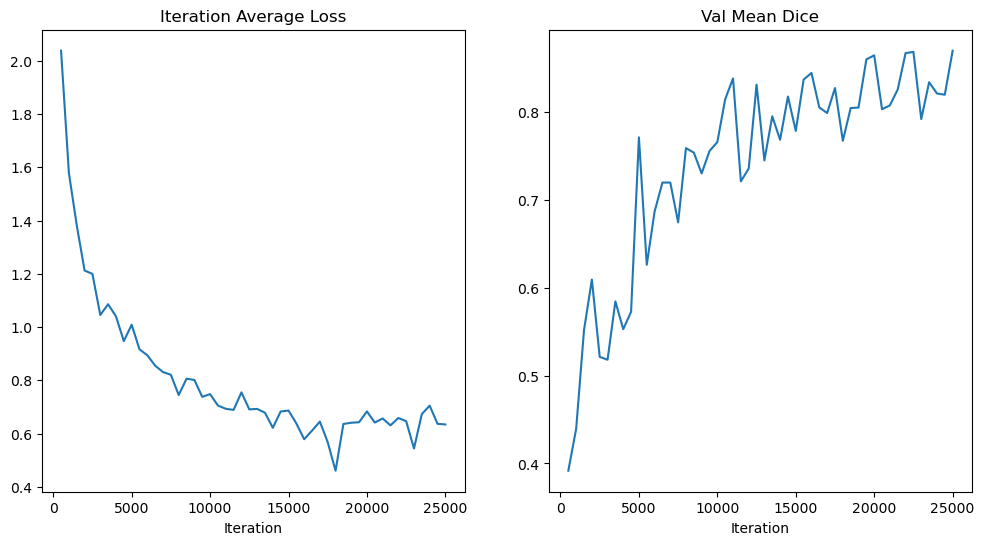

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

/home/user/anaconda3/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_unmulticoncat_onmiccai_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_unmulticoncat_onmiccai_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.63959): 100%|█| 24/24 [00:17<00:00,  1.39it/
Training (47 / 25000 Steps) (loss=2.46398): 100%|█| 24/24 [00:06<00:00,  3.58it/
Training (71 / 25000 Steps) (loss=2.35737): 100%|█| 24/24 [00:06<00:00,  3.51it/
Training (95 / 25000 Steps) (loss=2.32226): 100%|█| 24/24 [00:06<00:00,  3.52it/
Training (119 / 25000 Steps) (loss=2.19239): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (143 / 25000 Steps) (loss=2.49145): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (167 / 25000 Steps) (loss=2.12063): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (191 / 25000 Steps) (loss=2.11497): 100%|█| 24/24 [00:06<00:00,  3.53it
Training (215 / 25000 Steps) (loss=2.11391): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (239 / 25000 Steps) (loss=2.04054): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (263 / 25000 Steps) (loss=2.05356): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (287 / 25000 Steps) (loss=1.98031): 100%|█| 24/24 [00:06<00:00,  3.52it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3717438280582428 Current Avg. Dice: 0.3717438280582428


Training (503 / 25000 Steps) (loss=1.77693): 100%|█| 24/24 [00:08<00:00,  2.92it
Training (527 / 25000 Steps) (loss=1.68380): 100%|█| 24/24 [00:06<00:00,  3.58it
Training (551 / 25000 Steps) (loss=1.80241): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (575 / 25000 Steps) (loss=1.80125): 100%|█| 24/24 [00:06<00:00,  3.53it
Training (599 / 25000 Steps) (loss=1.61323): 100%|█| 24/24 [00:06<00:00,  3.51it
Training (623 / 25000 Steps) (loss=1.85919): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (647 / 25000 Steps) (loss=1.75662): 100%|█| 24/24 [00:06<00:00,  3.55it
Training (671 / 25000 Steps) (loss=1.75358): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (695 / 25000 Steps) (loss=1.55990): 100%|█| 24/24 [00:06<00:00,  3.51it
Training (719 / 25000 Steps) (loss=1.58476): 100%|█| 24/24 [00:06<00:00,  3.53it
Training (743 / 25000 Steps) (loss=1.51340): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (767 / 25000 Steps) (loss=1.60186): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.3717438280582428 Current Avg. Dice: 0.36420392990112305


Training (1007 / 25000 Steps) (loss=1.36519): 100%|█| 24/24 [00:07<00:00,  3.09i
Training (1031 / 25000 Steps) (loss=1.33246): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1055 / 25000 Steps) (loss=1.31998): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1079 / 25000 Steps) (loss=1.37223): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1103 / 25000 Steps) (loss=1.28073): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1127 / 25000 Steps) (loss=1.38648): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (1151 / 25000 Steps) (loss=1.19404): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1175 / 25000 Steps) (loss=1.30662): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1199 / 25000 Steps) (loss=1.46665): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1223 / 25000 Steps) (loss=1.25166): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (1247 / 25000 Steps) (loss=1.31508): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (1271 / 25000 Steps) (loss=1.32135): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.37310314178466797 Current Avg. Dice: 0.37310314178466797


Training (1511 / 25000 Steps) (loss=1.12945): 100%|█| 24/24 [00:08<00:00,  2.93i
Training (1535 / 25000 Steps) (loss=1.35985): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (1559 / 25000 Steps) (loss=1.47912): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1583 / 25000 Steps) (loss=1.23225): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1607 / 25000 Steps) (loss=1.13259): 100%|█| 24/24 [00:06<00:00,  3.48i
Training (1631 / 25000 Steps) (loss=1.25814): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1655 / 25000 Steps) (loss=1.13846): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1679 / 25000 Steps) (loss=1.22262): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (1703 / 25000 Steps) (loss=1.42541): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1727 / 25000 Steps) (loss=1.19790): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1751 / 25000 Steps) (loss=1.26451): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1775 / 25000 Steps) (loss=1.12103): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5245150327682495 Current Avg. Dice: 0.5245150327682495


Training (2015 / 25000 Steps) (loss=0.96011): 100%|█| 24/24 [00:08<00:00,  2.98i
Training (2039 / 25000 Steps) (loss=1.05722): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2063 / 25000 Steps) (loss=1.08333): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2087 / 25000 Steps) (loss=1.45205): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (2111 / 25000 Steps) (loss=1.04771): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2135 / 25000 Steps) (loss=1.09455): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2159 / 25000 Steps) (loss=1.03791): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (2183 / 25000 Steps) (loss=1.10255): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (2207 / 25000 Steps) (loss=1.13388): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (2231 / 25000 Steps) (loss=1.04651): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2255 / 25000 Steps) (loss=1.00155): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2279 / 25000 Steps) (loss=1.02400): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5245150327682495 Current Avg. Dice: 0.510791540145874


Training (2519 / 25000 Steps) (loss=1.03511): 100%|█| 24/24 [00:07<00:00,  3.08i
Training (2543 / 25000 Steps) (loss=1.01144): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (2567 / 25000 Steps) (loss=1.29815): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (2591 / 25000 Steps) (loss=0.98843): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (2615 / 25000 Steps) (loss=1.00055): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2639 / 25000 Steps) (loss=1.00181): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2663 / 25000 Steps) (loss=1.04926): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (2687 / 25000 Steps) (loss=0.98858): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (2711 / 25000 Steps) (loss=1.06475): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2735 / 25000 Steps) (loss=1.14368): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2759 / 25000 Steps) (loss=0.94437): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (2783 / 25000 Steps) (loss=1.00853): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5245150327682495 Current Avg. Dice: 0.38445648550987244


Training (3023 / 25000 Steps) (loss=0.96007): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (3047 / 25000 Steps) (loss=1.00276): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (3071 / 25000 Steps) (loss=0.95376): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (3095 / 25000 Steps) (loss=1.02512): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (3119 / 25000 Steps) (loss=0.99866): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (3143 / 25000 Steps) (loss=1.07926): 100%|█| 24/24 [00:06<00:00,  3.47i
Training (3167 / 25000 Steps) (loss=1.04954): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (3191 / 25000 Steps) (loss=1.05880): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3215 / 25000 Steps) (loss=1.10495): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3239 / 25000 Steps) (loss=0.94496): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3263 / 25000 Steps) (loss=0.99605): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3287 / 25000 Steps) (loss=0.91884): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.548408567905426 Current Avg. Dice: 0.548408567905426


Training (3503 / 25000 Steps) (loss=0.94058): 100%|█| 24/24 [00:07<00:00,  3.08i
Training (3527 / 25000 Steps) (loss=1.27737): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3551 / 25000 Steps) (loss=0.98012): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3575 / 25000 Steps) (loss=1.08619): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (3599 / 25000 Steps) (loss=1.02828): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3623 / 25000 Steps) (loss=0.98210): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3647 / 25000 Steps) (loss=1.04024): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3671 / 25000 Steps) (loss=1.07328): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3695 / 25000 Steps) (loss=1.11027): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3719 / 25000 Steps) (loss=1.02538): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (3743 / 25000 Steps) (loss=1.13079): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (3767 / 25000 Steps) (loss=1.01020): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.548408567905426 Current Avg. Dice: 0.5385972857475281


Training (4007 / 25000 Steps) (loss=1.06920): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (4031 / 25000 Steps) (loss=0.86281): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (4055 / 25000 Steps) (loss=1.08721): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (4079 / 25000 Steps) (loss=0.92783): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4103 / 25000 Steps) (loss=1.21181): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4127 / 25000 Steps) (loss=0.93137): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4151 / 25000 Steps) (loss=0.94261): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4175 / 25000 Steps) (loss=0.94802): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4199 / 25000 Steps) (loss=0.94827): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4223 / 25000 Steps) (loss=0.98801): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4247 / 25000 Steps) (loss=0.91674): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (4271 / 25000 Steps) (loss=1.06730): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6466261744499207 Current Avg. Dice: 0.6466261744499207


Training (4511 / 25000 Steps) (loss=1.20060): 100%|█| 24/24 [00:07<00:00,  3.12i
Training (4535 / 25000 Steps) (loss=0.89124): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4559 / 25000 Steps) (loss=0.88782): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4583 / 25000 Steps) (loss=0.88029): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4607 / 25000 Steps) (loss=0.89724): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4631 / 25000 Steps) (loss=0.94017): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4655 / 25000 Steps) (loss=0.90089): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4679 / 25000 Steps) (loss=0.90941): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4703 / 25000 Steps) (loss=1.08285): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4727 / 25000 Steps) (loss=0.96773): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4751 / 25000 Steps) (loss=0.83893): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4775 / 25000 Steps) (loss=1.01517): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6466261744499207 Current Avg. Dice: 0.6040591597557068


Training (5015 / 25000 Steps) (loss=0.89350): 100%|█| 24/24 [00:07<00:00,  3.15i
Training (5039 / 25000 Steps) (loss=0.99040): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5063 / 25000 Steps) (loss=0.93807): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5087 / 25000 Steps) (loss=0.96120): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (5111 / 25000 Steps) (loss=0.94060): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5135 / 25000 Steps) (loss=0.87973): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5159 / 25000 Steps) (loss=0.94780): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5183 / 25000 Steps) (loss=0.91189): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5207 / 25000 Steps) (loss=0.97213): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5231 / 25000 Steps) (loss=0.82638): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5255 / 25000 Steps) (loss=0.92386): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5279 / 25000 Steps) (loss=0.93346): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6466261744499207 Current Avg. Dice: 0.5600353479385376


Training (5519 / 25000 Steps) (loss=0.95038): 100%|█| 24/24 [00:07<00:00,  3.16i
Training (5543 / 25000 Steps) (loss=1.12166): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5567 / 25000 Steps) (loss=1.07998): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5591 / 25000 Steps) (loss=0.85206): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5615 / 25000 Steps) (loss=1.00624): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5639 / 25000 Steps) (loss=1.02533): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5663 / 25000 Steps) (loss=0.84034): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5687 / 25000 Steps) (loss=0.85672): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5711 / 25000 Steps) (loss=0.89402): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5735 / 25000 Steps) (loss=0.78177): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5759 / 25000 Steps) (loss=1.00262): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5783 / 25000 Steps) (loss=0.89626): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6466261744499207 Current Avg. Dice: 0.6157031655311584


Training (6023 / 25000 Steps) (loss=0.87577): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (6047 / 25000 Steps) (loss=0.89696): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6071 / 25000 Steps) (loss=0.81927): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6095 / 25000 Steps) (loss=0.85613): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6119 / 25000 Steps) (loss=1.25260): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (6143 / 25000 Steps) (loss=0.80541): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (6167 / 25000 Steps) (loss=0.82699): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6191 / 25000 Steps) (loss=0.82189): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6215 / 25000 Steps) (loss=0.86909): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6239 / 25000 Steps) (loss=0.84180): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6263 / 25000 Steps) (loss=0.80437): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6287 / 25000 Steps) (loss=1.11423): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6466261744499207 Current Avg. Dice: 0.5894101858139038


Training (6503 / 25000 Steps) (loss=0.80482): 100%|█| 24/24 [00:07<00:00,  3.18i
Training (6527 / 25000 Steps) (loss=0.83622): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6551 / 25000 Steps) (loss=0.87395): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6575 / 25000 Steps) (loss=0.92536): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6599 / 25000 Steps) (loss=0.80300): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6623 / 25000 Steps) (loss=0.95050): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6647 / 25000 Steps) (loss=0.80066): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6671 / 25000 Steps) (loss=0.87318): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6695 / 25000 Steps) (loss=0.87336): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6719 / 25000 Steps) (loss=0.75937): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (6743 / 25000 Steps) (loss=0.79021): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6767 / 25000 Steps) (loss=0.78805): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6466261744499207 Current Avg. Dice: 0.6015458106994629


Training (7007 / 25000 Steps) (loss=0.99033): 100%|█| 24/24 [00:07<00:00,  3.14i
Training (7031 / 25000 Steps) (loss=0.94441): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7055 / 25000 Steps) (loss=0.82083): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7079 / 25000 Steps) (loss=0.84488): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7103 / 25000 Steps) (loss=0.92455): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7127 / 25000 Steps) (loss=0.84101): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7151 / 25000 Steps) (loss=0.78524): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7175 / 25000 Steps) (loss=0.91677): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7199 / 25000 Steps) (loss=0.89351): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7223 / 25000 Steps) (loss=0.83592): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7247 / 25000 Steps) (loss=0.92825): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7271 / 25000 Steps) (loss=0.82873): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6680002808570862 Current Avg. Dice: 0.6680002808570862


Training (7511 / 25000 Steps) (loss=0.86394): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (7535 / 25000 Steps) (loss=0.69937): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7559 / 25000 Steps) (loss=0.83226): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7583 / 25000 Steps) (loss=0.80777): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7607 / 25000 Steps) (loss=0.77623): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (7631 / 25000 Steps) (loss=0.84992): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7655 / 25000 Steps) (loss=0.81823): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7679 / 25000 Steps) (loss=0.75885): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7703 / 25000 Steps) (loss=0.77919): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7727 / 25000 Steps) (loss=0.85825): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7751 / 25000 Steps) (loss=0.94495): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7775 / 25000 Steps) (loss=0.71211): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6680002808570862 Current Avg. Dice: 0.6645123362541199


Training (8015 / 25000 Steps) (loss=0.80787): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (8039 / 25000 Steps) (loss=0.87527): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8063 / 25000 Steps) (loss=0.73159): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (8087 / 25000 Steps) (loss=0.81278): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8111 / 25000 Steps) (loss=0.84263): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8135 / 25000 Steps) (loss=1.04750): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8159 / 25000 Steps) (loss=0.88321): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (8183 / 25000 Steps) (loss=0.73453): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (8207 / 25000 Steps) (loss=0.87423): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8231 / 25000 Steps) (loss=0.82548): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8255 / 25000 Steps) (loss=0.73419): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8279 / 25000 Steps) (loss=0.74691): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6752274036407471 Current Avg. Dice: 0.6752274036407471


Training (8519 / 25000 Steps) (loss=0.75049): 100%|█| 24/24 [00:07<00:00,  3.11i
Training (8543 / 25000 Steps) (loss=0.70603): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (8567 / 25000 Steps) (loss=0.80128): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8591 / 25000 Steps) (loss=0.83307): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (8615 / 25000 Steps) (loss=0.72547): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8639 / 25000 Steps) (loss=0.81506): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (8663 / 25000 Steps) (loss=0.78549): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8687 / 25000 Steps) (loss=0.75123): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8711 / 25000 Steps) (loss=0.71354): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8735 / 25000 Steps) (loss=0.94540): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8759 / 25000 Steps) (loss=0.91740): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8783 / 25000 Steps) (loss=0.73229): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6819198131561279 Current Avg. Dice: 0.6819198131561279


Training (9023 / 25000 Steps) (loss=0.76038): 100%|█| 24/24 [00:07<00:00,  3.12i
Training (9047 / 25000 Steps) (loss=0.72200): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9071 / 25000 Steps) (loss=0.67115): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9095 / 25000 Steps) (loss=0.77843): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9119 / 25000 Steps) (loss=0.81333): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9143 / 25000 Steps) (loss=0.80669): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9167 / 25000 Steps) (loss=0.89730): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9191 / 25000 Steps) (loss=0.76571): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9215 / 25000 Steps) (loss=0.68542): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9239 / 25000 Steps) (loss=0.78286): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9263 / 25000 Steps) (loss=0.87082): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9287 / 25000 Steps) (loss=0.81881): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6949710845947266 Current Avg. Dice: 0.6949710845947266


Training (9503 / 25000 Steps) (loss=0.77944): 100%|█| 24/24 [00:07<00:00,  3.11i
Training (9527 / 25000 Steps) (loss=0.75909): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9551 / 25000 Steps) (loss=0.73934): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9575 / 25000 Steps) (loss=0.96374): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9599 / 25000 Steps) (loss=0.67642): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9623 / 25000 Steps) (loss=0.69944): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9647 / 25000 Steps) (loss=0.76715): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9671 / 25000 Steps) (loss=0.80374): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9695 / 25000 Steps) (loss=0.74707): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9719 / 25000 Steps) (loss=0.89321): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9743 / 25000 Steps) (loss=0.67694): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9767 / 25000 Steps) (loss=0.82573): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7551433444023132 Current Avg. Dice: 0.7551433444023132


Training (10007 / 25000 Steps) (loss=0.68887): 100%|█| 24/24 [00:07<00:00,  3.09
Training (10031 / 25000 Steps) (loss=0.53588): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10055 / 25000 Steps) (loss=0.65782): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10079 / 25000 Steps) (loss=0.60697): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10103 / 25000 Steps) (loss=0.77359): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10127 / 25000 Steps) (loss=0.77678): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10151 / 25000 Steps) (loss=0.73736): 100%|█| 24/24 [00:06<00:00,  3.57
Training (10175 / 25000 Steps) (loss=0.60732): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10199 / 25000 Steps) (loss=0.92970): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10223 / 25000 Steps) (loss=0.76096): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10247 / 25000 Steps) (loss=0.84256): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10271 / 25000 Steps) (loss=0.63660): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7684103846549988 Current Avg. Dice: 0.7684103846549988


Training (10511 / 25000 Steps) (loss=0.96065): 100%|█| 24/24 [00:07<00:00,  3.10
Training (10535 / 25000 Steps) (loss=0.83954): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10559 / 25000 Steps) (loss=0.75452): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10583 / 25000 Steps) (loss=0.80309): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10607 / 25000 Steps) (loss=0.72855): 100%|█| 24/24 [00:06<00:00,  3.57
Training (10631 / 25000 Steps) (loss=0.73746): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10655 / 25000 Steps) (loss=0.85840): 100%|█| 24/24 [00:06<00:00,  3.57
Training (10679 / 25000 Steps) (loss=0.83395): 100%|█| 24/24 [00:06<00:00,  3.56
Training (10703 / 25000 Steps) (loss=0.68634): 100%|█| 24/24 [00:06<00:00,  3.57
Training (10727 / 25000 Steps) (loss=0.66974): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10751 / 25000 Steps) (loss=0.84473): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10775 / 25000 Steps) (loss=0.74746): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7984910607337952 Current Avg. Dice: 0.7984910607337952


Training (11015 / 25000 Steps) (loss=0.73485): 100%|█| 24/24 [00:07<00:00,  3.07
Training (11039 / 25000 Steps) (loss=0.69347): 100%|█| 24/24 [00:06<00:00,  3.57
Training (11063 / 25000 Steps) (loss=0.72502): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11087 / 25000 Steps) (loss=0.70160): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11111 / 25000 Steps) (loss=0.76416): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11135 / 25000 Steps) (loss=0.61846): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11159 / 25000 Steps) (loss=0.71969): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11183 / 25000 Steps) (loss=0.61589): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11207 / 25000 Steps) (loss=1.08591): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11231 / 25000 Steps) (loss=0.54044): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11255 / 25000 Steps) (loss=0.58652): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11279 / 25000 Steps) (loss=0.73896): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7984910607337952 Current Avg. Dice: 0.7468840479850769


Training (11519 / 25000 Steps) (loss=0.64257): 100%|█| 24/24 [00:07<00:00,  3.17
Training (11543 / 25000 Steps) (loss=0.74233): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11567 / 25000 Steps) (loss=0.74514): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11591 / 25000 Steps) (loss=0.72933): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11615 / 25000 Steps) (loss=0.71176): 100%|█| 24/24 [00:06<00:00,  3.56
Training (11639 / 25000 Steps) (loss=0.74842): 100%|█| 24/24 [00:06<00:00,  3.57
Training (11663 / 25000 Steps) (loss=0.77850): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11687 / 25000 Steps) (loss=0.81349): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11711 / 25000 Steps) (loss=0.84950): 100%|█| 24/24 [00:06<00:00,  3.57
Training (11735 / 25000 Steps) (loss=0.67769): 100%|█| 24/24 [00:06<00:00,  3.57
Training (11759 / 25000 Steps) (loss=0.68293): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11783 / 25000 Steps) (loss=0.67018): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7984910607337952 Current Avg. Dice: 0.732316792011261


Training (12023 / 25000 Steps) (loss=0.67646): 100%|█| 24/24 [00:07<00:00,  3.15
Training (12047 / 25000 Steps) (loss=0.76801): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12071 / 25000 Steps) (loss=0.75445): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12095 / 25000 Steps) (loss=0.75065): 100%|█| 24/24 [00:06<00:00,  3.57
Training (12119 / 25000 Steps) (loss=0.79148): 100%|█| 24/24 [00:06<00:00,  3.57
Training (12143 / 25000 Steps) (loss=0.67449): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12167 / 25000 Steps) (loss=0.59701): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12191 / 25000 Steps) (loss=0.65886): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12215 / 25000 Steps) (loss=0.94396): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12239 / 25000 Steps) (loss=0.55048): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12263 / 25000 Steps) (loss=0.83209): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12287 / 25000 Steps) (loss=0.60328): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.826280415058136


Training (12503 / 25000 Steps) (loss=0.66933): 100%|█| 24/24 [00:07<00:00,  3.09
Training (12527 / 25000 Steps) (loss=0.78883): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12551 / 25000 Steps) (loss=0.78800): 100%|█| 24/24 [00:06<00:00,  3.56
Training (12575 / 25000 Steps) (loss=0.65760): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12599 / 25000 Steps) (loss=0.78236): 100%|█| 24/24 [00:06<00:00,  3.56
Training (12623 / 25000 Steps) (loss=0.59155): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12647 / 25000 Steps) (loss=0.70398): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12671 / 25000 Steps) (loss=0.82924): 100%|█| 24/24 [00:06<00:00,  3.55
Training (12695 / 25000 Steps) (loss=0.77524): 100%|█| 24/24 [00:06<00:00,  3.57
Training (12719 / 25000 Steps) (loss=0.85940): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12743 / 25000 Steps) (loss=0.65245): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12767 / 25000 Steps) (loss=0.72020): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7950736880302429


Training (13007 / 25000 Steps) (loss=0.80514): 100%|█| 24/24 [00:07<00:00,  3.16
Training (13031 / 25000 Steps) (loss=0.77285): 100%|█| 24/24 [00:06<00:00,  3.57
Training (13055 / 25000 Steps) (loss=0.66619): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13079 / 25000 Steps) (loss=0.64961): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13103 / 25000 Steps) (loss=0.68182): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13127 / 25000 Steps) (loss=0.63228): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13151 / 25000 Steps) (loss=0.67146): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13175 / 25000 Steps) (loss=0.63359): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13199 / 25000 Steps) (loss=0.63639): 100%|█| 24/24 [00:06<00:00,  3.54
Training (13223 / 25000 Steps) (loss=0.54294): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13247 / 25000 Steps) (loss=0.78109): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13271 / 25000 Steps) (loss=0.67350): 100%|█| 24/24 [00:06<00:00,  3.57
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7373945116996765


Training (13511 / 25000 Steps) (loss=0.81450): 100%|█| 24/24 [00:07<00:00,  3.17
Training (13535 / 25000 Steps) (loss=0.86959): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13559 / 25000 Steps) (loss=0.78545): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13583 / 25000 Steps) (loss=0.74140): 100%|█| 24/24 [00:06<00:00,  3.57
Training (13607 / 25000 Steps) (loss=0.60399): 100%|█| 24/24 [00:06<00:00,  3.57
Training (13631 / 25000 Steps) (loss=0.85469): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13655 / 25000 Steps) (loss=0.62908): 100%|█| 24/24 [00:06<00:00,  3.57
Training (13679 / 25000 Steps) (loss=0.74413): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13703 / 25000 Steps) (loss=0.65258): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13727 / 25000 Steps) (loss=0.72100): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13751 / 25000 Steps) (loss=0.54804): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13775 / 25000 Steps) (loss=0.74122): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7756979465484619


Training (14015 / 25000 Steps) (loss=0.75372): 100%|█| 24/24 [00:07<00:00,  3.17
Training (14039 / 25000 Steps) (loss=0.51993): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14063 / 25000 Steps) (loss=0.70483): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14087 / 25000 Steps) (loss=0.62940): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14111 / 25000 Steps) (loss=0.80375): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14135 / 25000 Steps) (loss=0.69302): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14159 / 25000 Steps) (loss=0.56729): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14183 / 25000 Steps) (loss=1.10580): 100%|█| 24/24 [00:06<00:00,  3.55
Training (14207 / 25000 Steps) (loss=0.89037): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14231 / 25000 Steps) (loss=0.57847): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14255 / 25000 Steps) (loss=0.83407): 100%|█| 24/24 [00:06<00:00,  3.56
Training (14279 / 25000 Steps) (loss=0.67150): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7886659502983093


Training (14519 / 25000 Steps) (loss=0.71839): 100%|█| 24/24 [00:07<00:00,  3.16
Training (14543 / 25000 Steps) (loss=0.81255): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14567 / 25000 Steps) (loss=0.69279): 100%|█| 24/24 [00:06<00:00,  3.55
Training (14591 / 25000 Steps) (loss=0.67579): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14615 / 25000 Steps) (loss=0.39179): 100%|█| 24/24 [00:06<00:00,  3.56
Training (14639 / 25000 Steps) (loss=0.72158): 100%|█| 24/24 [00:06<00:00,  3.56
Training (14663 / 25000 Steps) (loss=0.73150): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14687 / 25000 Steps) (loss=0.70012): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14711 / 25000 Steps) (loss=0.71247): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14735 / 25000 Steps) (loss=0.57569): 100%|█| 24/24 [00:06<00:00,  3.53
Training (14759 / 25000 Steps) (loss=0.81281): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14783 / 25000 Steps) (loss=0.66079): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.800147533416748


Training (15023 / 25000 Steps) (loss=0.71701): 100%|█| 24/24 [00:07<00:00,  3.17
Training (15047 / 25000 Steps) (loss=0.71147): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15071 / 25000 Steps) (loss=0.72234): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15095 / 25000 Steps) (loss=0.73054): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15119 / 25000 Steps) (loss=0.72604): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15143 / 25000 Steps) (loss=0.77449): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15167 / 25000 Steps) (loss=0.72130): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15191 / 25000 Steps) (loss=0.71561): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15215 / 25000 Steps) (loss=0.61372): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15239 / 25000 Steps) (loss=0.71694): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15263 / 25000 Steps) (loss=0.65126): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15287 / 25000 Steps) (loss=0.86253): 100%|█| 24/24 [00:06<00:00,  3.55
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7210944294929504


Training (15503 / 25000 Steps) (loss=0.54990): 100%|█| 24/24 [00:07<00:00,  3.15
Training (15527 / 25000 Steps) (loss=0.49803): 100%|█| 24/24 [00:06<00:00,  3.55
Training (15551 / 25000 Steps) (loss=0.77821): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15575 / 25000 Steps) (loss=0.64680): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15599 / 25000 Steps) (loss=0.66409): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15623 / 25000 Steps) (loss=0.54097): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15647 / 25000 Steps) (loss=0.74749): 100%|█| 24/24 [00:06<00:00,  3.56
Training (15671 / 25000 Steps) (loss=0.68691): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15695 / 25000 Steps) (loss=0.58277): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15719 / 25000 Steps) (loss=0.52316): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15743 / 25000 Steps) (loss=0.52152): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15767 / 25000 Steps) (loss=0.62944): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7487677931785583


Training (16007 / 25000 Steps) (loss=0.57787): 100%|█| 24/24 [00:07<00:00,  3.16
Training (16031 / 25000 Steps) (loss=0.57020): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16055 / 25000 Steps) (loss=0.76520): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16079 / 25000 Steps) (loss=0.55592): 100%|█| 24/24 [00:06<00:00,  3.55
Training (16103 / 25000 Steps) (loss=0.65784): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16127 / 25000 Steps) (loss=0.66528): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16151 / 25000 Steps) (loss=0.67294): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16175 / 25000 Steps) (loss=0.74739): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16199 / 25000 Steps) (loss=0.77584): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16223 / 25000 Steps) (loss=0.72845): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16247 / 25000 Steps) (loss=0.59510): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16271 / 25000 Steps) (loss=0.87019): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7519983649253845


Training (16511 / 25000 Steps) (loss=0.63134): 100%|█| 24/24 [00:07<00:00,  3.16
Training (16535 / 25000 Steps) (loss=0.61385): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16559 / 25000 Steps) (loss=0.56892): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16583 / 25000 Steps) (loss=0.48893): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16607 / 25000 Steps) (loss=0.63073): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16631 / 25000 Steps) (loss=0.80926): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16655 / 25000 Steps) (loss=0.78083): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16679 / 25000 Steps) (loss=0.56249): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16703 / 25000 Steps) (loss=0.69317): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16727 / 25000 Steps) (loss=0.87565): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16751 / 25000 Steps) (loss=0.52253): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16775 / 25000 Steps) (loss=0.62735): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.8097581267356873


Training (17015 / 25000 Steps) (loss=0.73911): 100%|█| 24/24 [00:07<00:00,  3.17
Training (17039 / 25000 Steps) (loss=0.70801): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17063 / 25000 Steps) (loss=0.65995): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17087 / 25000 Steps) (loss=0.70126): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17111 / 25000 Steps) (loss=0.69026): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17135 / 25000 Steps) (loss=0.63199): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17159 / 25000 Steps) (loss=0.67671): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17183 / 25000 Steps) (loss=0.63391): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17207 / 25000 Steps) (loss=0.73199): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17231 / 25000 Steps) (loss=0.74405): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17255 / 25000 Steps) (loss=0.68391): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17279 / 25000 Steps) (loss=0.55382): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7723758816719055


Training (17519 / 25000 Steps) (loss=0.69111): 100%|█| 24/24 [00:07<00:00,  3.17
Training (17543 / 25000 Steps) (loss=0.69925): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17567 / 25000 Steps) (loss=0.72331): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17591 / 25000 Steps) (loss=0.64456): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17615 / 25000 Steps) (loss=0.60883): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17639 / 25000 Steps) (loss=0.74462): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17663 / 25000 Steps) (loss=0.67094): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17687 / 25000 Steps) (loss=0.53506): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17711 / 25000 Steps) (loss=0.66056): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17735 / 25000 Steps) (loss=0.68593): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17759 / 25000 Steps) (loss=0.72828): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17783 / 25000 Steps) (loss=0.72409): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.8044236302375793


Training (18023 / 25000 Steps) (loss=0.53569): 100%|█| 24/24 [00:07<00:00,  3.17
Training (18047 / 25000 Steps) (loss=0.48319): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18071 / 25000 Steps) (loss=0.78056): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18095 / 25000 Steps) (loss=0.68326): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18119 / 25000 Steps) (loss=0.82557): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18143 / 25000 Steps) (loss=0.57210): 100%|█| 24/24 [00:06<00:00,  3.60
Training (18167 / 25000 Steps) (loss=0.70745): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18191 / 25000 Steps) (loss=0.61734): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18215 / 25000 Steps) (loss=0.87219): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18239 / 25000 Steps) (loss=0.81217): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18263 / 25000 Steps) (loss=0.74705): 100%|█| 24/24 [00:06<00:00,  3.56
Training (18287 / 25000 Steps) (loss=0.75984): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7692394256591797


Training (18503 / 25000 Steps) (loss=0.54753): 100%|█| 24/24 [00:07<00:00,  3.17
Training (18527 / 25000 Steps) (loss=0.58429): 100%|█| 24/24 [00:06<00:00,  3.55
Training (18551 / 25000 Steps) (loss=0.56295): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18575 / 25000 Steps) (loss=0.69676): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18599 / 25000 Steps) (loss=0.49606): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18623 / 25000 Steps) (loss=0.68757): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18647 / 25000 Steps) (loss=0.75087): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18671 / 25000 Steps) (loss=0.57647): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18695 / 25000 Steps) (loss=0.61425): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18719 / 25000 Steps) (loss=0.60851): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18743 / 25000 Steps) (loss=0.65397): 100%|█| 24/24 [00:06<00:00,  3.55
Training (18767 / 25000 Steps) (loss=0.67615): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7784395217895508


Training (19007 / 25000 Steps) (loss=0.62901): 100%|█| 24/24 [00:07<00:00,  3.16
Training (19031 / 25000 Steps) (loss=0.55288): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19055 / 25000 Steps) (loss=0.71520): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19079 / 25000 Steps) (loss=0.50311): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19103 / 25000 Steps) (loss=0.60332): 100%|█| 24/24 [00:06<00:00,  3.56
Training (19127 / 25000 Steps) (loss=0.70937): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19151 / 25000 Steps) (loss=0.55560): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19175 / 25000 Steps) (loss=0.77546): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19199 / 25000 Steps) (loss=0.73447): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19223 / 25000 Steps) (loss=0.59299): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19247 / 25000 Steps) (loss=0.67074): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19271 / 25000 Steps) (loss=0.54107): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7786440253257751


Training (19511 / 25000 Steps) (loss=0.73050): 100%|█| 24/24 [00:07<00:00,  3.16
Training (19535 / 25000 Steps) (loss=0.86282): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19559 / 25000 Steps) (loss=0.70880): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19583 / 25000 Steps) (loss=0.64224): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19607 / 25000 Steps) (loss=0.55569): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19631 / 25000 Steps) (loss=0.64042): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19655 / 25000 Steps) (loss=0.68716): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19679 / 25000 Steps) (loss=0.72932): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19703 / 25000 Steps) (loss=0.68538): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19727 / 25000 Steps) (loss=0.61583): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19751 / 25000 Steps) (loss=0.59040): 100%|█| 24/24 [00:06<00:00,  3.56
Training (19775 / 25000 Steps) (loss=0.88592): 100%|█| 24/24 [00:06<00:00,  3.56
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7838380932807922


Training (20015 / 25000 Steps) (loss=0.55673): 100%|█| 24/24 [00:07<00:00,  3.14
Training (20039 / 25000 Steps) (loss=0.54854): 100%|█| 24/24 [00:06<00:00,  3.57
Training (20063 / 25000 Steps) (loss=0.70595): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20087 / 25000 Steps) (loss=0.69360): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20111 / 25000 Steps) (loss=0.57680): 100%|█| 24/24 [00:06<00:00,  3.57
Training (20135 / 25000 Steps) (loss=0.59002): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20159 / 25000 Steps) (loss=0.63679): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20183 / 25000 Steps) (loss=0.82167): 100%|█| 24/24 [00:06<00:00,  3.57
Training (20207 / 25000 Steps) (loss=0.60236): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20231 / 25000 Steps) (loss=0.59733): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20255 / 25000 Steps) (loss=0.66494): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20279 / 25000 Steps) (loss=0.54198): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.8038928508758545


Training (20519 / 25000 Steps) (loss=0.69309): 100%|█| 24/24 [00:07<00:00,  3.16
Training (20543 / 25000 Steps) (loss=0.66697): 100%|█| 24/24 [00:06<00:00,  3.57
Training (20567 / 25000 Steps) (loss=0.66136): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20591 / 25000 Steps) (loss=0.57829): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20615 / 25000 Steps) (loss=0.68503): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20639 / 25000 Steps) (loss=0.63302): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20663 / 25000 Steps) (loss=0.71926): 100%|█| 24/24 [00:06<00:00,  3.55
Training (20687 / 25000 Steps) (loss=0.69284): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20711 / 25000 Steps) (loss=0.75309): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20735 / 25000 Steps) (loss=0.80354): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20759 / 25000 Steps) (loss=0.75607): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20783 / 25000 Steps) (loss=0.58020): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.8112499117851257


Training (21023 / 25000 Steps) (loss=0.75847): 100%|█| 24/24 [00:07<00:00,  3.16
Training (21047 / 25000 Steps) (loss=0.49426): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21071 / 25000 Steps) (loss=0.74801): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21095 / 25000 Steps) (loss=0.46386): 100%|█| 24/24 [00:06<00:00,  3.56
Training (21119 / 25000 Steps) (loss=0.64192): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21143 / 25000 Steps) (loss=0.49613): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21167 / 25000 Steps) (loss=0.75469): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21191 / 25000 Steps) (loss=0.62605): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21215 / 25000 Steps) (loss=0.56050): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21239 / 25000 Steps) (loss=0.66348): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21263 / 25000 Steps) (loss=0.55960): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21287 / 25000 Steps) (loss=0.46599): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.7973034381866455


Training (21503 / 25000 Steps) (loss=0.69128): 100%|█| 24/24 [00:07<00:00,  3.17
Training (21527 / 25000 Steps) (loss=0.54266): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21551 / 25000 Steps) (loss=0.57371): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21575 / 25000 Steps) (loss=0.60725): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21599 / 25000 Steps) (loss=0.49455): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21623 / 25000 Steps) (loss=0.82966): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21647 / 25000 Steps) (loss=0.72624): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21671 / 25000 Steps) (loss=0.63194): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21695 / 25000 Steps) (loss=0.80831): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21719 / 25000 Steps) (loss=0.43047): 100%|█| 24/24 [00:06<00:00,  3.56
Training (21743 / 25000 Steps) (loss=0.72390): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21767 / 25000 Steps) (loss=0.71686): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.8072778582572937


Training (22007 / 25000 Steps) (loss=0.65452): 100%|█| 24/24 [00:07<00:00,  3.16
Training (22031 / 25000 Steps) (loss=0.79079): 100%|█| 24/24 [00:06<00:00,  3.53
Training (22055 / 25000 Steps) (loss=0.79441): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22079 / 25000 Steps) (loss=0.67659): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22103 / 25000 Steps) (loss=0.66273): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22127 / 25000 Steps) (loss=0.60360): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22151 / 25000 Steps) (loss=0.73290): 100%|█| 24/24 [00:06<00:00,  3.56
Training (22175 / 25000 Steps) (loss=0.75140): 100%|█| 24/24 [00:06<00:00,  3.56
Training (22199 / 25000 Steps) (loss=0.54699): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22223 / 25000 Steps) (loss=0.64048): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22247 / 25000 Steps) (loss=0.67122): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22271 / 25000 Steps) (loss=0.65974): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.8168373703956604


Training (22511 / 25000 Steps) (loss=0.61927): 100%|█| 24/24 [00:07<00:00,  3.16
Training (22535 / 25000 Steps) (loss=0.64285): 100%|█| 24/24 [00:06<00:00,  3.56
Training (22559 / 25000 Steps) (loss=0.67011): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22583 / 25000 Steps) (loss=0.58048): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22607 / 25000 Steps) (loss=0.58054): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22631 / 25000 Steps) (loss=0.60057): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22655 / 25000 Steps) (loss=0.69210): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22679 / 25000 Steps) (loss=0.56076): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22703 / 25000 Steps) (loss=0.55097): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22727 / 25000 Steps) (loss=0.49302): 100%|█| 24/24 [00:06<00:00,  3.56
Training (22751 / 25000 Steps) (loss=0.68215): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22775 / 25000 Steps) (loss=0.64256): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.826280415058136 Current Avg. Dice: 0.8160500526428223


Training (23015 / 25000 Steps) (loss=0.68112): 100%|█| 24/24 [00:07<00:00,  3.15
Training (23039 / 25000 Steps) (loss=0.60066): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23063 / 25000 Steps) (loss=0.66813): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23087 / 25000 Steps) (loss=0.41291): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23111 / 25000 Steps) (loss=0.55152): 100%|█| 24/24 [00:06<00:00,  3.56
Training (23135 / 25000 Steps) (loss=0.59674): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23159 / 25000 Steps) (loss=0.56575): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23183 / 25000 Steps) (loss=0.69794): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23207 / 25000 Steps) (loss=0.76144): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23231 / 25000 Steps) (loss=0.51429): 100%|█| 24/24 [00:06<00:00,  3.55
Training (23255 / 25000 Steps) (loss=0.63248): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23279 / 25000 Steps) (loss=0.73442): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8402424454689026 Current Avg. Dice: 0.8402424454689026


Training (23519 / 25000 Steps) (loss=0.69370): 100%|█| 24/24 [00:07<00:00,  3.10
Training (23543 / 25000 Steps) (loss=0.68688): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23567 / 25000 Steps) (loss=0.65907): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23591 / 25000 Steps) (loss=0.58626): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23615 / 25000 Steps) (loss=0.57353): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23639 / 25000 Steps) (loss=0.74459): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23663 / 25000 Steps) (loss=0.71093): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23687 / 25000 Steps) (loss=0.71727): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23711 / 25000 Steps) (loss=0.55153): 100%|█| 24/24 [00:06<00:00,  3.56
Training (23735 / 25000 Steps) (loss=0.48296): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23759 / 25000 Steps) (loss=0.60272): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23783 / 25000 Steps) (loss=0.68385): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8402424454689026 Current Avg. Dice: 0.8222296833992004


Training (24023 / 25000 Steps) (loss=0.67335): 100%|█| 24/24 [00:07<00:00,  3.16
Training (24047 / 25000 Steps) (loss=0.57754): 100%|█| 24/24 [00:06<00:00,  3.56
Training (24071 / 25000 Steps) (loss=0.63223): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24095 / 25000 Steps) (loss=0.66073): 100%|█| 24/24 [00:06<00:00,  3.57
Training (24119 / 25000 Steps) (loss=0.67575): 100%|█| 24/24 [00:06<00:00,  3.57
Training (24143 / 25000 Steps) (loss=0.64676): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24167 / 25000 Steps) (loss=0.54000): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24191 / 25000 Steps) (loss=0.66110): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24215 / 25000 Steps) (loss=0.64533): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24239 / 25000 Steps) (loss=0.83065): 100%|█| 24/24 [00:06<00:00,  3.55
Training (24263 / 25000 Steps) (loss=0.63850): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24287 / 25000 Steps) (loss=0.65989): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8402424454689026 Current Avg. Dice: 0.7763898968696594


Training (24503 / 25000 Steps) (loss=0.65436): 100%|█| 24/24 [00:07<00:00,  3.16
Training (24527 / 25000 Steps) (loss=0.75937): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24551 / 25000 Steps) (loss=0.44451): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24575 / 25000 Steps) (loss=0.68863): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24599 / 25000 Steps) (loss=0.64071): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24623 / 25000 Steps) (loss=0.62347): 100%|█| 24/24 [00:06<00:00,  3.56
Training (24647 / 25000 Steps) (loss=0.35173): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24671 / 25000 Steps) (loss=0.56644): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24695 / 25000 Steps) (loss=0.71126): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24719 / 25000 Steps) (loss=0.72776): 100%|█| 24/24 [00:06<00:00,  3.57
Training (24743 / 25000 Steps) (loss=0.82842): 100%|█| 24/24 [00:06<00:00,  3.56
Training (24767 / 25000 Steps) (loss=0.59559): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8402424454689026 Current Avg. Dice: 0.8014159798622131


Training (25007 / 25000 Steps) (loss=0.74824): 100%|█| 24/24 [00:07<00:00,  3.15


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8402 at iteration: 23500


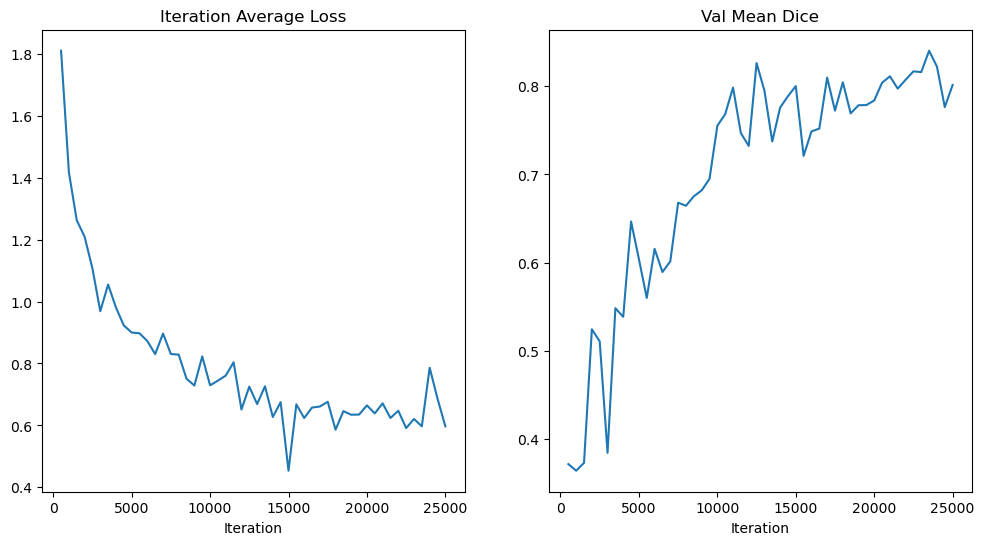

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 2
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.35it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

/home/user/anaconda3/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train() 
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_unmulticoncat_onmiccai_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_unmulticoncat_onmiccai_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.55108): 100%|█| 24/24 [00:17<00:00,  1.39it/
Training (47 / 25000 Steps) (loss=2.32165): 100%|█| 24/24 [00:06<00:00,  3.60it/
Training (71 / 25000 Steps) (loss=2.30243): 100%|█| 24/24 [00:06<00:00,  3.60it/
Training (95 / 25000 Steps) (loss=2.21110): 100%|█| 24/24 [00:06<00:00,  3.53it/
Training (119 / 25000 Steps) (loss=2.19564): 100%|█| 24/24 [00:06<00:00,  3.50it
Training (143 / 25000 Steps) (loss=2.07210): 100%|█| 24/24 [00:06<00:00,  3.55it
Training (167 / 25000 Steps) (loss=2.18210): 100%|█| 24/24 [00:06<00:00,  3.52it
Training (191 / 25000 Steps) (loss=1.99961): 100%|█| 24/24 [00:06<00:00,  3.58it
Training (215 / 25000 Steps) (loss=2.10910): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (239 / 25000 Steps) (loss=2.14450): 100%|█| 24/24 [00:06<00:00,  3.55it
Training (263 / 25000 Steps) (loss=1.92172): 100%|█| 24/24 [00:06<00:00,  3.55it
Training (287 / 25000 Steps) (loss=2.10495): 100%|█| 24/24 [00:06<00:00,  3.59it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.37577465176582336 Current Avg. Dice: 0.37577465176582336


Training (503 / 25000 Steps) (loss=1.72068): 100%|█| 24/24 [00:08<00:00,  2.93it
Training (527 / 25000 Steps) (loss=1.68517): 100%|█| 24/24 [00:06<00:00,  3.58it
Training (551 / 25000 Steps) (loss=1.75743): 100%|█| 24/24 [00:06<00:00,  3.55it
Training (575 / 25000 Steps) (loss=1.81387): 100%|█| 24/24 [00:06<00:00,  3.55it
Training (599 / 25000 Steps) (loss=1.56077): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (623 / 25000 Steps) (loss=1.53189): 100%|█| 24/24 [00:06<00:00,  3.59it
Training (647 / 25000 Steps) (loss=1.61118): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (671 / 25000 Steps) (loss=1.50314): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (695 / 25000 Steps) (loss=1.55850): 100%|█| 24/24 [00:06<00:00,  3.53it
Training (719 / 25000 Steps) (loss=1.54504): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (743 / 25000 Steps) (loss=1.61557): 100%|█| 24/24 [00:06<00:00,  3.55it
Training (767 / 25000 Steps) (loss=1.46961): 100%|█| 24/24 [00:06<00:00,  3.59it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4801788330078125 Current Avg. Dice: 0.4801788330078125


Training (1007 / 25000 Steps) (loss=1.34616): 100%|█| 24/24 [00:07<00:00,  3.02i
Training (1031 / 25000 Steps) (loss=1.34141): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1055 / 25000 Steps) (loss=1.38263): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1079 / 25000 Steps) (loss=1.34765): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1103 / 25000 Steps) (loss=1.41405): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1127 / 25000 Steps) (loss=1.33788): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (1151 / 25000 Steps) (loss=1.27165): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1175 / 25000 Steps) (loss=1.27364): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (1199 / 25000 Steps) (loss=1.18481): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1223 / 25000 Steps) (loss=1.79158): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1247 / 25000 Steps) (loss=1.25426): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1271 / 25000 Steps) (loss=1.47593): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.49880465865135193 Current Avg. Dice: 0.49880465865135193


Training (1511 / 25000 Steps) (loss=1.16084): 100%|█| 24/24 [00:07<00:00,  3.03i
Training (1535 / 25000 Steps) (loss=2.06202): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1559 / 25000 Steps) (loss=1.32835): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1583 / 25000 Steps) (loss=1.26496): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1607 / 25000 Steps) (loss=1.47241): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1631 / 25000 Steps) (loss=1.13961): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1655 / 25000 Steps) (loss=1.11877): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1679 / 25000 Steps) (loss=1.10347): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1703 / 25000 Steps) (loss=1.27568): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1727 / 25000 Steps) (loss=1.18098): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1751 / 25000 Steps) (loss=1.17109): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (1775 / 25000 Steps) (loss=1.36314): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.49880465865135193 Current Avg. Dice: 0.4923076331615448


Training (2015 / 25000 Steps) (loss=1.17422): 100%|█| 24/24 [00:07<00:00,  3.15i
Training (2039 / 25000 Steps) (loss=1.47691): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2063 / 25000 Steps) (loss=1.35965): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (2087 / 25000 Steps) (loss=1.09958): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2111 / 25000 Steps) (loss=1.21018): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (2135 / 25000 Steps) (loss=1.15988): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2159 / 25000 Steps) (loss=1.15981): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (2183 / 25000 Steps) (loss=1.12833): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (2207 / 25000 Steps) (loss=1.17731): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2231 / 25000 Steps) (loss=1.03764): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (2255 / 25000 Steps) (loss=1.20779): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2279 / 25000 Steps) (loss=1.19393): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.49880465865135193 Current Avg. Dice: 0.44365668296813965


Training (2519 / 25000 Steps) (loss=1.08271): 100%|█| 24/24 [00:07<00:00,  3.13i
Training (2543 / 25000 Steps) (loss=1.04334): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2567 / 25000 Steps) (loss=0.98499): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (2591 / 25000 Steps) (loss=1.01987): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (2615 / 25000 Steps) (loss=1.34568): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2639 / 25000 Steps) (loss=1.21737): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2663 / 25000 Steps) (loss=1.13200): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2687 / 25000 Steps) (loss=0.98390): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (2711 / 25000 Steps) (loss=1.11863): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2735 / 25000 Steps) (loss=0.98859): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2759 / 25000 Steps) (loss=1.16310): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2783 / 25000 Steps) (loss=1.13403): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.49880465865135193 Current Avg. Dice: 0.4222433865070343


Training (3023 / 25000 Steps) (loss=0.98033): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (3047 / 25000 Steps) (loss=0.99379): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3071 / 25000 Steps) (loss=1.04935): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3095 / 25000 Steps) (loss=1.12266): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (3119 / 25000 Steps) (loss=1.04745): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3143 / 25000 Steps) (loss=1.30065): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3167 / 25000 Steps) (loss=1.15633): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3191 / 25000 Steps) (loss=1.01278): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3215 / 25000 Steps) (loss=1.02332): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3239 / 25000 Steps) (loss=1.03054): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3263 / 25000 Steps) (loss=1.07283): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3287 / 25000 Steps) (loss=1.11367): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5165792107582092 Current Avg. Dice: 0.5165792107582092


Training (3503 / 25000 Steps) (loss=1.19258): 100%|█| 24/24 [00:07<00:00,  3.08i
Training (3527 / 25000 Steps) (loss=0.93609): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (3551 / 25000 Steps) (loss=1.08021): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3575 / 25000 Steps) (loss=0.96514): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (3599 / 25000 Steps) (loss=1.03591): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3623 / 25000 Steps) (loss=1.01603): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (3647 / 25000 Steps) (loss=1.06673): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3671 / 25000 Steps) (loss=0.98085): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3695 / 25000 Steps) (loss=0.96897): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3719 / 25000 Steps) (loss=1.01724): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (3743 / 25000 Steps) (loss=0.92046): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3767 / 25000 Steps) (loss=0.96037): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5165792107582092 Current Avg. Dice: 0.4871278703212738


Training (4007 / 25000 Steps) (loss=0.95466): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (4031 / 25000 Steps) (loss=1.00699): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (4055 / 25000 Steps) (loss=1.03946): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4079 / 25000 Steps) (loss=0.95947): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4103 / 25000 Steps) (loss=0.95013): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4127 / 25000 Steps) (loss=0.97895): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4151 / 25000 Steps) (loss=0.98084): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4175 / 25000 Steps) (loss=1.13311): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4199 / 25000 Steps) (loss=1.14733): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4223 / 25000 Steps) (loss=1.02526): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4247 / 25000 Steps) (loss=1.06721): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4271 / 25000 Steps) (loss=1.08231): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6014514565467834 Current Avg. Dice: 0.6014514565467834


Training (4511 / 25000 Steps) (loss=1.07655): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (4535 / 25000 Steps) (loss=0.97685): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (4559 / 25000 Steps) (loss=0.95663): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4583 / 25000 Steps) (loss=0.87692): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4607 / 25000 Steps) (loss=0.88157): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (4631 / 25000 Steps) (loss=0.96568): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4655 / 25000 Steps) (loss=0.90605): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4679 / 25000 Steps) (loss=0.93850): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (4703 / 25000 Steps) (loss=0.97935): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4727 / 25000 Steps) (loss=1.00976): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4751 / 25000 Steps) (loss=0.95522): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4775 / 25000 Steps) (loss=0.90526): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6209531426429749 Current Avg. Dice: 0.6209531426429749


Training (5015 / 25000 Steps) (loss=1.10527): 100%|█| 24/24 [00:07<00:00,  3.11i
Training (5039 / 25000 Steps) (loss=0.86866): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5063 / 25000 Steps) (loss=1.06050): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5087 / 25000 Steps) (loss=0.96140): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5111 / 25000 Steps) (loss=1.02396): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5135 / 25000 Steps) (loss=0.91156): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5159 / 25000 Steps) (loss=0.85962): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5183 / 25000 Steps) (loss=0.93710): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5207 / 25000 Steps) (loss=0.96786): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5231 / 25000 Steps) (loss=0.86718): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5255 / 25000 Steps) (loss=1.09867): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5279 / 25000 Steps) (loss=0.82510): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6209531426429749 Current Avg. Dice: 0.5772570371627808


Training (5519 / 25000 Steps) (loss=0.94069): 100%|█| 24/24 [00:07<00:00,  3.18i
Training (5543 / 25000 Steps) (loss=0.85457): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5567 / 25000 Steps) (loss=0.91779): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5591 / 25000 Steps) (loss=0.90276): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5615 / 25000 Steps) (loss=0.91147): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5639 / 25000 Steps) (loss=1.39604): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (5663 / 25000 Steps) (loss=0.90837): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5687 / 25000 Steps) (loss=0.87090): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5711 / 25000 Steps) (loss=0.87603): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5735 / 25000 Steps) (loss=1.00073): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5759 / 25000 Steps) (loss=0.92334): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5783 / 25000 Steps) (loss=0.86620): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6209531426429749 Current Avg. Dice: 0.5252894759178162


Training (6023 / 25000 Steps) (loss=0.86067): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (6047 / 25000 Steps) (loss=0.87243): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6071 / 25000 Steps) (loss=0.83274): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6095 / 25000 Steps) (loss=0.80236): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6119 / 25000 Steps) (loss=0.84115): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6143 / 25000 Steps) (loss=0.80905): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6167 / 25000 Steps) (loss=0.82197): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6191 / 25000 Steps) (loss=0.84231): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6215 / 25000 Steps) (loss=0.96636): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6239 / 25000 Steps) (loss=0.88210): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6263 / 25000 Steps) (loss=0.83538): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6287 / 25000 Steps) (loss=0.93590): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6209531426429749 Current Avg. Dice: 0.5609424710273743


Training (6503 / 25000 Steps) (loss=0.97854): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (6527 / 25000 Steps) (loss=0.95541): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6551 / 25000 Steps) (loss=0.81436): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6575 / 25000 Steps) (loss=0.89913): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6599 / 25000 Steps) (loss=0.87218): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6623 / 25000 Steps) (loss=0.88515): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6647 / 25000 Steps) (loss=0.88078): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6671 / 25000 Steps) (loss=0.76102): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6695 / 25000 Steps) (loss=0.79518): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6719 / 25000 Steps) (loss=0.88571): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6743 / 25000 Steps) (loss=0.90599): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6767 / 25000 Steps) (loss=0.97165): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6209531426429749 Current Avg. Dice: 0.532154381275177


Training (7007 / 25000 Steps) (loss=0.82725): 100%|█| 24/24 [00:07<00:00,  3.15i
Training (7031 / 25000 Steps) (loss=1.05500): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7055 / 25000 Steps) (loss=0.85482): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7079 / 25000 Steps) (loss=0.77553): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7103 / 25000 Steps) (loss=0.74449): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7127 / 25000 Steps) (loss=0.97452): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7151 / 25000 Steps) (loss=0.76888): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7175 / 25000 Steps) (loss=0.79757): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7199 / 25000 Steps) (loss=0.83028): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7223 / 25000 Steps) (loss=0.96119): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7247 / 25000 Steps) (loss=0.82439): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7271 / 25000 Steps) (loss=0.91231): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6209531426429749 Current Avg. Dice: 0.5291197896003723


Training (7511 / 25000 Steps) (loss=0.93014): 100%|█| 24/24 [00:07<00:00,  3.16i
Training (7535 / 25000 Steps) (loss=0.77493): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7559 / 25000 Steps) (loss=0.88539): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7583 / 25000 Steps) (loss=0.87083): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7607 / 25000 Steps) (loss=1.03423): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7631 / 25000 Steps) (loss=0.87444): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7655 / 25000 Steps) (loss=0.73138): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7679 / 25000 Steps) (loss=0.84274): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7703 / 25000 Steps) (loss=0.87786): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7727 / 25000 Steps) (loss=0.74719): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7751 / 25000 Steps) (loss=0.85202): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (7775 / 25000 Steps) (loss=0.81256): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6209531426429749 Current Avg. Dice: 0.5691992044448853


Training (8015 / 25000 Steps) (loss=0.75992): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (8039 / 25000 Steps) (loss=0.82934): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8063 / 25000 Steps) (loss=0.81706): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (8087 / 25000 Steps) (loss=0.97360): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (8111 / 25000 Steps) (loss=0.72074): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8135 / 25000 Steps) (loss=0.74629): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (8159 / 25000 Steps) (loss=0.79453): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8183 / 25000 Steps) (loss=0.80397): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8207 / 25000 Steps) (loss=0.86560): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8231 / 25000 Steps) (loss=0.80524): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8255 / 25000 Steps) (loss=0.79298): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8279 / 25000 Steps) (loss=0.79152): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6403926014900208 Current Avg. Dice: 0.6403926014900208


Training (8519 / 25000 Steps) (loss=0.79171): 100%|█| 24/24 [00:07<00:00,  3.08i
Training (8543 / 25000 Steps) (loss=0.82592): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (8567 / 25000 Steps) (loss=0.66064): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8591 / 25000 Steps) (loss=0.71432): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (8615 / 25000 Steps) (loss=0.76937): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8639 / 25000 Steps) (loss=0.75957): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8663 / 25000 Steps) (loss=0.86551): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8687 / 25000 Steps) (loss=0.82481): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8711 / 25000 Steps) (loss=0.73618): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8735 / 25000 Steps) (loss=0.80596): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8759 / 25000 Steps) (loss=0.77901): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8783 / 25000 Steps) (loss=0.83019): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6487727165222168 Current Avg. Dice: 0.6487727165222168


Training (9023 / 25000 Steps) (loss=0.90712): 100%|█| 24/24 [00:07<00:00,  3.09i
Training (9047 / 25000 Steps) (loss=1.05157): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9071 / 25000 Steps) (loss=0.68239): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9095 / 25000 Steps) (loss=0.67497): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9119 / 25000 Steps) (loss=0.84436): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9143 / 25000 Steps) (loss=0.76998): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9167 / 25000 Steps) (loss=0.84939): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9191 / 25000 Steps) (loss=0.78856): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9215 / 25000 Steps) (loss=0.91763): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9239 / 25000 Steps) (loss=0.84059): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9263 / 25000 Steps) (loss=0.86096): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9287 / 25000 Steps) (loss=0.80251): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7096560597419739 Current Avg. Dice: 0.7096560597419739


Training (9503 / 25000 Steps) (loss=0.86161): 100%|█| 24/24 [00:07<00:00,  3.08i
Training (9527 / 25000 Steps) (loss=0.74756): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9551 / 25000 Steps) (loss=0.65992): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9575 / 25000 Steps) (loss=0.70497): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9599 / 25000 Steps) (loss=0.66705): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9623 / 25000 Steps) (loss=0.81330): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9647 / 25000 Steps) (loss=0.79502): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9671 / 25000 Steps) (loss=0.77738): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9695 / 25000 Steps) (loss=0.71500): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9719 / 25000 Steps) (loss=0.77731): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9743 / 25000 Steps) (loss=0.81361): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9767 / 25000 Steps) (loss=0.73067): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7096560597419739 Current Avg. Dice: 0.6507334113121033


Training (10007 / 25000 Steps) (loss=1.00860): 100%|█| 24/24 [00:07<00:00,  3.16
Training (10031 / 25000 Steps) (loss=0.63708): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10055 / 25000 Steps) (loss=0.81399): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10079 / 25000 Steps) (loss=0.76720): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10103 / 25000 Steps) (loss=0.58505): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10127 / 25000 Steps) (loss=0.60868): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10151 / 25000 Steps) (loss=0.56835): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10175 / 25000 Steps) (loss=0.76196): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10199 / 25000 Steps) (loss=0.72682): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10223 / 25000 Steps) (loss=0.82988): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10247 / 25000 Steps) (loss=0.81602): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10271 / 25000 Steps) (loss=0.83357): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7096560597419739 Current Avg. Dice: 0.6720694899559021


Training (10511 / 25000 Steps) (loss=0.68222): 100%|█| 24/24 [00:07<00:00,  3.17
Training (10535 / 25000 Steps) (loss=0.87479): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10559 / 25000 Steps) (loss=0.54128): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10583 / 25000 Steps) (loss=0.61766): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10607 / 25000 Steps) (loss=0.72341): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10631 / 25000 Steps) (loss=0.64139): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10655 / 25000 Steps) (loss=0.78663): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10679 / 25000 Steps) (loss=0.50001): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10703 / 25000 Steps) (loss=0.79803): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10727 / 25000 Steps) (loss=0.83340): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10751 / 25000 Steps) (loss=0.83457): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10775 / 25000 Steps) (loss=0.77102): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7096560597419739 Current Avg. Dice: 0.687772810459137


Training (11015 / 25000 Steps) (loss=0.97964): 100%|█| 24/24 [00:07<00:00,  3.14
Training (11039 / 25000 Steps) (loss=0.50753): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11063 / 25000 Steps) (loss=0.77106): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11087 / 25000 Steps) (loss=0.57982): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11111 / 25000 Steps) (loss=0.78848): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11135 / 25000 Steps) (loss=0.82956): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11159 / 25000 Steps) (loss=0.67774): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11183 / 25000 Steps) (loss=0.55164): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11207 / 25000 Steps) (loss=0.57964): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11231 / 25000 Steps) (loss=0.79351): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11255 / 25000 Steps) (loss=0.77186): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11279 / 25000 Steps) (loss=0.66938): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7096560597419739 Current Avg. Dice: 0.6798176169395447


Training (11519 / 25000 Steps) (loss=0.58423): 100%|█| 24/24 [00:07<00:00,  3.18
Training (11543 / 25000 Steps) (loss=0.71497): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11567 / 25000 Steps) (loss=0.80196): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11591 / 25000 Steps) (loss=0.60457): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11615 / 25000 Steps) (loss=0.77698): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11639 / 25000 Steps) (loss=0.81573): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11663 / 25000 Steps) (loss=0.48228): 100%|█| 24/24 [00:06<00:00,  3.62
Training (11687 / 25000 Steps) (loss=0.82785): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11711 / 25000 Steps) (loss=0.78029): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11735 / 25000 Steps) (loss=0.55961): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11759 / 25000 Steps) (loss=0.65328): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11783 / 25000 Steps) (loss=0.81208): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7096560597419739 Current Avg. Dice: 0.702471911907196


Training (12023 / 25000 Steps) (loss=0.77178): 100%|█| 24/24 [00:07<00:00,  3.16
Training (12047 / 25000 Steps) (loss=0.75274): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12071 / 25000 Steps) (loss=0.59922): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12095 / 25000 Steps) (loss=0.81075): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12119 / 25000 Steps) (loss=0.87892): 100%|█| 24/24 [00:06<00:00,  3.57
Training (12143 / 25000 Steps) (loss=0.79650): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12167 / 25000 Steps) (loss=0.62027): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12191 / 25000 Steps) (loss=0.71321): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12215 / 25000 Steps) (loss=0.73379): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12239 / 25000 Steps) (loss=0.62870): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12263 / 25000 Steps) (loss=0.72640): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12287 / 25000 Steps) (loss=0.75855): 100%|█| 24/24 [00:06<00:00,  3.56
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7504873275756836 Current Avg. Dice: 0.7504873275756836


Training (12503 / 25000 Steps) (loss=0.68803): 100%|█| 24/24 [00:07<00:00,  3.07
Training (12527 / 25000 Steps) (loss=0.67046): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12551 / 25000 Steps) (loss=0.68271): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12575 / 25000 Steps) (loss=0.85476): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12599 / 25000 Steps) (loss=0.67069): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12623 / 25000 Steps) (loss=0.68648): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12647 / 25000 Steps) (loss=0.53651): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12671 / 25000 Steps) (loss=0.61487): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12695 / 25000 Steps) (loss=0.73949): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12719 / 25000 Steps) (loss=0.51099): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12743 / 25000 Steps) (loss=0.74033): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12767 / 25000 Steps) (loss=0.53619): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7504873275756836 Current Avg. Dice: 0.7245219349861145


Training (13007 / 25000 Steps) (loss=0.85813): 100%|█| 24/24 [00:07<00:00,  3.17
Training (13031 / 25000 Steps) (loss=0.75042): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13055 / 25000 Steps) (loss=0.72266): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13079 / 25000 Steps) (loss=0.63030): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13103 / 25000 Steps) (loss=0.55741): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13127 / 25000 Steps) (loss=0.62872): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13151 / 25000 Steps) (loss=0.66982): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13175 / 25000 Steps) (loss=0.56070): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13199 / 25000 Steps) (loss=0.79137): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13223 / 25000 Steps) (loss=0.74100): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13247 / 25000 Steps) (loss=0.76953): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13271 / 25000 Steps) (loss=0.77089): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7504873275756836 Current Avg. Dice: 0.6170522570610046


Training (13511 / 25000 Steps) (loss=0.70910): 100%|█| 24/24 [00:07<00:00,  3.15
Training (13535 / 25000 Steps) (loss=0.81229): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13559 / 25000 Steps) (loss=0.81111): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13583 / 25000 Steps) (loss=0.63824): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13607 / 25000 Steps) (loss=0.80310): 100%|█| 24/24 [00:06<00:00,  3.57
Training (13631 / 25000 Steps) (loss=0.63559): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13655 / 25000 Steps) (loss=0.71027): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13679 / 25000 Steps) (loss=0.56200): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13703 / 25000 Steps) (loss=0.67913): 100%|█| 24/24 [00:06<00:00,  3.56
Training (13727 / 25000 Steps) (loss=0.56178): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13751 / 25000 Steps) (loss=0.74899): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13775 / 25000 Steps) (loss=0.77629): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7504873275756836 Current Avg. Dice: 0.7341020703315735


Training (14015 / 25000 Steps) (loss=0.69095): 100%|█| 24/24 [00:07<00:00,  3.17
Training (14039 / 25000 Steps) (loss=0.65424): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14063 / 25000 Steps) (loss=0.70312): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14087 / 25000 Steps) (loss=0.54393): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14111 / 25000 Steps) (loss=0.51756): 100%|█| 24/24 [00:06<00:00,  3.62
Training (14135 / 25000 Steps) (loss=0.82861): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14159 / 25000 Steps) (loss=0.72191): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14183 / 25000 Steps) (loss=0.76088): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14207 / 25000 Steps) (loss=0.57745): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14231 / 25000 Steps) (loss=0.71648): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14255 / 25000 Steps) (loss=0.84849): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14279 / 25000 Steps) (loss=0.66782): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7531225085258484 Current Avg. Dice: 0.7531225085258484


Training (14519 / 25000 Steps) (loss=0.70131): 100%|█| 24/24 [00:07<00:00,  3.11
Training (14543 / 25000 Steps) (loss=0.63117): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14567 / 25000 Steps) (loss=0.52462): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14591 / 25000 Steps) (loss=0.60178): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14615 / 25000 Steps) (loss=0.68567): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14639 / 25000 Steps) (loss=0.60340): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14663 / 25000 Steps) (loss=0.56092): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14687 / 25000 Steps) (loss=0.70342): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14711 / 25000 Steps) (loss=0.80411): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14735 / 25000 Steps) (loss=0.73145): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14759 / 25000 Steps) (loss=0.65890): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14783 / 25000 Steps) (loss=0.60435): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7531225085258484 Current Avg. Dice: 0.7472278475761414


Training (15023 / 25000 Steps) (loss=0.55371): 100%|█| 24/24 [00:07<00:00,  3.16
Training (15047 / 25000 Steps) (loss=0.72949): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15071 / 25000 Steps) (loss=1.01766): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15095 / 25000 Steps) (loss=0.68468): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15119 / 25000 Steps) (loss=0.63168): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15143 / 25000 Steps) (loss=0.52652): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15167 / 25000 Steps) (loss=0.60892): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15191 / 25000 Steps) (loss=0.70965): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15215 / 25000 Steps) (loss=0.64083): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15239 / 25000 Steps) (loss=0.88462): 100%|█| 24/24 [00:06<00:00,  3.56
Training (15263 / 25000 Steps) (loss=0.63087): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15287 / 25000 Steps) (loss=0.72029): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7531225085258484 Current Avg. Dice: 0.7349827885627747


Training (15503 / 25000 Steps) (loss=0.63914): 100%|█| 24/24 [00:07<00:00,  3.16
Training (15527 / 25000 Steps) (loss=0.76217): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15551 / 25000 Steps) (loss=0.74913): 100%|█| 24/24 [00:06<00:00,  3.61
Training (15575 / 25000 Steps) (loss=0.47355): 100%|█| 24/24 [00:06<00:00,  3.61
Training (15599 / 25000 Steps) (loss=0.80400): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15623 / 25000 Steps) (loss=0.58597): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15647 / 25000 Steps) (loss=0.67751): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15671 / 25000 Steps) (loss=0.66612): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15695 / 25000 Steps) (loss=0.58172): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15719 / 25000 Steps) (loss=0.80080): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15743 / 25000 Steps) (loss=0.56811): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15767 / 25000 Steps) (loss=0.65390): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7531225085258484 Current Avg. Dice: 0.6965327858924866


Training (16007 / 25000 Steps) (loss=0.74097): 100%|█| 24/24 [00:07<00:00,  3.14
Training (16031 / 25000 Steps) (loss=0.60617): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16055 / 25000 Steps) (loss=0.45542): 100%|█| 24/24 [00:06<00:00,  3.60
Training (16079 / 25000 Steps) (loss=0.72687): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16103 / 25000 Steps) (loss=0.51284): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16127 / 25000 Steps) (loss=0.52003): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16151 / 25000 Steps) (loss=0.80592): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16175 / 25000 Steps) (loss=0.78778): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16199 / 25000 Steps) (loss=0.71113): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16223 / 25000 Steps) (loss=0.68770): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16247 / 25000 Steps) (loss=0.58037): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16271 / 25000 Steps) (loss=0.54379): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7531225085258484 Current Avg. Dice: 0.6817452907562256


Training (16511 / 25000 Steps) (loss=0.53949): 100%|█| 24/24 [00:07<00:00,  3.18
Training (16535 / 25000 Steps) (loss=0.56885): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16559 / 25000 Steps) (loss=0.58010): 100%|█| 24/24 [00:06<00:00,  3.60
Training (16583 / 25000 Steps) (loss=0.66369): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16607 / 25000 Steps) (loss=0.75865): 100%|█| 24/24 [00:06<00:00,  3.61
Training (16631 / 25000 Steps) (loss=0.53781): 100%|█| 24/24 [00:06<00:00,  3.60
Training (16655 / 25000 Steps) (loss=0.62826): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16679 / 25000 Steps) (loss=0.55552): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16703 / 25000 Steps) (loss=0.62454): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16727 / 25000 Steps) (loss=0.57437): 100%|█| 24/24 [00:06<00:00,  3.60
Training (16751 / 25000 Steps) (loss=0.81007): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16775 / 25000 Steps) (loss=0.77928): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7531225085258484 Current Avg. Dice: 0.7288451194763184


Training (17015 / 25000 Steps) (loss=0.49449): 100%|█| 24/24 [00:07<00:00,  3.16
Training (17039 / 25000 Steps) (loss=0.64951): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17063 / 25000 Steps) (loss=0.76550): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17087 / 25000 Steps) (loss=0.51696): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17111 / 25000 Steps) (loss=0.54022): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17135 / 25000 Steps) (loss=0.69781): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17159 / 25000 Steps) (loss=0.77460): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17183 / 25000 Steps) (loss=0.55785): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17207 / 25000 Steps) (loss=0.82932): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17231 / 25000 Steps) (loss=0.75863): 100%|█| 24/24 [00:06<00:00,  3.55
Training (17255 / 25000 Steps) (loss=0.63524): 100%|█| 24/24 [00:06<00:00,  3.55
Training (17279 / 25000 Steps) (loss=0.68619): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7531225085258484 Current Avg. Dice: 0.7225301861763


Training (17519 / 25000 Steps) (loss=0.88757): 100%|█| 24/24 [00:07<00:00,  3.16
Training (17543 / 25000 Steps) (loss=0.78305): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17567 / 25000 Steps) (loss=0.59127): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17591 / 25000 Steps) (loss=0.53871): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17615 / 25000 Steps) (loss=0.67986): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17639 / 25000 Steps) (loss=0.65914): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17663 / 25000 Steps) (loss=0.72748): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17687 / 25000 Steps) (loss=0.49986): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17711 / 25000 Steps) (loss=0.57496): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17735 / 25000 Steps) (loss=0.50716): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17759 / 25000 Steps) (loss=0.80675): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17783 / 25000 Steps) (loss=0.68037): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7672571539878845 Current Avg. Dice: 0.7672571539878845


Training (18023 / 25000 Steps) (loss=0.34262): 100%|█| 24/24 [00:07<00:00,  3.12
Training (18047 / 25000 Steps) (loss=0.77280): 100%|█| 24/24 [00:06<00:00,  3.60
Training (18071 / 25000 Steps) (loss=0.68969): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18095 / 25000 Steps) (loss=0.70099): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18119 / 25000 Steps) (loss=0.50590): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18143 / 25000 Steps) (loss=0.72896): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18167 / 25000 Steps) (loss=0.81207): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18191 / 25000 Steps) (loss=0.65718): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18215 / 25000 Steps) (loss=0.49778): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18239 / 25000 Steps) (loss=0.66979): 100%|█| 24/24 [00:06<00:00,  3.56
Training (18263 / 25000 Steps) (loss=0.55760): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18287 / 25000 Steps) (loss=0.52154): 100%|█| 24/24 [00:06<00:00,  3.60
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7672571539878845 Current Avg. Dice: 0.7254547476768494


Training (18503 / 25000 Steps) (loss=0.53675): 100%|█| 24/24 [00:07<00:00,  3.16
Training (18527 / 25000 Steps) (loss=0.68539): 100%|█| 24/24 [00:06<00:00,  3.54
Training (18551 / 25000 Steps) (loss=0.77620): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18575 / 25000 Steps) (loss=0.46325): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18599 / 25000 Steps) (loss=0.67826): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18623 / 25000 Steps) (loss=0.68006): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18647 / 25000 Steps) (loss=0.59687): 100%|█| 24/24 [00:06<00:00,  3.60
Training (18671 / 25000 Steps) (loss=0.68082): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18695 / 25000 Steps) (loss=0.55811): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18719 / 25000 Steps) (loss=0.92160): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18743 / 25000 Steps) (loss=0.63728): 100%|█| 24/24 [00:06<00:00,  3.60
Training (18767 / 25000 Steps) (loss=0.52087): 100%|█| 24/24 [00:06<00:00,  3.60
Training (18791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.8118565082550049


Training (19007 / 25000 Steps) (loss=0.57678): 100%|█| 24/24 [00:07<00:00,  3.10
Training (19031 / 25000 Steps) (loss=0.77556): 100%|█| 24/24 [00:06<00:00,  3.61
Training (19055 / 25000 Steps) (loss=0.55170): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19079 / 25000 Steps) (loss=0.52918): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19103 / 25000 Steps) (loss=0.47873): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19127 / 25000 Steps) (loss=0.66304): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19151 / 25000 Steps) (loss=0.75066): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19175 / 25000 Steps) (loss=0.78895): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19199 / 25000 Steps) (loss=0.62577): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19223 / 25000 Steps) (loss=0.66452): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19247 / 25000 Steps) (loss=0.78672): 100%|█| 24/24 [00:06<00:00,  3.61
Training (19271 / 25000 Steps) (loss=0.75189): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.7443326115608215


Training (19511 / 25000 Steps) (loss=0.56050): 100%|█| 24/24 [00:07<00:00,  3.17
Training (19535 / 25000 Steps) (loss=0.86419): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19559 / 25000 Steps) (loss=0.42376): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19583 / 25000 Steps) (loss=0.66926): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19607 / 25000 Steps) (loss=0.61908): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19631 / 25000 Steps) (loss=0.71044): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19655 / 25000 Steps) (loss=0.61144): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19679 / 25000 Steps) (loss=0.49179): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19703 / 25000 Steps) (loss=0.79658): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19727 / 25000 Steps) (loss=0.63224): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19751 / 25000 Steps) (loss=0.67860): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19775 / 25000 Steps) (loss=0.51924): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.7430408596992493


Training (20015 / 25000 Steps) (loss=0.88946): 100%|█| 24/24 [00:07<00:00,  3.17
Training (20039 / 25000 Steps) (loss=0.62026): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20063 / 25000 Steps) (loss=0.49968): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20087 / 25000 Steps) (loss=0.65560): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20111 / 25000 Steps) (loss=0.52382): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20135 / 25000 Steps) (loss=0.73126): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20159 / 25000 Steps) (loss=0.73378): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20183 / 25000 Steps) (loss=0.72231): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20207 / 25000 Steps) (loss=0.52913): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20231 / 25000 Steps) (loss=0.69588): 100%|█| 24/24 [00:06<00:00,  3.57
Training (20255 / 25000 Steps) (loss=0.47867): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20279 / 25000 Steps) (loss=0.88168): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.731701672077179


Training (20519 / 25000 Steps) (loss=0.71719): 100%|█| 24/24 [00:07<00:00,  3.17
Training (20543 / 25000 Steps) (loss=0.67149): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20567 / 25000 Steps) (loss=0.60765): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20591 / 25000 Steps) (loss=0.57017): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20615 / 25000 Steps) (loss=0.52966): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20639 / 25000 Steps) (loss=0.57361): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20663 / 25000 Steps) (loss=0.74649): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20687 / 25000 Steps) (loss=0.63694): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20711 / 25000 Steps) (loss=0.52649): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20735 / 25000 Steps) (loss=0.57370): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20759 / 25000 Steps) (loss=0.82580): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20783 / 25000 Steps) (loss=0.60706): 100%|█| 24/24 [00:06<00:00,  3.61
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.7265274524688721


Training (21023 / 25000 Steps) (loss=0.59581): 100%|█| 24/24 [00:07<00:00,  3.16
Training (21047 / 25000 Steps) (loss=0.58050): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21071 / 25000 Steps) (loss=0.58153): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21095 / 25000 Steps) (loss=0.69293): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21119 / 25000 Steps) (loss=0.55638): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21143 / 25000 Steps) (loss=0.53197): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21167 / 25000 Steps) (loss=0.77937): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21191 / 25000 Steps) (loss=0.44680): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21215 / 25000 Steps) (loss=0.67501): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21239 / 25000 Steps) (loss=0.81088): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21263 / 25000 Steps) (loss=0.51321): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21287 / 25000 Steps) (loss=0.70678): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.7159407734870911


Training (21503 / 25000 Steps) (loss=0.98401): 100%|█| 24/24 [00:07<00:00,  3.16
Training (21527 / 25000 Steps) (loss=0.81598): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21551 / 25000 Steps) (loss=0.52268): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21575 / 25000 Steps) (loss=0.67525): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21599 / 25000 Steps) (loss=0.76499): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21623 / 25000 Steps) (loss=0.61356): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21647 / 25000 Steps) (loss=0.70839): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21671 / 25000 Steps) (loss=0.66410): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21695 / 25000 Steps) (loss=0.58857): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21719 / 25000 Steps) (loss=0.61080): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21743 / 25000 Steps) (loss=0.74007): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21767 / 25000 Steps) (loss=0.49709): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.7326218485832214


Training (22007 / 25000 Steps) (loss=0.56310): 100%|█| 24/24 [00:07<00:00,  3.16
Training (22031 / 25000 Steps) (loss=0.62685): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22055 / 25000 Steps) (loss=0.56906): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22079 / 25000 Steps) (loss=0.82675): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22103 / 25000 Steps) (loss=0.82299): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22127 / 25000 Steps) (loss=0.87112): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22151 / 25000 Steps) (loss=0.48706): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22175 / 25000 Steps) (loss=0.50018): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22199 / 25000 Steps) (loss=0.55647): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22223 / 25000 Steps) (loss=0.65112): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22247 / 25000 Steps) (loss=0.67733): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22271 / 25000 Steps) (loss=0.73869): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.7111408114433289


Training (22511 / 25000 Steps) (loss=0.43261): 100%|█| 24/24 [00:07<00:00,  3.15
Training (22535 / 25000 Steps) (loss=0.71682): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22559 / 25000 Steps) (loss=0.70084): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22583 / 25000 Steps) (loss=0.54694): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22607 / 25000 Steps) (loss=0.66841): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22631 / 25000 Steps) (loss=0.53492): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22655 / 25000 Steps) (loss=0.86118): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22679 / 25000 Steps) (loss=0.71581): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22703 / 25000 Steps) (loss=0.74619): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22727 / 25000 Steps) (loss=0.63671): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22751 / 25000 Steps) (loss=0.76299): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22775 / 25000 Steps) (loss=0.64698): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.7573453783988953


Training (23015 / 25000 Steps) (loss=0.70537): 100%|█| 24/24 [00:07<00:00,  3.18
Training (23039 / 25000 Steps) (loss=0.80225): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23063 / 25000 Steps) (loss=0.52364): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23087 / 25000 Steps) (loss=0.54123): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23111 / 25000 Steps) (loss=0.48403): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23135 / 25000 Steps) (loss=0.85950): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23159 / 25000 Steps) (loss=0.51523): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23183 / 25000 Steps) (loss=0.72930): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23207 / 25000 Steps) (loss=0.84333): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23231 / 25000 Steps) (loss=0.75450): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23255 / 25000 Steps) (loss=0.64167): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23279 / 25000 Steps) (loss=0.63863): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.6941160559654236


Training (23519 / 25000 Steps) (loss=0.61221): 100%|█| 24/24 [00:07<00:00,  3.15
Training (23543 / 25000 Steps) (loss=0.71707): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23567 / 25000 Steps) (loss=0.62624): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23591 / 25000 Steps) (loss=0.84875): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23615 / 25000 Steps) (loss=0.69239): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23639 / 25000 Steps) (loss=0.70658): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23663 / 25000 Steps) (loss=0.60046): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23687 / 25000 Steps) (loss=0.59880): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23711 / 25000 Steps) (loss=0.74492): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23735 / 25000 Steps) (loss=0.80306): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23759 / 25000 Steps) (loss=0.53865): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23783 / 25000 Steps) (loss=0.74988): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.6796655654907227


Training (24023 / 25000 Steps) (loss=0.59050): 100%|█| 24/24 [00:07<00:00,  3.15
Training (24047 / 25000 Steps) (loss=0.49855): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24071 / 25000 Steps) (loss=0.38943): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24095 / 25000 Steps) (loss=0.39946): 100%|█| 24/24 [00:06<00:00,  3.57
Training (24119 / 25000 Steps) (loss=0.57794): 100%|█| 24/24 [00:06<00:00,  3.61
Training (24143 / 25000 Steps) (loss=0.52527): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24167 / 25000 Steps) (loss=0.59877): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24191 / 25000 Steps) (loss=0.79634): 100%|█| 24/24 [00:06<00:00,  3.57
Training (24215 / 25000 Steps) (loss=0.76342): 100%|█| 24/24 [00:06<00:00,  3.61
Training (24239 / 25000 Steps) (loss=0.65255): 100%|█| 24/24 [00:06<00:00,  3.57
Training (24263 / 25000 Steps) (loss=0.65881): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24287 / 25000 Steps) (loss=0.47880): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.687597930431366


Training (24503 / 25000 Steps) (loss=0.59605): 100%|█| 24/24 [00:07<00:00,  3.15
Training (24527 / 25000 Steps) (loss=0.64481): 100%|█| 24/24 [00:06<00:00,  3.56
Training (24551 / 25000 Steps) (loss=0.54822): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24575 / 25000 Steps) (loss=0.47061): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24599 / 25000 Steps) (loss=0.69172): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24623 / 25000 Steps) (loss=0.45034): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24647 / 25000 Steps) (loss=0.63550): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24671 / 25000 Steps) (loss=0.54490): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24695 / 25000 Steps) (loss=0.62705): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24719 / 25000 Steps) (loss=0.55329): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24743 / 25000 Steps) (loss=0.48023): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24767 / 25000 Steps) (loss=0.72017): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8118565082550049 Current Avg. Dice: 0.7561895251274109


Training (25007 / 25000 Steps) (loss=0.69522): 100%|█| 24/24 [00:07<00:00,  3.17


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8119 at iteration: 19000


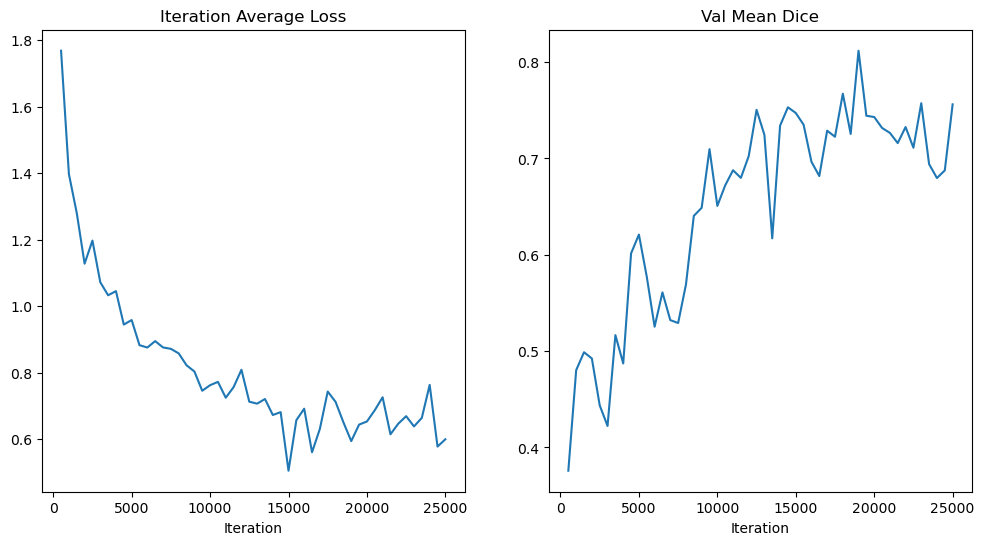

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.06it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

/home/user/anaconda3/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_unmulticoncat_onwordfintuneonmiccai_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_unmulticoncat_onmiccai_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.59179): 100%|█| 24/24 [00:17<00:00,  1.40it/
Training (47 / 25000 Steps) (loss=2.35652): 100%|█| 24/24 [00:06<00:00,  3.60it/
Training (71 / 25000 Steps) (loss=2.18165): 100%|█| 24/24 [00:06<00:00,  3.61it/
Training (95 / 25000 Steps) (loss=2.17836): 100%|█| 24/24 [00:06<00:00,  3.58it/
Training (119 / 25000 Steps) (loss=2.19858): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (143 / 25000 Steps) (loss=2.12637): 100%|█| 24/24 [00:06<00:00,  3.52it
Training (167 / 25000 Steps) (loss=2.07728): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (191 / 25000 Steps) (loss=2.11373): 100%|█| 24/24 [00:06<00:00,  3.58it
Training (215 / 25000 Steps) (loss=2.04903): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (239 / 25000 Steps) (loss=1.90933): 100%|█| 24/24 [00:06<00:00,  3.57it
Training (263 / 25000 Steps) (loss=1.99888): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (287 / 25000 Steps) (loss=1.90253): 100%|█| 24/24 [00:06<00:00,  3.53it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.43835365772247314 Current Avg. Dice: 0.43835365772247314


Training (503 / 25000 Steps) (loss=1.70106): 100%|█| 24/24 [00:08<00:00,  2.94it
Training (527 / 25000 Steps) (loss=1.57664): 100%|█| 24/24 [00:06<00:00,  3.58it
Training (551 / 25000 Steps) (loss=1.65957): 100%|█| 24/24 [00:06<00:00,  3.59it
Training (575 / 25000 Steps) (loss=1.57234): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (599 / 25000 Steps) (loss=1.54803): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (623 / 25000 Steps) (loss=1.66074): 100%|█| 24/24 [00:06<00:00,  3.52it
Training (647 / 25000 Steps) (loss=1.56942): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (671 / 25000 Steps) (loss=1.49574): 100%|█| 24/24 [00:06<00:00,  3.58it
Training (695 / 25000 Steps) (loss=1.49244): 100%|█| 24/24 [00:06<00:00,  3.59it
Training (719 / 25000 Steps) (loss=1.65544): 100%|█| 24/24 [00:06<00:00,  3.52it
Training (743 / 25000 Steps) (loss=1.52513): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (767 / 25000 Steps) (loss=1.47991): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.43835365772247314 Current Avg. Dice: 0.39679622650146484


Training (1007 / 25000 Steps) (loss=1.33303): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (1031 / 25000 Steps) (loss=1.42956): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1055 / 25000 Steps) (loss=1.49944): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1079 / 25000 Steps) (loss=1.37361): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1103 / 25000 Steps) (loss=1.38278): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1127 / 25000 Steps) (loss=1.39044): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1151 / 25000 Steps) (loss=1.34633): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (1175 / 25000 Steps) (loss=1.46211): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (1199 / 25000 Steps) (loss=1.33242): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1223 / 25000 Steps) (loss=1.27081): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1247 / 25000 Steps) (loss=1.38657): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (1271 / 25000 Steps) (loss=1.31857): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.43835365772247314 Current Avg. Dice: 0.39837053418159485


Training (1511 / 25000 Steps) (loss=1.17984): 100%|█| 24/24 [00:07<00:00,  3.07i
Training (1535 / 25000 Steps) (loss=1.26357): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1559 / 25000 Steps) (loss=1.11078): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (1583 / 25000 Steps) (loss=1.17526): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (1607 / 25000 Steps) (loss=1.20031): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1631 / 25000 Steps) (loss=1.04373): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (1655 / 25000 Steps) (loss=1.22381): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1679 / 25000 Steps) (loss=1.23259): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (1703 / 25000 Steps) (loss=1.08011): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1727 / 25000 Steps) (loss=1.26878): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (1751 / 25000 Steps) (loss=1.10961): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (1775 / 25000 Steps) (loss=1.07125): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.44741931557655334 Current Avg. Dice: 0.44741931557655334


Training (2015 / 25000 Steps) (loss=1.05802): 100%|█| 24/24 [00:07<00:00,  3.02i
Training (2039 / 25000 Steps) (loss=1.30289): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (2063 / 25000 Steps) (loss=1.11985): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (2087 / 25000 Steps) (loss=1.07762): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (2111 / 25000 Steps) (loss=1.02649): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2135 / 25000 Steps) (loss=1.02783): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (2159 / 25000 Steps) (loss=1.13178): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (2183 / 25000 Steps) (loss=1.07889): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (2207 / 25000 Steps) (loss=1.39613): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2231 / 25000 Steps) (loss=1.10942): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2255 / 25000 Steps) (loss=1.01765): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (2279 / 25000 Steps) (loss=1.20957): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.473076730966568 Current Avg. Dice: 0.473076730966568


Training (2519 / 25000 Steps) (loss=1.07827): 100%|█| 24/24 [00:07<00:00,  3.04i
Training (2543 / 25000 Steps) (loss=1.10250): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (2567 / 25000 Steps) (loss=0.97091): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (2591 / 25000 Steps) (loss=1.08118): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (2615 / 25000 Steps) (loss=0.92155): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2639 / 25000 Steps) (loss=1.07295): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2663 / 25000 Steps) (loss=1.03782): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (2687 / 25000 Steps) (loss=1.05806): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2711 / 25000 Steps) (loss=0.99696): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (2735 / 25000 Steps) (loss=0.95274): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (2759 / 25000 Steps) (loss=0.98884): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (2783 / 25000 Steps) (loss=1.12231): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.487600713968277 Current Avg. Dice: 0.487600713968277


Training (3023 / 25000 Steps) (loss=1.12024): 100%|█| 24/24 [00:07<00:00,  3.06i
Training (3047 / 25000 Steps) (loss=1.28223): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (3071 / 25000 Steps) (loss=1.09044): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3095 / 25000 Steps) (loss=1.11806): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (3119 / 25000 Steps) (loss=0.99250): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (3143 / 25000 Steps) (loss=0.95598): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (3167 / 25000 Steps) (loss=0.93845): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3191 / 25000 Steps) (loss=1.03414): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (3215 / 25000 Steps) (loss=1.00452): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (3239 / 25000 Steps) (loss=0.92632): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (3263 / 25000 Steps) (loss=0.95588): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (3287 / 25000 Steps) (loss=1.07470): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5203744173049927 Current Avg. Dice: 0.5203744173049927


Training (3503 / 25000 Steps) (loss=1.07722): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (3527 / 25000 Steps) (loss=1.14849): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3551 / 25000 Steps) (loss=0.97864): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3575 / 25000 Steps) (loss=0.92244): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3599 / 25000 Steps) (loss=1.16048): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3623 / 25000 Steps) (loss=0.95622): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3647 / 25000 Steps) (loss=0.92017): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3671 / 25000 Steps) (loss=0.91747): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3695 / 25000 Steps) (loss=0.87694): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (3719 / 25000 Steps) (loss=0.92633): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (3743 / 25000 Steps) (loss=0.93928): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (3767 / 25000 Steps) (loss=0.93889): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5203744173049927 Current Avg. Dice: 0.4238658845424652


Training (4007 / 25000 Steps) (loss=0.88606): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (4031 / 25000 Steps) (loss=0.86520): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4055 / 25000 Steps) (loss=0.89994): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4079 / 25000 Steps) (loss=0.90451): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4103 / 25000 Steps) (loss=1.03980): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4127 / 25000 Steps) (loss=0.83243): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4151 / 25000 Steps) (loss=0.83070): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4175 / 25000 Steps) (loss=0.94159): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4199 / 25000 Steps) (loss=0.87703): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4223 / 25000 Steps) (loss=0.82886): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4247 / 25000 Steps) (loss=0.84200): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4271 / 25000 Steps) (loss=1.05898): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.535315215587616 Current Avg. Dice: 0.535315215587616


Training (4511 / 25000 Steps) (loss=0.84747): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (4535 / 25000 Steps) (loss=0.93006): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4559 / 25000 Steps) (loss=0.78333): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4583 / 25000 Steps) (loss=0.79312): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4607 / 25000 Steps) (loss=0.94055): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4631 / 25000 Steps) (loss=0.96106): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4655 / 25000 Steps) (loss=0.79944): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (4679 / 25000 Steps) (loss=0.90888): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (4703 / 25000 Steps) (loss=0.97366): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (4727 / 25000 Steps) (loss=0.83482): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4751 / 25000 Steps) (loss=0.88994): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4775 / 25000 Steps) (loss=0.91892): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5797942280769348 Current Avg. Dice: 0.5797942280769348


Training (5015 / 25000 Steps) (loss=0.93535): 100%|█| 24/24 [00:07<00:00,  3.11i
Training (5039 / 25000 Steps) (loss=0.88324): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5063 / 25000 Steps) (loss=0.88301): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5087 / 25000 Steps) (loss=0.91902): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5111 / 25000 Steps) (loss=0.89977): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5135 / 25000 Steps) (loss=0.87737): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5159 / 25000 Steps) (loss=0.97434): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5183 / 25000 Steps) (loss=0.92362): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5207 / 25000 Steps) (loss=0.90701): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5231 / 25000 Steps) (loss=0.97424): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5255 / 25000 Steps) (loss=0.94974): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5279 / 25000 Steps) (loss=0.79268): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5905762910842896 Current Avg. Dice: 0.5905762910842896


Training (5519 / 25000 Steps) (loss=0.82323): 100%|█| 24/24 [00:07<00:00,  3.12i
Training (5543 / 25000 Steps) (loss=0.94271): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5567 / 25000 Steps) (loss=0.80873): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5591 / 25000 Steps) (loss=0.77813): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5615 / 25000 Steps) (loss=0.84624): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5639 / 25000 Steps) (loss=0.97779): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (5663 / 25000 Steps) (loss=0.80408): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5687 / 25000 Steps) (loss=0.69770): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (5711 / 25000 Steps) (loss=0.76965): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5735 / 25000 Steps) (loss=0.91727): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5759 / 25000 Steps) (loss=0.65087): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (5783 / 25000 Steps) (loss=0.88674): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6551180481910706 Current Avg. Dice: 0.6551180481910706


Training (6023 / 25000 Steps) (loss=0.85992): 100%|█| 24/24 [00:07<00:00,  3.09i
Training (6047 / 25000 Steps) (loss=0.88019): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6071 / 25000 Steps) (loss=0.93672): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6095 / 25000 Steps) (loss=0.73207): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6119 / 25000 Steps) (loss=0.81288): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (6143 / 25000 Steps) (loss=0.78806): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6167 / 25000 Steps) (loss=0.78129): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6191 / 25000 Steps) (loss=0.73776): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6215 / 25000 Steps) (loss=0.76512): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6239 / 25000 Steps) (loss=0.73935): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6263 / 25000 Steps) (loss=0.83615): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6287 / 25000 Steps) (loss=0.84952): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6655405163764954 Current Avg. Dice: 0.6655405163764954


Training (6503 / 25000 Steps) (loss=0.77780): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (6527 / 25000 Steps) (loss=0.67750): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6551 / 25000 Steps) (loss=0.88385): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6575 / 25000 Steps) (loss=0.78543): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6599 / 25000 Steps) (loss=0.69162): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6623 / 25000 Steps) (loss=0.69103): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6647 / 25000 Steps) (loss=0.72567): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6671 / 25000 Steps) (loss=0.77780): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6695 / 25000 Steps) (loss=0.75424): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (6719 / 25000 Steps) (loss=0.88902): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6743 / 25000 Steps) (loss=0.68666): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6767 / 25000 Steps) (loss=0.69644): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6655405163764954 Current Avg. Dice: 0.6034840941429138


Training (7007 / 25000 Steps) (loss=0.81843): 100%|█| 24/24 [00:07<00:00,  3.15i
Training (7031 / 25000 Steps) (loss=0.86932): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7055 / 25000 Steps) (loss=0.78406): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7079 / 25000 Steps) (loss=0.76929): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7103 / 25000 Steps) (loss=0.81940): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7127 / 25000 Steps) (loss=0.66360): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7151 / 25000 Steps) (loss=0.72088): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7175 / 25000 Steps) (loss=0.84240): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (7199 / 25000 Steps) (loss=0.60758): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7223 / 25000 Steps) (loss=0.82511): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7247 / 25000 Steps) (loss=0.81691): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7271 / 25000 Steps) (loss=0.85621): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6655405163764954 Current Avg. Dice: 0.6183176636695862


Training (7511 / 25000 Steps) (loss=0.69984): 100%|█| 24/24 [00:07<00:00,  3.15i
Training (7535 / 25000 Steps) (loss=0.85574): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7559 / 25000 Steps) (loss=0.65953): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7583 / 25000 Steps) (loss=0.89350): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7607 / 25000 Steps) (loss=0.69956): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7631 / 25000 Steps) (loss=0.59666): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7655 / 25000 Steps) (loss=0.65678): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (7679 / 25000 Steps) (loss=0.65928): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7703 / 25000 Steps) (loss=0.76110): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7727 / 25000 Steps) (loss=0.56751): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7751 / 25000 Steps) (loss=0.84602): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7775 / 25000 Steps) (loss=0.54081): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6655405163764954 Current Avg. Dice: 0.6596832275390625


Training (8015 / 25000 Steps) (loss=0.75936): 100%|█| 24/24 [00:07<00:00,  3.16i
Training (8039 / 25000 Steps) (loss=0.83273): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8063 / 25000 Steps) (loss=0.83460): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (8087 / 25000 Steps) (loss=0.68199): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8111 / 25000 Steps) (loss=0.72854): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8135 / 25000 Steps) (loss=0.83854): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (8159 / 25000 Steps) (loss=0.88167): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8183 / 25000 Steps) (loss=0.66800): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8207 / 25000 Steps) (loss=0.75989): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8231 / 25000 Steps) (loss=0.61959): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (8255 / 25000 Steps) (loss=0.83727): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8279 / 25000 Steps) (loss=0.64966): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6655405163764954 Current Avg. Dice: 0.6422744393348694


Training (8519 / 25000 Steps) (loss=0.79309): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (8543 / 25000 Steps) (loss=0.74486): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8567 / 25000 Steps) (loss=0.69330): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8591 / 25000 Steps) (loss=0.76608): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8615 / 25000 Steps) (loss=0.69572): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8639 / 25000 Steps) (loss=0.68862): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8663 / 25000 Steps) (loss=0.66132): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (8687 / 25000 Steps) (loss=0.79359): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (8711 / 25000 Steps) (loss=0.68457): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8735 / 25000 Steps) (loss=0.58432): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8759 / 25000 Steps) (loss=0.77796): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (8783 / 25000 Steps) (loss=0.73949): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6655405163764954 Current Avg. Dice: 0.6328083872795105


Training (9023 / 25000 Steps) (loss=0.77315): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (9047 / 25000 Steps) (loss=0.74830): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9071 / 25000 Steps) (loss=0.70474): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9095 / 25000 Steps) (loss=0.75811): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9119 / 25000 Steps) (loss=0.70328): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9143 / 25000 Steps) (loss=0.59517): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9167 / 25000 Steps) (loss=0.61676): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9191 / 25000 Steps) (loss=0.72550): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9215 / 25000 Steps) (loss=0.62452): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9239 / 25000 Steps) (loss=0.67645): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9263 / 25000 Steps) (loss=0.82084): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9287 / 25000 Steps) (loss=0.76666): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6698209643363953 Current Avg. Dice: 0.6698209643363953


Training (9503 / 25000 Steps) (loss=0.66873): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (9527 / 25000 Steps) (loss=0.81582): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9551 / 25000 Steps) (loss=0.62529): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9575 / 25000 Steps) (loss=0.70749): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9599 / 25000 Steps) (loss=0.84134): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9623 / 25000 Steps) (loss=0.72970): 100%|█| 24/24 [00:06<00:00,  3.62i
Training (9647 / 25000 Steps) (loss=0.69272): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9671 / 25000 Steps) (loss=0.75978): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9695 / 25000 Steps) (loss=0.76596): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9719 / 25000 Steps) (loss=0.55090): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (9743 / 25000 Steps) (loss=0.70624): 100%|█| 24/24 [00:06<00:00,  3.61i
Training (9767 / 25000 Steps) (loss=0.80309): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.7176625728607178


Training (10007 / 25000 Steps) (loss=0.67301): 100%|█| 24/24 [00:07<00:00,  3.09
Training (10031 / 25000 Steps) (loss=0.81071): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10055 / 25000 Steps) (loss=0.67854): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10079 / 25000 Steps) (loss=0.76438): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10103 / 25000 Steps) (loss=0.48721): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10127 / 25000 Steps) (loss=0.70958): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10151 / 25000 Steps) (loss=0.66300): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10175 / 25000 Steps) (loss=0.63950): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10199 / 25000 Steps) (loss=0.60221): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10223 / 25000 Steps) (loss=0.57738): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10247 / 25000 Steps) (loss=0.84197): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10271 / 25000 Steps) (loss=0.72398): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.6578516960144043


Training (10511 / 25000 Steps) (loss=0.61851): 100%|█| 24/24 [00:07<00:00,  3.17
Training (10535 / 25000 Steps) (loss=0.46299): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10559 / 25000 Steps) (loss=0.75076): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10583 / 25000 Steps) (loss=0.45711): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10607 / 25000 Steps) (loss=0.68767): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10631 / 25000 Steps) (loss=0.60711): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10655 / 25000 Steps) (loss=0.69049): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10679 / 25000 Steps) (loss=0.68551): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10703 / 25000 Steps) (loss=0.77155): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10727 / 25000 Steps) (loss=0.67766): 100%|█| 24/24 [00:06<00:00,  3.62
Training (10751 / 25000 Steps) (loss=0.77359): 100%|█| 24/24 [00:06<00:00,  3.61
Training (10775 / 25000 Steps) (loss=0.82240): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.687654435634613


Training (11015 / 25000 Steps) (loss=0.77813): 100%|█| 24/24 [00:07<00:00,  3.17
Training (11039 / 25000 Steps) (loss=0.67771): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11063 / 25000 Steps) (loss=0.57602): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11087 / 25000 Steps) (loss=0.62109): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11111 / 25000 Steps) (loss=0.75283): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11135 / 25000 Steps) (loss=0.77046): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11159 / 25000 Steps) (loss=0.82226): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11183 / 25000 Steps) (loss=0.81644): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11207 / 25000 Steps) (loss=0.64210): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11231 / 25000 Steps) (loss=0.60232): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11255 / 25000 Steps) (loss=0.68170): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11279 / 25000 Steps) (loss=0.70385): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.6464924216270447


Training (11519 / 25000 Steps) (loss=0.67426): 100%|█| 24/24 [00:07<00:00,  3.18
Training (11543 / 25000 Steps) (loss=0.71306): 100%|█| 24/24 [00:06<00:00,  3.57
Training (11567 / 25000 Steps) (loss=0.71510): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11591 / 25000 Steps) (loss=0.64680): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11615 / 25000 Steps) (loss=0.54840): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11639 / 25000 Steps) (loss=0.65502): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11663 / 25000 Steps) (loss=0.72566): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11687 / 25000 Steps) (loss=0.71461): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11711 / 25000 Steps) (loss=0.71751): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11735 / 25000 Steps) (loss=0.58670): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11759 / 25000 Steps) (loss=0.63810): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11783 / 25000 Steps) (loss=0.65432): 100%|█| 24/24 [00:06<00:00,  3.61
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.6266420483589172


Training (12023 / 25000 Steps) (loss=1.15505): 100%|█| 24/24 [00:07<00:00,  3.17
Training (12047 / 25000 Steps) (loss=0.70532): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12071 / 25000 Steps) (loss=0.64875): 100%|█| 24/24 [00:06<00:00,  3.61
Training (12095 / 25000 Steps) (loss=0.68808): 100%|█| 24/24 [00:06<00:00,  3.62
Training (12119 / 25000 Steps) (loss=0.58182): 100%|█| 24/24 [00:06<00:00,  3.61
Training (12143 / 25000 Steps) (loss=0.69649): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12167 / 25000 Steps) (loss=0.65298): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12191 / 25000 Steps) (loss=0.76214): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12215 / 25000 Steps) (loss=0.81462): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12239 / 25000 Steps) (loss=0.74079): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12263 / 25000 Steps) (loss=0.56320): 100%|█| 24/24 [00:06<00:00,  3.57
Training (12287 / 25000 Steps) (loss=0.64935): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.7013471722602844


Training (12503 / 25000 Steps) (loss=0.57852): 100%|█| 24/24 [00:07<00:00,  3.17
Training (12527 / 25000 Steps) (loss=0.71307): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12551 / 25000 Steps) (loss=0.56909): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12575 / 25000 Steps) (loss=0.68241): 100%|█| 24/24 [00:06<00:00,  3.61
Training (12599 / 25000 Steps) (loss=0.75175): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12623 / 25000 Steps) (loss=0.73736): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12647 / 25000 Steps) (loss=0.71596): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12671 / 25000 Steps) (loss=0.63137): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12695 / 25000 Steps) (loss=0.74085): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12719 / 25000 Steps) (loss=0.57127): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12743 / 25000 Steps) (loss=0.65919): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12767 / 25000 Steps) (loss=0.64206): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.6381250023841858


Training (13007 / 25000 Steps) (loss=0.52228): 100%|█| 24/24 [00:07<00:00,  3.16
Training (13031 / 25000 Steps) (loss=0.83355): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13055 / 25000 Steps) (loss=0.87947): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13079 / 25000 Steps) (loss=0.51964): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13103 / 25000 Steps) (loss=0.64034): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13127 / 25000 Steps) (loss=0.80039): 100%|█| 24/24 [00:06<00:00,  3.61
Training (13151 / 25000 Steps) (loss=0.56356): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13175 / 25000 Steps) (loss=0.68447): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13199 / 25000 Steps) (loss=0.69652): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13223 / 25000 Steps) (loss=0.71638): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13247 / 25000 Steps) (loss=0.71695): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13271 / 25000 Steps) (loss=0.75364): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.6904918551445007


Training (13511 / 25000 Steps) (loss=0.62394): 100%|█| 24/24 [00:07<00:00,  3.17
Training (13535 / 25000 Steps) (loss=0.75932): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13559 / 25000 Steps) (loss=0.78918): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13583 / 25000 Steps) (loss=0.74282): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13607 / 25000 Steps) (loss=0.71993): 100%|█| 24/24 [00:06<00:00,  3.61
Training (13631 / 25000 Steps) (loss=0.73342): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13655 / 25000 Steps) (loss=0.76574): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13679 / 25000 Steps) (loss=0.68692): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13703 / 25000 Steps) (loss=0.47614): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13727 / 25000 Steps) (loss=0.70895): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13751 / 25000 Steps) (loss=0.81920): 100%|█| 24/24 [00:06<00:00,  3.61
Training (13775 / 25000 Steps) (loss=0.61701): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.6911810040473938


Training (14015 / 25000 Steps) (loss=0.75901): 100%|█| 24/24 [00:07<00:00,  3.18
Training (14039 / 25000 Steps) (loss=0.62933): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14063 / 25000 Steps) (loss=0.62285): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14087 / 25000 Steps) (loss=0.48225): 100%|█| 24/24 [00:06<00:00,  3.56
Training (14111 / 25000 Steps) (loss=0.67741): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14135 / 25000 Steps) (loss=0.71782): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14159 / 25000 Steps) (loss=0.65536): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14183 / 25000 Steps) (loss=0.62723): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14207 / 25000 Steps) (loss=0.71817): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14231 / 25000 Steps) (loss=0.68070): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14255 / 25000 Steps) (loss=0.71782): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14279 / 25000 Steps) (loss=0.55356): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.6954560279846191


Training (14519 / 25000 Steps) (loss=0.58611): 100%|█| 24/24 [00:07<00:00,  3.16
Training (14543 / 25000 Steps) (loss=0.65448): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14567 / 25000 Steps) (loss=0.56673): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14591 / 25000 Steps) (loss=0.70885): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14615 / 25000 Steps) (loss=0.63491): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14639 / 25000 Steps) (loss=0.65945): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14663 / 25000 Steps) (loss=0.53573): 100%|█| 24/24 [00:06<00:00,  3.61
Training (14687 / 25000 Steps) (loss=0.98509): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14711 / 25000 Steps) (loss=0.55666): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14735 / 25000 Steps) (loss=0.51704): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14759 / 25000 Steps) (loss=0.60621): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14783 / 25000 Steps) (loss=0.68165): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.6073789000511169


Training (15023 / 25000 Steps) (loss=0.39748): 100%|█| 24/24 [00:07<00:00,  3.15
Training (15047 / 25000 Steps) (loss=0.64039): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15071 / 25000 Steps) (loss=0.79899): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15095 / 25000 Steps) (loss=0.64769): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15119 / 25000 Steps) (loss=0.53752): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15143 / 25000 Steps) (loss=0.48728): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15167 / 25000 Steps) (loss=0.64348): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15191 / 25000 Steps) (loss=0.66067): 100%|█| 24/24 [00:06<00:00,  3.55
Training (15215 / 25000 Steps) (loss=0.66272): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15239 / 25000 Steps) (loss=0.56341): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15263 / 25000 Steps) (loss=0.60966): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15287 / 25000 Steps) (loss=0.71936): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.6847537159919739


Training (15503 / 25000 Steps) (loss=0.69688): 100%|█| 24/24 [00:07<00:00,  3.12
Training (15527 / 25000 Steps) (loss=0.73593): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15551 / 25000 Steps) (loss=0.46588): 100%|█| 24/24 [00:06<00:00,  3.51
Training (15575 / 25000 Steps) (loss=0.60415): 100%|█| 24/24 [00:06<00:00,  3.50
Training (15599 / 25000 Steps) (loss=0.63001): 100%|█| 24/24 [00:06<00:00,  3.56
Training (15623 / 25000 Steps) (loss=0.62823): 100%|█| 24/24 [00:06<00:00,  3.56
Training (15647 / 25000 Steps) (loss=0.63609): 100%|█| 24/24 [00:06<00:00,  3.51
Training (15671 / 25000 Steps) (loss=0.46438): 100%|█| 24/24 [00:06<00:00,  3.49
Training (15695 / 25000 Steps) (loss=0.46462): 100%|█| 24/24 [00:06<00:00,  3.56
Training (15719 / 25000 Steps) (loss=0.65887): 100%|█| 24/24 [00:06<00:00,  3.55
Training (15743 / 25000 Steps) (loss=0.65622): 100%|█| 24/24 [00:06<00:00,  3.52
Training (15767 / 25000 Steps) (loss=0.62482): 100%|█| 24/24 [00:06<00:00,  3.52
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7176625728607178 Current Avg. Dice: 0.696167528629303


Training (16007 / 25000 Steps) (loss=0.64284): 100%|█| 24/24 [00:07<00:00,  3.06
Training (16031 / 25000 Steps) (loss=0.77291): 100%|█| 24/24 [00:06<00:00,  3.55
Training (16055 / 25000 Steps) (loss=0.45044): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16079 / 25000 Steps) (loss=0.70744): 100%|█| 24/24 [00:06<00:00,  3.54
Training (16103 / 25000 Steps) (loss=0.69762): 100%|█| 24/24 [00:06<00:00,  3.48
Training (16127 / 25000 Steps) (loss=0.42356): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16151 / 25000 Steps) (loss=0.58826): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16175 / 25000 Steps) (loss=0.64426): 100%|█| 24/24 [00:06<00:00,  3.51
Training (16199 / 25000 Steps) (loss=0.63436): 100%|█| 24/24 [00:06<00:00,  3.50
Training (16223 / 25000 Steps) (loss=0.50774): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16247 / 25000 Steps) (loss=0.79571): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16271 / 25000 Steps) (loss=0.54288): 100%|█| 24/24 [00:06<00:00,  3.55
Training (16295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7361932396888733 Current Avg. Dice: 0.7361932396888733


Training (16511 / 25000 Steps) (loss=0.75759): 100%|█| 24/24 [00:08<00:00,  2.97
Training (16535 / 25000 Steps) (loss=0.73386): 100%|█| 24/24 [00:06<00:00,  3.55
Training (16559 / 25000 Steps) (loss=0.71891): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16583 / 25000 Steps) (loss=0.83507): 100%|█| 24/24 [00:06<00:00,  3.53
Training (16607 / 25000 Steps) (loss=0.51889): 100%|█| 24/24 [00:06<00:00,  3.51
Training (16631 / 25000 Steps) (loss=0.66368): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16655 / 25000 Steps) (loss=0.58807): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16679 / 25000 Steps) (loss=0.43668): 100%|█| 24/24 [00:06<00:00,  3.54
Training (16703 / 25000 Steps) (loss=0.73992): 100%|█| 24/24 [00:06<00:00,  3.52
Training (16727 / 25000 Steps) (loss=0.43112): 100%|█| 24/24 [00:06<00:00,  3.54
Training (16751 / 25000 Steps) (loss=0.63609): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16775 / 25000 Steps) (loss=0.85578): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7361932396888733 Current Avg. Dice: 0.707080602645874


Training (17015 / 25000 Steps) (loss=0.61279): 100%|█| 24/24 [00:07<00:00,  3.06
Training (17039 / 25000 Steps) (loss=0.69979): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17063 / 25000 Steps) (loss=0.34450): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17087 / 25000 Steps) (loss=0.38261): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17111 / 25000 Steps) (loss=0.51268): 100%|█| 24/24 [00:06<00:00,  3.54
Training (17135 / 25000 Steps) (loss=0.57762): 100%|█| 24/24 [00:06<00:00,  3.52
Training (17159 / 25000 Steps) (loss=0.49314): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17183 / 25000 Steps) (loss=0.66940): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17207 / 25000 Steps) (loss=0.65225): 100%|█| 24/24 [00:06<00:00,  3.54
Training (17231 / 25000 Steps) (loss=0.74985): 100%|█| 24/24 [00:06<00:00,  3.51
Training (17255 / 25000 Steps) (loss=0.60703): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17279 / 25000 Steps) (loss=0.71854): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7361932396888733 Current Avg. Dice: 0.655470073223114


Training (17519 / 25000 Steps) (loss=0.51772): 100%|█| 24/24 [00:07<00:00,  3.11
Training (17543 / 25000 Steps) (loss=0.54113): 100%|█| 24/24 [00:06<00:00,  3.54
Training (17567 / 25000 Steps) (loss=0.73056): 100%|█| 24/24 [00:06<00:00,  3.50
Training (17591 / 25000 Steps) (loss=0.58334): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17615 / 25000 Steps) (loss=0.74614): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17639 / 25000 Steps) (loss=0.64483): 100%|█| 24/24 [00:06<00:00,  3.55
Training (17663 / 25000 Steps) (loss=0.59244): 100%|█| 24/24 [00:06<00:00,  3.52
Training (17687 / 25000 Steps) (loss=0.54724): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17711 / 25000 Steps) (loss=0.56448): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17735 / 25000 Steps) (loss=0.48017): 100%|█| 24/24 [00:06<00:00,  3.55
Training (17759 / 25000 Steps) (loss=0.58000): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17783 / 25000 Steps) (loss=0.78496): 100%|█| 24/24 [00:06<00:00,  3.51
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7361932396888733 Current Avg. Dice: 0.668957531452179


Training (18023 / 25000 Steps) (loss=0.76329): 100%|█| 24/24 [00:07<00:00,  3.05
Training (18047 / 25000 Steps) (loss=0.42677): 100%|█| 24/24 [00:06<00:00,  3.56
Training (18071 / 25000 Steps) (loss=0.63143): 100%|█| 24/24 [00:06<00:00,  3.56
Training (18095 / 25000 Steps) (loss=0.59992): 100%|█| 24/24 [00:06<00:00,  3.54
Training (18119 / 25000 Steps) (loss=0.54671): 100%|█| 24/24 [00:06<00:00,  3.54
Training (18143 / 25000 Steps) (loss=0.39773): 100%|█| 24/24 [00:06<00:00,  3.51
Training (18167 / 25000 Steps) (loss=0.70252): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18191 / 25000 Steps) (loss=0.70544): 100%|█| 24/24 [00:06<00:00,  3.55
Training (18215 / 25000 Steps) (loss=0.79690): 100%|█| 24/24 [00:06<00:00,  3.55
Training (18239 / 25000 Steps) (loss=0.67066): 100%|█| 24/24 [00:06<00:00,  3.53
Training (18263 / 25000 Steps) (loss=0.51273): 100%|█| 24/24 [00:06<00:00,  3.49
Training (18287 / 25000 Steps) (loss=0.50592): 100%|█| 24/24 [00:06<00:00,  3.56
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7361932396888733 Current Avg. Dice: 0.7003392577171326


Training (18503 / 25000 Steps) (loss=0.65481): 100%|█| 24/24 [00:07<00:00,  3.14
Training (18527 / 25000 Steps) (loss=0.53403): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18551 / 25000 Steps) (loss=0.76860): 100%|█| 24/24 [00:06<00:00,  3.54
Training (18575 / 25000 Steps) (loss=0.77658): 100%|█| 24/24 [00:07<00:00,  3.43
Training (18599 / 25000 Steps) (loss=0.82719): 100%|█| 24/24 [00:06<00:00,  3.55
Training (18623 / 25000 Steps) (loss=0.47453): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18647 / 25000 Steps) (loss=0.64332): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18671 / 25000 Steps) (loss=0.78178): 100%|█| 24/24 [00:06<00:00,  3.62
Training (18695 / 25000 Steps) (loss=0.49591): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18719 / 25000 Steps) (loss=0.73511): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18743 / 25000 Steps) (loss=0.76361): 100%|█| 24/24 [00:06<00:00,  3.61
Training (18767 / 25000 Steps) (loss=0.72692): 100%|█| 24/24 [00:06<00:00,  3.60
Training (18791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.754381000995636


Training (19007 / 25000 Steps) (loss=0.60986): 100%|█| 24/24 [00:07<00:00,  3.10
Training (19031 / 25000 Steps) (loss=0.68434): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19055 / 25000 Steps) (loss=0.56129): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19079 / 25000 Steps) (loss=0.64372): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19103 / 25000 Steps) (loss=0.60049): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19127 / 25000 Steps) (loss=0.60172): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19151 / 25000 Steps) (loss=0.46875): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19175 / 25000 Steps) (loss=0.56606): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19199 / 25000 Steps) (loss=0.53240): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19223 / 25000 Steps) (loss=0.70578): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19247 / 25000 Steps) (loss=0.60983): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19271 / 25000 Steps) (loss=0.65550): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.6797649264335632


Training (19511 / 25000 Steps) (loss=0.66043): 100%|█| 24/24 [00:07<00:00,  3.17
Training (19535 / 25000 Steps) (loss=0.61304): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19559 / 25000 Steps) (loss=0.58265): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19583 / 25000 Steps) (loss=0.50929): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19607 / 25000 Steps) (loss=0.93303): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19631 / 25000 Steps) (loss=0.74577): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19655 / 25000 Steps) (loss=0.64700): 100%|█| 24/24 [00:06<00:00,  3.61
Training (19679 / 25000 Steps) (loss=0.68088): 100%|█| 24/24 [00:06<00:00,  3.61
Training (19703 / 25000 Steps) (loss=0.47358): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19727 / 25000 Steps) (loss=0.57748): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19751 / 25000 Steps) (loss=0.69037): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19775 / 25000 Steps) (loss=0.49655): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.6115959882736206


Training (20015 / 25000 Steps) (loss=0.60340): 100%|█| 24/24 [00:07<00:00,  3.16
Training (20039 / 25000 Steps) (loss=0.47507): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20063 / 25000 Steps) (loss=0.65721): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20087 / 25000 Steps) (loss=0.51938): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20111 / 25000 Steps) (loss=0.61131): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20135 / 25000 Steps) (loss=0.53541): 100%|█| 24/24 [00:06<00:00,  3.56
Training (20159 / 25000 Steps) (loss=0.58928): 100%|█| 24/24 [00:06<00:00,  3.61
Training (20183 / 25000 Steps) (loss=0.72146): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20207 / 25000 Steps) (loss=0.63726): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20231 / 25000 Steps) (loss=0.66004): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20255 / 25000 Steps) (loss=0.69385): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20279 / 25000 Steps) (loss=0.66250): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.715858519077301


Training (20519 / 25000 Steps) (loss=0.82165): 100%|█| 24/24 [00:07<00:00,  3.16
Training (20543 / 25000 Steps) (loss=0.66980): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20567 / 25000 Steps) (loss=0.52710): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20591 / 25000 Steps) (loss=0.54319): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20615 / 25000 Steps) (loss=0.55075): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20639 / 25000 Steps) (loss=0.63184): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20663 / 25000 Steps) (loss=0.71198): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20687 / 25000 Steps) (loss=0.63532): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20711 / 25000 Steps) (loss=0.72554): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20735 / 25000 Steps) (loss=0.69713): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20759 / 25000 Steps) (loss=0.66669): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20783 / 25000 Steps) (loss=0.74493): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.6831480860710144


Training (21023 / 25000 Steps) (loss=0.53678): 100%|█| 24/24 [00:07<00:00,  3.16
Training (21047 / 25000 Steps) (loss=0.69063): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21071 / 25000 Steps) (loss=0.57663): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21095 / 25000 Steps) (loss=0.54672): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21119 / 25000 Steps) (loss=0.52772): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21143 / 25000 Steps) (loss=0.69088): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21167 / 25000 Steps) (loss=0.53477): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21191 / 25000 Steps) (loss=0.69261): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21215 / 25000 Steps) (loss=0.61251): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21239 / 25000 Steps) (loss=0.72428): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21263 / 25000 Steps) (loss=0.67761): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21287 / 25000 Steps) (loss=0.45626): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.7078943252563477


Training (21503 / 25000 Steps) (loss=0.54913): 100%|█| 24/24 [00:07<00:00,  3.18
Training (21527 / 25000 Steps) (loss=0.70952): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21551 / 25000 Steps) (loss=0.54028): 100%|█| 24/24 [00:06<00:00,  3.61
Training (21575 / 25000 Steps) (loss=0.60343): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21599 / 25000 Steps) (loss=0.41538): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21623 / 25000 Steps) (loss=0.49679): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21647 / 25000 Steps) (loss=0.76544): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21671 / 25000 Steps) (loss=0.60630): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21695 / 25000 Steps) (loss=0.83711): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21719 / 25000 Steps) (loss=0.69090): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21743 / 25000 Steps) (loss=0.78465): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21767 / 25000 Steps) (loss=0.69344): 100%|█| 24/24 [00:06<00:00,  3.61
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.6983806490898132


Training (22007 / 25000 Steps) (loss=0.43845): 100%|█| 24/24 [00:07<00:00,  3.14
Training (22031 / 25000 Steps) (loss=0.57202): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22055 / 25000 Steps) (loss=0.70722): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22079 / 25000 Steps) (loss=0.49625): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22103 / 25000 Steps) (loss=0.72406): 100%|█| 24/24 [00:06<00:00,  3.56
Training (22127 / 25000 Steps) (loss=0.52102): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22151 / 25000 Steps) (loss=0.57417): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22175 / 25000 Steps) (loss=0.62249): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22199 / 25000 Steps) (loss=0.65809): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22223 / 25000 Steps) (loss=0.43332): 100%|█| 24/24 [00:06<00:00,  3.61
Training (22247 / 25000 Steps) (loss=0.44861): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22271 / 25000 Steps) (loss=0.58303): 100%|█| 24/24 [00:06<00:00,  3.61
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.6840125918388367


Training (22511 / 25000 Steps) (loss=0.79955): 100%|█| 24/24 [00:07<00:00,  3.17
Training (22535 / 25000 Steps) (loss=0.45085): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22559 / 25000 Steps) (loss=0.63188): 100%|█| 24/24 [00:06<00:00,  3.61
Training (22583 / 25000 Steps) (loss=0.61198): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22607 / 25000 Steps) (loss=0.65903): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22631 / 25000 Steps) (loss=0.55344): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22655 / 25000 Steps) (loss=0.69730): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22679 / 25000 Steps) (loss=0.73221): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22703 / 25000 Steps) (loss=0.53647): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22727 / 25000 Steps) (loss=0.59988): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22751 / 25000 Steps) (loss=0.56704): 100%|█| 24/24 [00:06<00:00,  3.61
Training (22775 / 25000 Steps) (loss=0.53615): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.7000730633735657


Training (23015 / 25000 Steps) (loss=0.63314): 100%|█| 24/24 [00:07<00:00,  3.17
Training (23039 / 25000 Steps) (loss=0.71409): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23063 / 25000 Steps) (loss=0.45764): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23087 / 25000 Steps) (loss=0.76459): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23111 / 25000 Steps) (loss=0.73458): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23135 / 25000 Steps) (loss=0.80480): 100%|█| 24/24 [00:06<00:00,  3.61
Training (23159 / 25000 Steps) (loss=0.76558): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23183 / 25000 Steps) (loss=0.60622): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23207 / 25000 Steps) (loss=0.50029): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23231 / 25000 Steps) (loss=0.76528): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23255 / 25000 Steps) (loss=0.81934): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23279 / 25000 Steps) (loss=0.57562): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.7074581980705261


Training (23519 / 25000 Steps) (loss=0.48916): 100%|█| 24/24 [00:07<00:00,  3.17
Training (23543 / 25000 Steps) (loss=0.31416): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23567 / 25000 Steps) (loss=0.57436): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23591 / 25000 Steps) (loss=0.57032): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23615 / 25000 Steps) (loss=0.56836): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23639 / 25000 Steps) (loss=0.60842): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23663 / 25000 Steps) (loss=0.46101): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23687 / 25000 Steps) (loss=0.49227): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23711 / 25000 Steps) (loss=0.45218): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23735 / 25000 Steps) (loss=0.48147): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23759 / 25000 Steps) (loss=0.49356): 100%|█| 24/24 [00:06<00:00,  3.60
Training (23783 / 25000 Steps) (loss=0.64125): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.6331432461738586


Training (24023 / 25000 Steps) (loss=0.53380): 100%|█| 24/24 [00:07<00:00,  3.18
Training (24047 / 25000 Steps) (loss=0.62743): 100%|█| 24/24 [00:06<00:00,  3.56
Training (24071 / 25000 Steps) (loss=0.84924): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24095 / 25000 Steps) (loss=0.41866): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24119 / 25000 Steps) (loss=0.86805): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24143 / 25000 Steps) (loss=0.75921): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24167 / 25000 Steps) (loss=0.61732): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24191 / 25000 Steps) (loss=0.58493): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24215 / 25000 Steps) (loss=0.61172): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24239 / 25000 Steps) (loss=0.71647): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24263 / 25000 Steps) (loss=0.51219): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24287 / 25000 Steps) (loss=0.54247): 100%|█| 24/24 [00:06<00:00,  3.61
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.6963054537773132


Training (24503 / 25000 Steps) (loss=0.54051): 100%|█| 24/24 [00:07<00:00,  3.16
Training (24527 / 25000 Steps) (loss=0.52439): 100%|█| 24/24 [00:06<00:00,  3.57
Training (24551 / 25000 Steps) (loss=0.67006): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24575 / 25000 Steps) (loss=0.68164): 100%|█| 24/24 [00:06<00:00,  3.61
Training (24599 / 25000 Steps) (loss=0.57784): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24623 / 25000 Steps) (loss=0.53827): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24647 / 25000 Steps) (loss=0.69065): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24671 / 25000 Steps) (loss=0.73210): 100%|█| 24/24 [00:06<00:00,  3.61
Training (24695 / 25000 Steps) (loss=0.52850): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24719 / 25000 Steps) (loss=0.55518): 100%|█| 24/24 [00:06<00:00,  3.61
Training (24743 / 25000 Steps) (loss=0.45897): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24767 / 25000 Steps) (loss=0.56877): 100%|█| 24/24 [00:06<00:00,  3.61
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.754381000995636 Current Avg. Dice: 0.7305757999420166


Training (25007 / 25000 Steps) (loss=0.61678): 100%|█| 24/24 [00:07<00:00,  3.16


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/Documents/swin_unetr/dwt_swinunetr_model/frequency_unetr_unmulticoncat_onmiccai_fold3_best_metric_model.pth'

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7544 at iteration: 19000


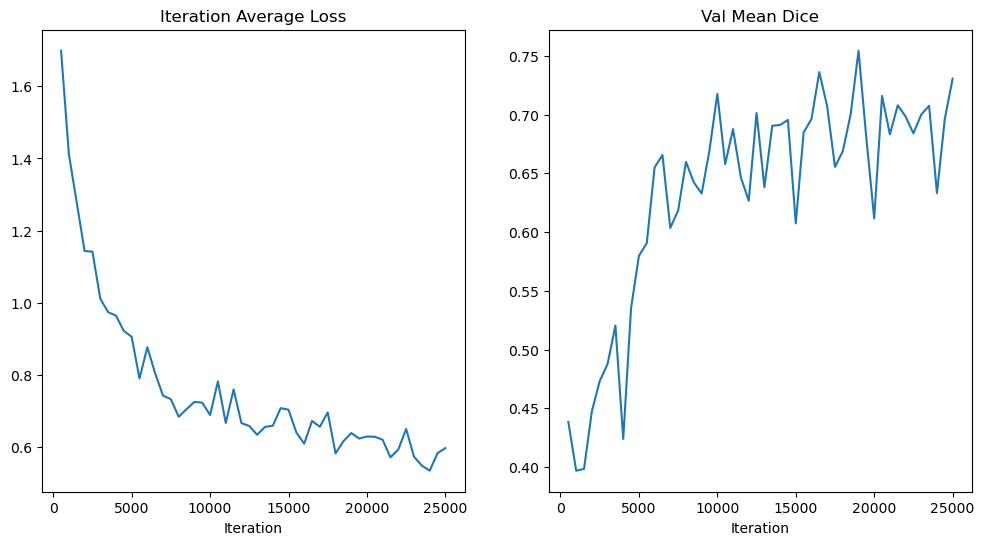

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


In [9]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [10]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_unmulticoncat_onwordfintuneonmiccai_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_unmulticoncat_onmiccai_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.84009): 100%|█| 24/24 [00:06<00:00,  3.47it/
Training (47 / 25000 Steps) (loss=2.59192): 100%|█| 24/24 [00:06<00:00,  3.53it/
Training (71 / 25000 Steps) (loss=2.53294): 100%|█| 24/24 [00:06<00:00,  3.51it/
Training (95 / 25000 Steps) (loss=2.38924): 100%|█| 24/24 [00:06<00:00,  3.50it/
Training (119 / 25000 Steps) (loss=2.40495): 100%|█| 24/24 [00:06<00:00,  3.47it
Training (143 / 25000 Steps) (loss=2.36225): 100%|█| 24/24 [00:06<00:00,  3.51it
Training (167 / 25000 Steps) (loss=2.34796): 100%|█| 24/24 [00:06<00:00,  3.47it
Training (191 / 25000 Steps) (loss=2.28485): 100%|█| 24/24 [00:06<00:00,  3.53it
Training (215 / 25000 Steps) (loss=2.22009): 100%|█| 24/24 [00:06<00:00,  3.56it
Training (239 / 25000 Steps) (loss=2.23986): 100%|█| 24/24 [00:06<00:00,  3.50it
Training (263 / 25000 Steps) (loss=2.21767): 100%|█| 24/24 [00:06<00:00,  3.46it
Training (287 / 25000 Steps) (loss=2.16532): 100%|█| 24/24 [00:06<00:00,  3.53it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3645252287387848 Current Avg. Dice: 0.3645252287387848


Training (503 / 25000 Steps) (loss=1.88572): 100%|█| 24/24 [00:08<00:00,  2.93it
Training (527 / 25000 Steps) (loss=1.78004): 100%|█| 24/24 [00:06<00:00,  3.53it
Training (551 / 25000 Steps) (loss=1.85464): 100%|█| 24/24 [00:06<00:00,  3.52it
Training (575 / 25000 Steps) (loss=1.85843): 100%|█| 24/24 [00:06<00:00,  3.50it
Training (599 / 25000 Steps) (loss=1.79653): 100%|█| 24/24 [00:06<00:00,  3.49it
Training (623 / 25000 Steps) (loss=1.85206): 100%|█| 24/24 [00:06<00:00,  3.51it
Training (647 / 25000 Steps) (loss=1.81890): 100%|█| 24/24 [00:06<00:00,  3.49it
Training (671 / 25000 Steps) (loss=1.75610): 100%|█| 24/24 [00:06<00:00,  3.49it
Training (695 / 25000 Steps) (loss=1.78235): 100%|█| 24/24 [00:06<00:00,  3.52it
Training (719 / 25000 Steps) (loss=1.75627): 100%|█| 24/24 [00:06<00:00,  3.49it
Training (743 / 25000 Steps) (loss=1.77632): 100%|█| 24/24 [00:06<00:00,  3.45it
Training (767 / 25000 Steps) (loss=1.84808): 100%|█| 24/24 [00:06<00:00,  3.54it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3942115306854248 Current Avg. Dice: 0.3942115306854248


Training (1007 / 25000 Steps) (loss=1.47366): 100%|█| 24/24 [00:07<00:00,  3.03i
Training (1031 / 25000 Steps) (loss=1.45340): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (1055 / 25000 Steps) (loss=1.54661): 100%|█| 24/24 [00:06<00:00,  3.47i
Training (1079 / 25000 Steps) (loss=1.65055): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1103 / 25000 Steps) (loss=1.58986): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1127 / 25000 Steps) (loss=1.65732): 100%|█| 24/24 [00:06<00:00,  3.47i
Training (1151 / 25000 Steps) (loss=1.33189): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (1175 / 25000 Steps) (loss=1.29967): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (1199 / 25000 Steps) (loss=1.76827): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (1223 / 25000 Steps) (loss=1.27460): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1247 / 25000 Steps) (loss=1.29155): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (1271 / 25000 Steps) (loss=1.50526): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.3942115306854248 Current Avg. Dice: 0.3699305057525635


Training (1511 / 25000 Steps) (loss=1.30172): 100%|█| 24/24 [00:07<00:00,  3.06i
Training (1535 / 25000 Steps) (loss=1.17874): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (1559 / 25000 Steps) (loss=1.25451): 100%|█| 24/24 [00:06<00:00,  3.46i
Training (1583 / 25000 Steps) (loss=1.36976): 100%|█| 24/24 [00:06<00:00,  3.48i
Training (1607 / 25000 Steps) (loss=1.24876): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (1631 / 25000 Steps) (loss=1.24871): 100%|█| 24/24 [00:06<00:00,  3.48i
Training (1655 / 25000 Steps) (loss=1.29481): 100%|█| 24/24 [00:06<00:00,  3.44i
Training (1679 / 25000 Steps) (loss=1.22407): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (1703 / 25000 Steps) (loss=1.26543): 100%|█| 24/24 [00:06<00:00,  3.46i
Training (1727 / 25000 Steps) (loss=1.15108): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (1751 / 25000 Steps) (loss=1.15318): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (1775 / 25000 Steps) (loss=1.17009): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.3942115306854248 Current Avg. Dice: 0.35360100865364075


Training (2015 / 25000 Steps) (loss=1.10533): 100%|█| 24/24 [00:07<00:00,  3.05i
Training (2039 / 25000 Steps) (loss=1.13492): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2063 / 25000 Steps) (loss=1.12838): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (2087 / 25000 Steps) (loss=1.16791): 100%|█| 24/24 [00:06<00:00,  3.45i
Training (2111 / 25000 Steps) (loss=1.21503): 100%|█| 24/24 [00:06<00:00,  3.47i
Training (2135 / 25000 Steps) (loss=1.01020): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (2159 / 25000 Steps) (loss=1.16009): 100%|█| 24/24 [00:06<00:00,  3.48i
Training (2183 / 25000 Steps) (loss=1.12925): 100%|█| 24/24 [00:06<00:00,  3.46i
Training (2207 / 25000 Steps) (loss=1.26109): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2231 / 25000 Steps) (loss=1.29450): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (2255 / 25000 Steps) (loss=1.31598): 100%|█| 24/24 [00:06<00:00,  3.46i
Training (2279 / 25000 Steps) (loss=1.06203): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4488183259963989 Current Avg. Dice: 0.4488183259963989


Training (2519 / 25000 Steps) (loss=1.32594): 100%|█| 24/24 [00:07<00:00,  3.02i
Training (2543 / 25000 Steps) (loss=1.29808): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (2567 / 25000 Steps) (loss=1.20138): 100%|█| 24/24 [00:06<00:00,  3.46i
Training (2591 / 25000 Steps) (loss=1.02646): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2615 / 25000 Steps) (loss=1.07948): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2639 / 25000 Steps) (loss=1.11694): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (2663 / 25000 Steps) (loss=0.97169): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2687 / 25000 Steps) (loss=1.07772): 100%|█| 24/24 [00:06<00:00,  3.53i
Training (2711 / 25000 Steps) (loss=1.04538): 100%|█| 24/24 [00:06<00:00,  3.49i
Training (2735 / 25000 Steps) (loss=1.03387): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (2759 / 25000 Steps) (loss=1.04358): 100%|█| 24/24 [00:06<00:00,  3.54i
Training (2783 / 25000 Steps) (loss=1.11556): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4531210958957672 Current Avg. Dice: 0.4531210958957672


Training (3023 / 25000 Steps) (loss=1.04538): 100%|█| 24/24 [00:07<00:00,  3.05i
Training (3047 / 25000 Steps) (loss=0.91862): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (3071 / 25000 Steps) (loss=1.09478): 100%|█| 24/24 [00:06<00:00,  3.51i
Training (3095 / 25000 Steps) (loss=1.08390): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (3119 / 25000 Steps) (loss=0.90080): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (3143 / 25000 Steps) (loss=0.93179): 100%|█| 24/24 [00:06<00:00,  3.50i
Training (3167 / 25000 Steps) (loss=1.14936): 100%|█| 24/24 [00:06<00:00,  3.47i
Training (3191 / 25000 Steps) (loss=1.01804): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (3215 / 25000 Steps) (loss=1.03167): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3239 / 25000 Steps) (loss=1.23275): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3263 / 25000 Steps) (loss=1.14159): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3287 / 25000 Steps) (loss=0.95602): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.47419047355651855 Current Avg. Dice: 0.47419047355651855


Training (3503 / 25000 Steps) (loss=1.06598): 100%|█| 24/24 [00:07<00:00,  3.09i
Training (3527 / 25000 Steps) (loss=0.98775): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3551 / 25000 Steps) (loss=0.98856): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3575 / 25000 Steps) (loss=1.23289): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3599 / 25000 Steps) (loss=0.91707): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (3623 / 25000 Steps) (loss=1.19469): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3647 / 25000 Steps) (loss=1.03653): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (3671 / 25000 Steps) (loss=0.94765): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3695 / 25000 Steps) (loss=1.06445): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3719 / 25000 Steps) (loss=1.01613): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (3743 / 25000 Steps) (loss=0.99601): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3767 / 25000 Steps) (loss=1.07830): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.49454808235168457 Current Avg. Dice: 0.49454808235168457


Training (4007 / 25000 Steps) (loss=0.95045): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (4031 / 25000 Steps) (loss=0.89434): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4055 / 25000 Steps) (loss=1.05873): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4079 / 25000 Steps) (loss=1.68375): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (4103 / 25000 Steps) (loss=0.96292): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4127 / 25000 Steps) (loss=1.04148): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (4151 / 25000 Steps) (loss=1.01930): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4175 / 25000 Steps) (loss=1.04692): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4199 / 25000 Steps) (loss=1.02224): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4223 / 25000 Steps) (loss=0.82505): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4247 / 25000 Steps) (loss=0.95026): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4271 / 25000 Steps) (loss=1.07140): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5770378112792969 Current Avg. Dice: 0.5770378112792969


Training (4511 / 25000 Steps) (loss=1.47382): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (4535 / 25000 Steps) (loss=0.93317): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4559 / 25000 Steps) (loss=1.49086): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4583 / 25000 Steps) (loss=0.96317): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4607 / 25000 Steps) (loss=1.11655): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4631 / 25000 Steps) (loss=0.96114): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4655 / 25000 Steps) (loss=0.94813): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (4679 / 25000 Steps) (loss=0.93124): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4703 / 25000 Steps) (loss=1.15947): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (4727 / 25000 Steps) (loss=1.00684): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (4751 / 25000 Steps) (loss=0.97407): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (4775 / 25000 Steps) (loss=0.97496): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5951421856880188 Current Avg. Dice: 0.5951421856880188


Training (5015 / 25000 Steps) (loss=0.91802): 100%|█| 24/24 [00:07<00:00,  3.11i
Training (5039 / 25000 Steps) (loss=0.88086): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (5063 / 25000 Steps) (loss=0.90100): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5087 / 25000 Steps) (loss=0.93768): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5111 / 25000 Steps) (loss=0.85912): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5135 / 25000 Steps) (loss=0.87127): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (5159 / 25000 Steps) (loss=0.86774): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5183 / 25000 Steps) (loss=0.87327): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5207 / 25000 Steps) (loss=0.75803): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5231 / 25000 Steps) (loss=0.85342): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5255 / 25000 Steps) (loss=0.87154): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5279 / 25000 Steps) (loss=0.86310): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6075490713119507 Current Avg. Dice: 0.6075490713119507


Training (5519 / 25000 Steps) (loss=0.92283): 100%|█| 24/24 [00:07<00:00,  3.09i
Training (5543 / 25000 Steps) (loss=0.95826): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5567 / 25000 Steps) (loss=0.88850): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (5591 / 25000 Steps) (loss=0.93189): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5615 / 25000 Steps) (loss=0.83595): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5639 / 25000 Steps) (loss=0.99516): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5663 / 25000 Steps) (loss=0.82761): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (5687 / 25000 Steps) (loss=0.93868): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5711 / 25000 Steps) (loss=0.80321): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (5735 / 25000 Steps) (loss=1.43923): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (5759 / 25000 Steps) (loss=0.77374): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (5783 / 25000 Steps) (loss=0.76650): 100%|█| 24/24 [00:06<00:00,  3.52i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6075490713119507 Current Avg. Dice: 0.6034544110298157


Training (6023 / 25000 Steps) (loss=0.75273): 100%|█| 24/24 [00:07<00:00,  3.20i
Training (6047 / 25000 Steps) (loss=0.92783): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (6071 / 25000 Steps) (loss=0.87165): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6095 / 25000 Steps) (loss=0.74825): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6119 / 25000 Steps) (loss=0.81730): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6143 / 25000 Steps) (loss=0.88515): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6167 / 25000 Steps) (loss=0.83174): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (6191 / 25000 Steps) (loss=0.99202): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6215 / 25000 Steps) (loss=0.85849): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6239 / 25000 Steps) (loss=0.70724): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6263 / 25000 Steps) (loss=0.73624): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6287 / 25000 Steps) (loss=0.82416): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6371595859527588 Current Avg. Dice: 0.6371595859527588


Training (6503 / 25000 Steps) (loss=0.66040): 100%|█| 24/24 [00:07<00:00,  3.10i
Training (6527 / 25000 Steps) (loss=0.83080): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6551 / 25000 Steps) (loss=0.77556): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6575 / 25000 Steps) (loss=0.66038): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6599 / 25000 Steps) (loss=0.88539): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6623 / 25000 Steps) (loss=0.75597): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6647 / 25000 Steps) (loss=0.81545): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6671 / 25000 Steps) (loss=0.85511): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6695 / 25000 Steps) (loss=0.80799): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (6719 / 25000 Steps) (loss=0.80082): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6743 / 25000 Steps) (loss=0.73711): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (6767 / 25000 Steps) (loss=0.66597): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.669089138507843 Current Avg. Dice: 0.669089138507843


Training (7007 / 25000 Steps) (loss=0.80025): 100%|█| 24/24 [00:07<00:00,  3.09i
Training (7031 / 25000 Steps) (loss=0.67896): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7055 / 25000 Steps) (loss=0.83907): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7079 / 25000 Steps) (loss=0.81279): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7103 / 25000 Steps) (loss=0.72640): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7127 / 25000 Steps) (loss=0.74859): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7151 / 25000 Steps) (loss=0.88779): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7175 / 25000 Steps) (loss=0.84181): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7199 / 25000 Steps) (loss=0.80632): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (7223 / 25000 Steps) (loss=0.86091): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (7247 / 25000 Steps) (loss=1.10650): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7271 / 25000 Steps) (loss=0.86307): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.669089138507843 Current Avg. Dice: 0.6178982853889465


Training (7511 / 25000 Steps) (loss=0.84332): 100%|█| 24/24 [00:07<00:00,  3.16i
Training (7535 / 25000 Steps) (loss=0.78592): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7559 / 25000 Steps) (loss=0.94733): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7583 / 25000 Steps) (loss=0.88536): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7607 / 25000 Steps) (loss=0.84825): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (7631 / 25000 Steps) (loss=0.66099): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7655 / 25000 Steps) (loss=0.66938): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7679 / 25000 Steps) (loss=0.81832): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7703 / 25000 Steps) (loss=0.95441): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7727 / 25000 Steps) (loss=0.72213): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (7751 / 25000 Steps) (loss=0.82692): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (7775 / 25000 Steps) (loss=0.68886): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.669089138507843 Current Avg. Dice: 0.6250035762786865


Training (8015 / 25000 Steps) (loss=0.66115): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (8039 / 25000 Steps) (loss=0.92133): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8063 / 25000 Steps) (loss=0.67691): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8087 / 25000 Steps) (loss=0.91803): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8111 / 25000 Steps) (loss=0.84805): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8135 / 25000 Steps) (loss=0.75330): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8159 / 25000 Steps) (loss=0.79301): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (8183 / 25000 Steps) (loss=0.59299): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (8207 / 25000 Steps) (loss=0.81768): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8231 / 25000 Steps) (loss=0.76979): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8255 / 25000 Steps) (loss=0.75894): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8279 / 25000 Steps) (loss=0.75787): 100%|█| 24/24 [00:06<00:00,  3.55i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6787335276603699 Current Avg. Dice: 0.6787335276603699


Training (8519 / 25000 Steps) (loss=0.68273): 100%|█| 24/24 [00:07<00:00,  3.11i
Training (8543 / 25000 Steps) (loss=0.73943): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8567 / 25000 Steps) (loss=0.78272): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8591 / 25000 Steps) (loss=0.78210): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8615 / 25000 Steps) (loss=0.67349): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8639 / 25000 Steps) (loss=0.93829): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8663 / 25000 Steps) (loss=0.67236): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (8687 / 25000 Steps) (loss=0.80990): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8711 / 25000 Steps) (loss=0.77624): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (8735 / 25000 Steps) (loss=0.83741): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (8759 / 25000 Steps) (loss=0.75116): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (8783 / 25000 Steps) (loss=0.76262): 100%|█| 24/24 [00:06<00:00,  3.60i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6787335276603699 Current Avg. Dice: 0.6555262804031372


Training (9023 / 25000 Steps) (loss=0.72354): 100%|█| 24/24 [00:07<00:00,  3.15i
Training (9047 / 25000 Steps) (loss=0.82145): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9071 / 25000 Steps) (loss=0.73279): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9095 / 25000 Steps) (loss=0.79282): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9119 / 25000 Steps) (loss=0.61786): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9143 / 25000 Steps) (loss=0.88784): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9167 / 25000 Steps) (loss=0.80107): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9191 / 25000 Steps) (loss=0.60594): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9215 / 25000 Steps) (loss=0.85607): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (9239 / 25000 Steps) (loss=1.12438): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9263 / 25000 Steps) (loss=0.78605): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9287 / 25000 Steps) (loss=0.68299): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6787335276603699 Current Avg. Dice: 0.6083453297615051


Training (9503 / 25000 Steps) (loss=0.71892): 100%|█| 24/24 [00:07<00:00,  3.17i
Training (9527 / 25000 Steps) (loss=0.68185): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9551 / 25000 Steps) (loss=0.66165): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9575 / 25000 Steps) (loss=0.86005): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (9599 / 25000 Steps) (loss=0.77323): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9623 / 25000 Steps) (loss=0.69237): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9647 / 25000 Steps) (loss=0.84788): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9671 / 25000 Steps) (loss=0.79838): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9695 / 25000 Steps) (loss=0.94910): 100%|█| 24/24 [00:06<00:00,  3.57i
Training (9719 / 25000 Steps) (loss=0.71961): 100%|█| 24/24 [00:06<00:00,  3.56i
Training (9743 / 25000 Steps) (loss=0.81186): 100%|█| 24/24 [00:06<00:00,  3.59i
Training (9767 / 25000 Steps) (loss=0.67504): 100%|█| 24/24 [00:06<00:00,  3.58i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6787335276603699 Current Avg. Dice: 0.6618553996086121


Training (10007 / 25000 Steps) (loss=0.81002): 100%|█| 24/24 [00:07<00:00,  3.17
Training (10031 / 25000 Steps) (loss=0.61675): 100%|█| 24/24 [00:06<00:00,  3.54
Training (10055 / 25000 Steps) (loss=0.72521): 100%|█| 24/24 [00:06<00:00,  3.55
Training (10079 / 25000 Steps) (loss=0.73743): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10103 / 25000 Steps) (loss=0.66426): 100%|█| 24/24 [00:06<00:00,  3.57
Training (10127 / 25000 Steps) (loss=0.83679): 100%|█| 24/24 [00:06<00:00,  3.57
Training (10151 / 25000 Steps) (loss=0.66547): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10175 / 25000 Steps) (loss=0.79487): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10199 / 25000 Steps) (loss=0.77470): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10223 / 25000 Steps) (loss=0.69585): 100%|█| 24/24 [00:06<00:00,  3.57
Training (10247 / 25000 Steps) (loss=0.72725): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10271 / 25000 Steps) (loss=0.68245): 100%|█| 24/24 [00:06<00:00,  3.55
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6902026534080505 Current Avg. Dice: 0.6902026534080505


Training (10511 / 25000 Steps) (loss=0.58314): 100%|█| 24/24 [00:07<00:00,  3.11
Training (10535 / 25000 Steps) (loss=0.86360): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10559 / 25000 Steps) (loss=0.85446): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10583 / 25000 Steps) (loss=0.85021): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10607 / 25000 Steps) (loss=0.67420): 100%|█| 24/24 [00:06<00:00,  3.60
Training (10631 / 25000 Steps) (loss=0.64586): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10655 / 25000 Steps) (loss=0.78495): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10679 / 25000 Steps) (loss=0.81670): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10703 / 25000 Steps) (loss=0.72450): 100%|█| 24/24 [00:06<00:00,  3.57
Training (10727 / 25000 Steps) (loss=0.72891): 100%|█| 24/24 [00:06<00:00,  3.59
Training (10751 / 25000 Steps) (loss=0.80037): 100%|█| 24/24 [00:06<00:00,  3.57
Training (10775 / 25000 Steps) (loss=0.82889): 100%|█| 24/24 [00:06<00:00,  3.58
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6902026534080505 Current Avg. Dice: 0.5907019972801208


Training (11015 / 25000 Steps) (loss=0.73513): 100%|█| 24/24 [00:07<00:00,  3.17
Training (11039 / 25000 Steps) (loss=0.68333): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11063 / 25000 Steps) (loss=0.77312): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11087 / 25000 Steps) (loss=0.61254): 100%|█| 24/24 [00:06<00:00,  3.57
Training (11111 / 25000 Steps) (loss=0.72481): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11135 / 25000 Steps) (loss=0.65697): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11159 / 25000 Steps) (loss=0.63352): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11183 / 25000 Steps) (loss=0.68707): 100%|█| 24/24 [00:06<00:00,  3.55
Training (11207 / 25000 Steps) (loss=0.81411): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11231 / 25000 Steps) (loss=0.73660): 100%|█| 24/24 [00:06<00:00,  3.56
Training (11255 / 25000 Steps) (loss=0.79410): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11279 / 25000 Steps) (loss=0.80109): 100%|█| 24/24 [00:06<00:00,  3.56
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7083199620246887 Current Avg. Dice: 0.7083199620246887


Training (11519 / 25000 Steps) (loss=0.51496): 100%|█| 24/24 [00:07<00:00,  3.11
Training (11543 / 25000 Steps) (loss=0.62149): 100%|█| 24/24 [00:06<00:00,  3.55
Training (11567 / 25000 Steps) (loss=0.74029): 100%|█| 24/24 [00:06<00:00,  3.57
Training (11591 / 25000 Steps) (loss=0.73150): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11615 / 25000 Steps) (loss=0.71341): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11639 / 25000 Steps) (loss=0.51069): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11663 / 25000 Steps) (loss=0.70931): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11687 / 25000 Steps) (loss=0.72646): 100%|█| 24/24 [00:06<00:00,  3.58
Training (11711 / 25000 Steps) (loss=0.80830): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11735 / 25000 Steps) (loss=0.59860): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11759 / 25000 Steps) (loss=0.51493): 100%|█| 24/24 [00:06<00:00,  3.60
Training (11783 / 25000 Steps) (loss=0.77729): 100%|█| 24/24 [00:06<00:00,  3.59
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7083199620246887 Current Avg. Dice: 0.705247700214386


Training (12023 / 25000 Steps) (loss=0.79600): 100%|█| 24/24 [00:07<00:00,  3.17
Training (12047 / 25000 Steps) (loss=0.64016): 100%|█| 24/24 [00:06<00:00,  3.57
Training (12071 / 25000 Steps) (loss=0.72178): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12095 / 25000 Steps) (loss=0.81603): 100%|█| 24/24 [00:06<00:00,  3.56
Training (12119 / 25000 Steps) (loss=0.66978): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12143 / 25000 Steps) (loss=0.60074): 100%|█| 24/24 [00:06<00:00,  3.57
Training (12167 / 25000 Steps) (loss=0.69560): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12191 / 25000 Steps) (loss=0.49232): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12215 / 25000 Steps) (loss=0.45690): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12239 / 25000 Steps) (loss=0.61217): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12263 / 25000 Steps) (loss=0.73015): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12287 / 25000 Steps) (loss=0.66388): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7403764724731445 Current Avg. Dice: 0.7403764724731445


Training (12503 / 25000 Steps) (loss=0.76190): 100%|█| 24/24 [00:07<00:00,  3.11
Training (12527 / 25000 Steps) (loss=0.77942): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12551 / 25000 Steps) (loss=0.53468): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12575 / 25000 Steps) (loss=0.69809): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12599 / 25000 Steps) (loss=0.71433): 100%|█| 24/24 [00:06<00:00,  3.54
Training (12623 / 25000 Steps) (loss=0.57404): 100%|█| 24/24 [00:06<00:00,  3.56
Training (12647 / 25000 Steps) (loss=0.61931): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12671 / 25000 Steps) (loss=0.68191): 100%|█| 24/24 [00:06<00:00,  3.60
Training (12695 / 25000 Steps) (loss=0.68921): 100%|█| 24/24 [00:06<00:00,  3.57
Training (12719 / 25000 Steps) (loss=0.56536): 100%|█| 24/24 [00:06<00:00,  3.59
Training (12743 / 25000 Steps) (loss=0.53523): 100%|█| 24/24 [00:06<00:00,  3.61
Training (12767 / 25000 Steps) (loss=0.65942): 100%|█| 24/24 [00:06<00:00,  3.58
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7403764724731445 Current Avg. Dice: 0.6491876840591431


Training (13007 / 25000 Steps) (loss=0.48049): 100%|█| 24/24 [00:07<00:00,  3.17
Training (13031 / 25000 Steps) (loss=0.63575): 100%|█| 24/24 [00:06<00:00,  3.57
Training (13055 / 25000 Steps) (loss=0.61308): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13079 / 25000 Steps) (loss=0.60106): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13103 / 25000 Steps) (loss=0.76875): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13127 / 25000 Steps) (loss=0.69718): 100%|█| 24/24 [00:06<00:00,  3.60
Training (13151 / 25000 Steps) (loss=0.80593): 100%|█| 24/24 [00:06<00:00,  3.57
Training (13175 / 25000 Steps) (loss=0.75630): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13199 / 25000 Steps) (loss=0.63744): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13223 / 25000 Steps) (loss=0.66971): 100%|█| 24/24 [00:06<00:00,  3.56
Training (13247 / 25000 Steps) (loss=0.79743): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13271 / 25000 Steps) (loss=0.59238): 100%|█| 24/24 [00:06<00:00,  3.56
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7403764724731445 Current Avg. Dice: 0.6944031119346619


Training (13511 / 25000 Steps) (loss=0.69522): 100%|█| 24/24 [00:07<00:00,  3.16
Training (13535 / 25000 Steps) (loss=0.55970): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13559 / 25000 Steps) (loss=0.61880): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13583 / 25000 Steps) (loss=0.73753): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13607 / 25000 Steps) (loss=0.67859): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13631 / 25000 Steps) (loss=0.68468): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13655 / 25000 Steps) (loss=0.57177): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13679 / 25000 Steps) (loss=0.64354): 100%|█| 24/24 [00:06<00:00,  3.55
Training (13703 / 25000 Steps) (loss=0.67483): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13727 / 25000 Steps) (loss=0.91521): 100%|█| 24/24 [00:06<00:00,  3.58
Training (13751 / 25000 Steps) (loss=0.46743): 100%|█| 24/24 [00:06<00:00,  3.56
Training (13775 / 25000 Steps) (loss=0.81333): 100%|█| 24/24 [00:06<00:00,  3.59
Training (13799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.742516815662384 Current Avg. Dice: 0.742516815662384


Training (14015 / 25000 Steps) (loss=0.70764): 100%|█| 24/24 [00:07<00:00,  3.09
Training (14039 / 25000 Steps) (loss=0.65810): 100%|█| 24/24 [00:06<00:00,  3.54
Training (14063 / 25000 Steps) (loss=0.51438): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14087 / 25000 Steps) (loss=0.73313): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14111 / 25000 Steps) (loss=0.71878): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14135 / 25000 Steps) (loss=0.79392): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14159 / 25000 Steps) (loss=0.68684): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14183 / 25000 Steps) (loss=0.71187): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14207 / 25000 Steps) (loss=0.85402): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14231 / 25000 Steps) (loss=0.76627): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14255 / 25000 Steps) (loss=0.76443): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14279 / 25000 Steps) (loss=0.59951): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.742516815662384 Current Avg. Dice: 0.7022390365600586


Training (14519 / 25000 Steps) (loss=0.72898): 100%|█| 24/24 [00:07<00:00,  3.16
Training (14543 / 25000 Steps) (loss=0.63409): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14567 / 25000 Steps) (loss=0.76706): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14591 / 25000 Steps) (loss=0.65542): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14615 / 25000 Steps) (loss=0.69928): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14639 / 25000 Steps) (loss=0.46009): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14663 / 25000 Steps) (loss=0.71330): 100%|█| 24/24 [00:06<00:00,  3.60
Training (14687 / 25000 Steps) (loss=0.44101): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14711 / 25000 Steps) (loss=0.68869): 100%|█| 24/24 [00:06<00:00,  3.58
Training (14735 / 25000 Steps) (loss=0.75115): 100%|█| 24/24 [00:06<00:00,  3.57
Training (14759 / 25000 Steps) (loss=0.71088): 100%|█| 24/24 [00:06<00:00,  3.54
Training (14783 / 25000 Steps) (loss=0.57231): 100%|█| 24/24 [00:06<00:00,  3.59
Training (14807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.7428028583526611


Training (15023 / 25000 Steps) (loss=0.60293): 100%|█| 24/24 [00:07<00:00,  3.10
Training (15047 / 25000 Steps) (loss=0.72248): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15071 / 25000 Steps) (loss=0.65282): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15095 / 25000 Steps) (loss=0.67356): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15119 / 25000 Steps) (loss=0.66310): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15143 / 25000 Steps) (loss=0.58300): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15167 / 25000 Steps) (loss=0.68934): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15191 / 25000 Steps) (loss=0.52809): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15215 / 25000 Steps) (loss=0.70583): 100%|█| 24/24 [00:06<00:00,  3.55
Training (15239 / 25000 Steps) (loss=0.67142): 100%|█| 24/24 [00:06<00:00,  3.61
Training (15263 / 25000 Steps) (loss=0.59734): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15287 / 25000 Steps) (loss=0.58094): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.7016072869300842


Training (15503 / 25000 Steps) (loss=0.62023): 100%|█| 24/24 [00:07<00:00,  3.16
Training (15527 / 25000 Steps) (loss=0.69294): 100%|█| 24/24 [00:06<00:00,  3.56
Training (15551 / 25000 Steps) (loss=0.71221): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15575 / 25000 Steps) (loss=0.68580): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15599 / 25000 Steps) (loss=0.67601): 100%|█| 24/24 [00:06<00:00,  3.58
Training (15623 / 25000 Steps) (loss=0.79459): 100%|█| 24/24 [00:06<00:00,  3.60
Training (15647 / 25000 Steps) (loss=0.72694): 100%|█| 24/24 [00:06<00:00,  3.55
Training (15671 / 25000 Steps) (loss=0.70021): 100%|█| 24/24 [00:06<00:00,  3.59
Training (15695 / 25000 Steps) (loss=0.68675): 100%|█| 24/24 [00:06<00:00,  3.56
Training (15719 / 25000 Steps) (loss=0.69308): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15743 / 25000 Steps) (loss=0.61291): 100%|█| 24/24 [00:06<00:00,  3.57
Training (15767 / 25000 Steps) (loss=0.64469): 100%|█| 24/24 [00:06<00:00,  3.56
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.6786263585090637


Training (16007 / 25000 Steps) (loss=0.89429): 100%|█| 24/24 [00:07<00:00,  3.16
Training (16031 / 25000 Steps) (loss=0.65053): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16055 / 25000 Steps) (loss=0.50208): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16079 / 25000 Steps) (loss=0.53345): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16103 / 25000 Steps) (loss=0.64343): 100%|█| 24/24 [00:06<00:00,  3.60
Training (16127 / 25000 Steps) (loss=0.45204): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16151 / 25000 Steps) (loss=0.58793): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16175 / 25000 Steps) (loss=0.77214): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16199 / 25000 Steps) (loss=0.49563): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16223 / 25000 Steps) (loss=0.68533): 100%|█| 24/24 [00:06<00:00,  3.56
Training (16247 / 25000 Steps) (loss=0.59570): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16271 / 25000 Steps) (loss=0.49794): 100%|█| 24/24 [00:06<00:00,  3.55
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.70249342918396


Training (16511 / 25000 Steps) (loss=0.70184): 100%|█| 24/24 [00:07<00:00,  3.18
Training (16535 / 25000 Steps) (loss=0.44020): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16559 / 25000 Steps) (loss=0.67682): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16583 / 25000 Steps) (loss=0.77733): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16607 / 25000 Steps) (loss=0.63246): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16631 / 25000 Steps) (loss=0.35741): 100%|█| 24/24 [00:06<00:00,  3.60
Training (16655 / 25000 Steps) (loss=0.61244): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16679 / 25000 Steps) (loss=0.60287): 100%|█| 24/24 [00:06<00:00,  3.59
Training (16703 / 25000 Steps) (loss=0.60693): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16727 / 25000 Steps) (loss=0.80598): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16751 / 25000 Steps) (loss=0.75333): 100%|█| 24/24 [00:06<00:00,  3.58
Training (16775 / 25000 Steps) (loss=0.56342): 100%|█| 24/24 [00:06<00:00,  3.57
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.7231557965278625


Training (17015 / 25000 Steps) (loss=0.49305): 100%|█| 24/24 [00:07<00:00,  3.17
Training (17039 / 25000 Steps) (loss=0.41901): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17063 / 25000 Steps) (loss=0.74412): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17087 / 25000 Steps) (loss=0.75481): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17111 / 25000 Steps) (loss=0.76117): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17135 / 25000 Steps) (loss=0.50767): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17159 / 25000 Steps) (loss=0.77435): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17183 / 25000 Steps) (loss=0.62291): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17207 / 25000 Steps) (loss=0.67197): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17231 / 25000 Steps) (loss=0.50840): 100%|█| 24/24 [00:06<00:00,  3.56
Training (17255 / 25000 Steps) (loss=0.89874): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17279 / 25000 Steps) (loss=0.63360): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.7389243245124817


Training (17519 / 25000 Steps) (loss=0.40778): 100%|█| 24/24 [00:07<00:00,  3.16
Training (17543 / 25000 Steps) (loss=0.49335): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17567 / 25000 Steps) (loss=0.47831): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17591 / 25000 Steps) (loss=0.76058): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17615 / 25000 Steps) (loss=0.59362): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17639 / 25000 Steps) (loss=0.89915): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17663 / 25000 Steps) (loss=0.87779): 100%|█| 24/24 [00:06<00:00,  3.57
Training (17687 / 25000 Steps) (loss=0.75542): 100%|█| 24/24 [00:06<00:00,  3.59
Training (17711 / 25000 Steps) (loss=0.76215): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17735 / 25000 Steps) (loss=0.50606): 100%|█| 24/24 [00:06<00:00,  3.60
Training (17759 / 25000 Steps) (loss=0.72536): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17783 / 25000 Steps) (loss=0.56293): 100%|█| 24/24 [00:06<00:00,  3.58
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.6771249175071716


Training (18023 / 25000 Steps) (loss=0.55096): 100%|█| 24/24 [00:07<00:00,  3.17
Training (18047 / 25000 Steps) (loss=0.68871): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18071 / 25000 Steps) (loss=0.65546): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18095 / 25000 Steps) (loss=0.69168): 100%|█| 24/24 [00:06<00:00,  3.55
Training (18119 / 25000 Steps) (loss=0.56119): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18143 / 25000 Steps) (loss=0.68337): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18167 / 25000 Steps) (loss=0.69013): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18191 / 25000 Steps) (loss=0.49756): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18215 / 25000 Steps) (loss=0.70629): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18239 / 25000 Steps) (loss=0.72870): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18263 / 25000 Steps) (loss=0.66876): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18287 / 25000 Steps) (loss=0.58596): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.7391354441642761


Training (18503 / 25000 Steps) (loss=0.54574): 100%|█| 24/24 [00:07<00:00,  3.18
Training (18527 / 25000 Steps) (loss=0.82458): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18551 / 25000 Steps) (loss=0.68074): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18575 / 25000 Steps) (loss=0.61962): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18599 / 25000 Steps) (loss=0.82108): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18623 / 25000 Steps) (loss=0.78122): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18647 / 25000 Steps) (loss=0.48350): 100%|█| 24/24 [00:06<00:00,  3.55
Training (18671 / 25000 Steps) (loss=0.68120): 100%|█| 24/24 [00:06<00:00,  3.59
Training (18695 / 25000 Steps) (loss=0.77810): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18719 / 25000 Steps) (loss=0.84220): 100%|█| 24/24 [00:06<00:00,  3.58
Training (18743 / 25000 Steps) (loss=0.65447): 100%|█| 24/24 [00:06<00:00,  3.57
Training (18767 / 25000 Steps) (loss=0.64617): 100%|█| 24/24 [00:06<00:00,  3.60
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.7268255352973938


Training (19007 / 25000 Steps) (loss=0.82818): 100%|█| 24/24 [00:07<00:00,  3.18
Training (19031 / 25000 Steps) (loss=0.76894): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19055 / 25000 Steps) (loss=0.58704): 100%|█| 24/24 [00:06<00:00,  3.56
Training (19079 / 25000 Steps) (loss=0.56836): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19103 / 25000 Steps) (loss=0.63483): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19127 / 25000 Steps) (loss=0.67842): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19151 / 25000 Steps) (loss=0.59242): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19175 / 25000 Steps) (loss=0.77652): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19199 / 25000 Steps) (loss=0.84153): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19223 / 25000 Steps) (loss=0.48702): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19247 / 25000 Steps) (loss=0.86188): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19271 / 25000 Steps) (loss=0.58011): 100%|█| 24/24 [00:06<00:00,  3.56
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.6767032742500305


Training (19511 / 25000 Steps) (loss=0.73056): 100%|█| 24/24 [00:07<00:00,  3.17
Training (19535 / 25000 Steps) (loss=0.72032): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19559 / 25000 Steps) (loss=0.61231): 100%|█| 24/24 [00:06<00:00,  3.54
Training (19583 / 25000 Steps) (loss=0.81113): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19607 / 25000 Steps) (loss=0.62618): 100%|█| 24/24 [00:06<00:00,  3.59
Training (19631 / 25000 Steps) (loss=0.68242): 100%|█| 24/24 [00:06<00:00,  3.60
Training (19655 / 25000 Steps) (loss=0.84729): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19679 / 25000 Steps) (loss=0.67501): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19703 / 25000 Steps) (loss=0.64544): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19727 / 25000 Steps) (loss=0.72422): 100%|█| 24/24 [00:06<00:00,  3.57
Training (19751 / 25000 Steps) (loss=0.61276): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19775 / 25000 Steps) (loss=0.70365): 100%|█| 24/24 [00:06<00:00,  3.58
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.7401034235954285


Training (20015 / 25000 Steps) (loss=0.55974): 100%|█| 24/24 [00:07<00:00,  3.17
Training (20039 / 25000 Steps) (loss=0.63718): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20063 / 25000 Steps) (loss=0.45637): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20087 / 25000 Steps) (loss=0.68595): 100%|█| 24/24 [00:06<00:00,  3.57
Training (20111 / 25000 Steps) (loss=0.58095): 100%|█| 24/24 [00:06<00:00,  3.56
Training (20135 / 25000 Steps) (loss=0.81104): 100%|█| 24/24 [00:06<00:00,  3.57
Training (20159 / 25000 Steps) (loss=0.48184): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20183 / 25000 Steps) (loss=0.70907): 100%|█| 24/24 [00:06<00:00,  3.55
Training (20207 / 25000 Steps) (loss=0.79104): 100%|█| 24/24 [00:06<00:00,  3.57
Training (20231 / 25000 Steps) (loss=0.42258): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20255 / 25000 Steps) (loss=0.97358): 100%|█| 24/24 [00:06<00:00,  3.57
Training (20279 / 25000 Steps) (loss=0.66503): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7428028583526611 Current Avg. Dice: 0.7125441431999207


Training (20519 / 25000 Steps) (loss=0.74813): 100%|█| 24/24 [00:07<00:00,  3.16
Training (20543 / 25000 Steps) (loss=0.60123): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20567 / 25000 Steps) (loss=0.69901): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20591 / 25000 Steps) (loss=0.60098): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20615 / 25000 Steps) (loss=0.69033): 100%|█| 24/24 [00:06<00:00,  3.56
Training (20639 / 25000 Steps) (loss=0.58995): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20663 / 25000 Steps) (loss=0.42159): 100%|█| 24/24 [00:06<00:00,  3.56
Training (20687 / 25000 Steps) (loss=0.51074): 100%|█| 24/24 [00:06<00:00,  3.60
Training (20711 / 25000 Steps) (loss=0.71077): 100%|█| 24/24 [00:06<00:00,  3.59
Training (20735 / 25000 Steps) (loss=0.78839): 100%|█| 24/24 [00:06<00:00,  3.56
Training (20759 / 25000 Steps) (loss=0.63074): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20783 / 25000 Steps) (loss=0.63872): 100%|█| 24/24 [00:06<00:00,  3.58
Training (20807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.748784601688385 Current Avg. Dice: 0.748784601688385


Training (21023 / 25000 Steps) (loss=0.66969): 100%|█| 24/24 [00:07<00:00,  3.10
Training (21047 / 25000 Steps) (loss=0.55858): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21071 / 25000 Steps) (loss=0.65839): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21095 / 25000 Steps) (loss=0.76663): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21119 / 25000 Steps) (loss=0.65439): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21143 / 25000 Steps) (loss=0.48205): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21167 / 25000 Steps) (loss=0.66633): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21191 / 25000 Steps) (loss=0.57866): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21215 / 25000 Steps) (loss=0.53842): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21239 / 25000 Steps) (loss=0.63550): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21263 / 25000 Steps) (loss=0.66491): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21287 / 25000 Steps) (loss=0.49287): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.748784601688385 Current Avg. Dice: 0.6847832798957825


Training (21503 / 25000 Steps) (loss=0.64310): 100%|█| 24/24 [00:07<00:00,  3.16
Training (21527 / 25000 Steps) (loss=0.69041): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21551 / 25000 Steps) (loss=0.49877): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21575 / 25000 Steps) (loss=0.77950): 100%|█| 24/24 [00:06<00:00,  3.60
Training (21599 / 25000 Steps) (loss=0.75800): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21623 / 25000 Steps) (loss=0.81390): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21647 / 25000 Steps) (loss=0.68391): 100%|█| 24/24 [00:06<00:00,  3.54
Training (21671 / 25000 Steps) (loss=0.67973): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21695 / 25000 Steps) (loss=0.62366): 100%|█| 24/24 [00:06<00:00,  3.57
Training (21719 / 25000 Steps) (loss=0.58078): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21743 / 25000 Steps) (loss=0.66226): 100%|█| 24/24 [00:06<00:00,  3.59
Training (21767 / 25000 Steps) (loss=0.63649): 100%|█| 24/24 [00:06<00:00,  3.58
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.748784601688385 Current Avg. Dice: 0.7369101643562317


Training (22007 / 25000 Steps) (loss=0.66498): 100%|█| 24/24 [00:07<00:00,  3.18
Training (22031 / 25000 Steps) (loss=0.47774): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22055 / 25000 Steps) (loss=0.57769): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22079 / 25000 Steps) (loss=0.71497): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22103 / 25000 Steps) (loss=0.78720): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22127 / 25000 Steps) (loss=0.90803): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22151 / 25000 Steps) (loss=0.44310): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22175 / 25000 Steps) (loss=1.01409): 100%|█| 24/24 [00:06<00:00,  3.56
Training (22199 / 25000 Steps) (loss=0.66640): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22223 / 25000 Steps) (loss=0.61022): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22247 / 25000 Steps) (loss=0.61961): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22271 / 25000 Steps) (loss=0.52929): 100%|█| 24/24 [00:06<00:00,  3.56
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.748784601688385 Current Avg. Dice: 0.742932140827179


Training (22511 / 25000 Steps) (loss=0.74691): 100%|█| 24/24 [00:07<00:00,  3.17
Training (22535 / 25000 Steps) (loss=0.40955): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22559 / 25000 Steps) (loss=0.80338): 100%|█| 24/24 [00:06<00:00,  3.55
Training (22583 / 25000 Steps) (loss=0.45553): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22607 / 25000 Steps) (loss=0.61215): 100%|█| 24/24 [00:06<00:00,  3.56
Training (22631 / 25000 Steps) (loss=0.62067): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22655 / 25000 Steps) (loss=0.67631): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22679 / 25000 Steps) (loss=0.48183): 100%|█| 24/24 [00:06<00:00,  3.59
Training (22703 / 25000 Steps) (loss=0.72462): 100%|█| 24/24 [00:06<00:00,  3.60
Training (22727 / 25000 Steps) (loss=0.44535): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22751 / 25000 Steps) (loss=0.61665): 100%|█| 24/24 [00:06<00:00,  3.58
Training (22775 / 25000 Steps) (loss=0.66200): 100%|█| 24/24 [00:06<00:00,  3.57
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.748784601688385 Current Avg. Dice: 0.6729286313056946


Training (23015 / 25000 Steps) (loss=0.51446): 100%|█| 24/24 [00:07<00:00,  3.18
Training (23039 / 25000 Steps) (loss=0.43994): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23063 / 25000 Steps) (loss=0.47044): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23087 / 25000 Steps) (loss=0.69571): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23111 / 25000 Steps) (loss=0.68393): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23135 / 25000 Steps) (loss=0.79159): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23159 / 25000 Steps) (loss=0.54995): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23183 / 25000 Steps) (loss=0.69667): 100%|█| 24/24 [00:06<00:00,  3.56
Training (23207 / 25000 Steps) (loss=1.09114): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23231 / 25000 Steps) (loss=0.67200): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23255 / 25000 Steps) (loss=0.44774): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23279 / 25000 Steps) (loss=0.58817): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.748784601688385 Current Avg. Dice: 0.6869369149208069


Training (23519 / 25000 Steps) (loss=0.55099): 100%|█| 24/24 [00:07<00:00,  3.15
Training (23543 / 25000 Steps) (loss=0.75232): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23567 / 25000 Steps) (loss=0.54333): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23591 / 25000 Steps) (loss=0.78085): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23615 / 25000 Steps) (loss=0.70204): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23639 / 25000 Steps) (loss=0.60846): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23663 / 25000 Steps) (loss=0.68491): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23687 / 25000 Steps) (loss=0.54387): 100%|█| 24/24 [00:06<00:00,  3.59
Training (23711 / 25000 Steps) (loss=0.42190): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23735 / 25000 Steps) (loss=0.64046): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23759 / 25000 Steps) (loss=0.65487): 100%|█| 24/24 [00:06<00:00,  3.58
Training (23783 / 25000 Steps) (loss=0.69665): 100%|█| 24/24 [00:06<00:00,  3.57
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.748784601688385 Current Avg. Dice: 0.7154778838157654


Training (24023 / 25000 Steps) (loss=0.67611): 100%|█| 24/24 [00:07<00:00,  3.17
Training (24047 / 25000 Steps) (loss=0.66042): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24071 / 25000 Steps) (loss=0.65131): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24095 / 25000 Steps) (loss=0.51999): 100%|█| 24/24 [00:06<00:00,  3.56
Training (24119 / 25000 Steps) (loss=0.66805): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24143 / 25000 Steps) (loss=0.74119): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24167 / 25000 Steps) (loss=0.66887): 100%|█| 24/24 [00:06<00:00,  3.54
Training (24191 / 25000 Steps) (loss=0.68183): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24215 / 25000 Steps) (loss=0.69925): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24239 / 25000 Steps) (loss=0.87692): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24263 / 25000 Steps) (loss=0.68402): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24287 / 25000 Steps) (loss=0.60170): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.748784601688385 Current Avg. Dice: 0.6844106316566467


Training (24503 / 25000 Steps) (loss=0.60666): 100%|█| 24/24 [00:07<00:00,  3.18
Training (24527 / 25000 Steps) (loss=0.59129): 100%|█| 24/24 [00:06<00:00,  3.56
Training (24551 / 25000 Steps) (loss=0.68063): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24575 / 25000 Steps) (loss=0.57353): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24599 / 25000 Steps) (loss=0.76652): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24623 / 25000 Steps) (loss=0.80573): 100%|█| 24/24 [00:06<00:00,  3.60
Training (24647 / 25000 Steps) (loss=0.40853): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24671 / 25000 Steps) (loss=0.56884): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24695 / 25000 Steps) (loss=0.44305): 100%|█| 24/24 [00:06<00:00,  3.57
Training (24719 / 25000 Steps) (loss=0.69637): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24743 / 25000 Steps) (loss=0.65379): 100%|█| 24/24 [00:06<00:00,  3.59
Training (24767 / 25000 Steps) (loss=0.56059): 100%|█| 24/24 [00:06<00:00,  3.58
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.748784601688385 Current Avg. Dice: 0.7270784974098206


Training (25007 / 25000 Steps) (loss=0.51516): 100%|█| 24/24 [00:07<00:00,  3.15


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/Documents/swin_unetr/dwt_swinunetr_model/frequency_unetr_unmulticoncat_onmiccai_fold4_best_metric_model.pth'

In [11]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7488 at iteration: 21000


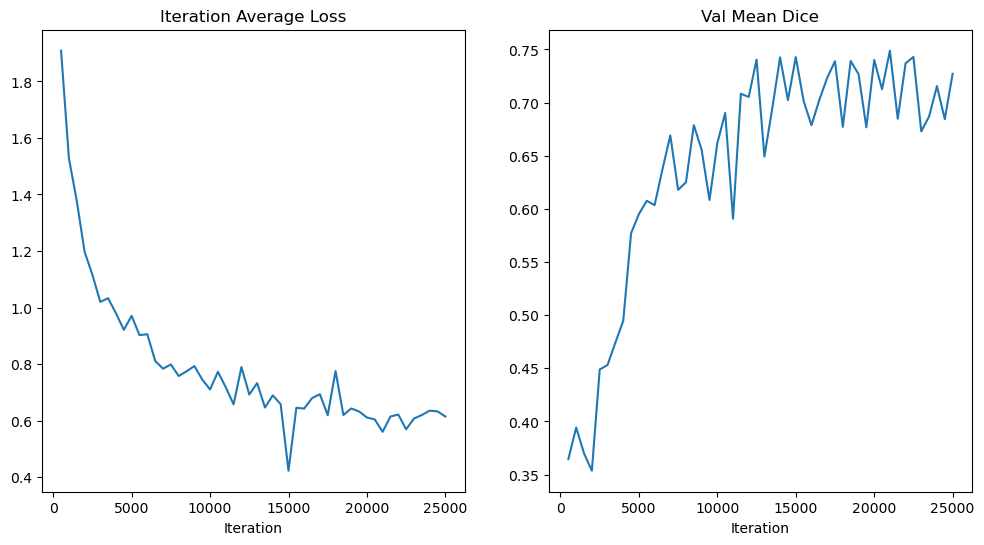

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [7]:
#test
test = torch.randn(4, 1, 96, 96, 96).cuda()
output = model(test)

x_in vit torch.Size([4, 1, 96, 96, 96])
x_in affter embed torch.Size([4, 216, 384])
torch.Size([4, 216, 384])


In [4]:
#inference MMH
#导入用到得module
import os
import shutil
import numpy as np
import itk
from PIL import Image
import tempfile
from monai.data import ITKReader, PILReader
from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose,Invertd,AsDiscreted, SaveImaged,
)
from monai.handlers.utils import from_engine

from monai.config import print_config

from monai.inferers import sliding_window_inference
from monai.data import NiftiSaver

device = torch.device("cuda:0")

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [11]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
#             print(val_inputs.shape,val_labels.shape)
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

In [8]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [9]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
   [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)


val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=57, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
# set_track_meta(False)

Loading dataset: 100%|██████████████████████████| 57/57 [00:18<00:00,  3.12it/s]


In [10]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:12<00:00,  4.65it/s]

dice_val: 0.2666066586971283


In [11]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.34900960326194763


In [12]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.02it/s]

dice_val: 0.31487661600112915


In [13]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.4232094883918762


In [14]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  4.95it/s]

dice_val: 0.3234732747077942


In [ ]:
#inference MMH up down flip

In [23]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503_updown_flip/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
   [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=100, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors

Loading dataset: 100%|██████████████████████████| 57/57 [00:19<00:00,  2.93it/s]


In [24]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  4.91it/s]

dice_val: 0.2643609642982483


In [25]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.07it/s]

dice_val: 0.30316197872161865


In [26]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.32531973719596863


In [27]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.16it/s]

dice_val: 0.3863683342933655


In [28]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.08it/s]

dice_val: 0.3078237771987915


In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [6]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

In [7]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [9]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
        [LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),]
)


val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=100, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
# set_track_meta(False)

Loading dataset: 100%|████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


In [12]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.87it/s]

dice_val: 0.7673020362854004


In [13]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.78it/s]

dice_val: 0.7603350877761841


In [14]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.86it/s]

dice_val: 0.7831133008003235


In [15]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.85it/s]

dice_val: 0.7857744097709656


In [16]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.80it/s]

dice_val: 0.7703914046287537


In [5]:
#prediction
# data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/'
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

test_files = load_decathlon_datalist(datasets, True, "validation")

test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="/media/user/2tb/dataset/wordpred/frequency_unetr", output_postfix="", resample=False),
    ]
)

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_num=114, cache_rate=1.0, num_workers=4)
test_ds = CacheDataset(data=test_files, transform=test_transforms, num_workers=4)
test_loader = ThreadDataLoader(test_ds, num_workers=0, batch_size=1)

# data = transform(img_path).to(device)

Loading dataset: 100%|████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,#14
    img_size=(96, 96, 96),
    feature_size=16,#16 48
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)


loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1
# with torch.no_grad():
# #     for case_num in range(0,114):
#     img_name = os.path.split(test_ds[case_num]["image"].meta["filename_or_obj"])[1]
#     img = test_ds[case_num]["image"]
#     test_inputs = torch.unsqueeze(img, 1).cuda()
#     test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), 4, model, overlap=0.8,sw_device="cuda")
#     test_outputs=torch.argmax(test_outputs, dim=1)
# #     saver=NiftiSaver(output_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/datasetmajei/swinunetr_majei_output',output_ext=img_name)
#     saver=NiftiSaver(output_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/datasetmajei',output_ext=img_name)
#     saver.save(test_outputs

# with torch.no_grad():
#     for test_data in test_loader:
#         test_inputs = test_data["image"].to(device)
#         test_data["pred"] = sliding_window_inference(test_inputs, (96,96,96), 4, model)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]
#         test_output = from_engine(["pred"])(test_data)


with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96,96,96), 4, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)


RuntimeError: applying transform <monai.transforms.post.dictionary.Invertd object at 0x7f1b7ade47d0>